# Imports and Data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import time
import copy
import os


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']

calls = {}
pairs = {}
lives = {}

## MIT

A different approach. I will create a dictionary with the calls data fro all three cohorts. This time, I will keep all egos, because I will make some constraints to the data in order to make pairs of ego-alter comparable, even if they appeared at different points in time. 

In [2]:
%time calls['mit'] = pc.allcalls('CallLog.csv', (), 'participantID.A', 'number.hash', ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
calls['mit'].head()

CPU times: user 668 ms, sys: 79.9 ms, total: 747 ms
Wall time: 760 ms


ego                                     alter                time  \
0  fa10-01-19  10153fa58c24d1a2eb54b3c6ac39482acb61131c 2010-12-31 16:44:24   
1  fa10-01-22  101b96d65031e2792acd950125d90cf9ff30b5ac 2011-05-23 20:59:05   
2  fa10-01-12  1023b616632f3ba048b2f1d1374788bfa0444a8d 2011-01-22 14:01:07   
3  fa10-01-01  102c517fc9ecf84975448470893c3799f5588c8a 2011-05-27 17:52:56   
4  fa10-01-07  102cd812edb5689302bcc57df8330cff44727bd1 2011-04-04 10:02:50   

   uclock  aclock  
0     307       0  
1     450       0  
2     328       0  
3     454       0  
4     400       0

In [3]:
%time pairs['mit'] = pc.pairs(calls['mit'])
%time lives['mit'] = pc.lives_dictionary(calls['mit'])

CPU times: user 54.9 ms, sys: 7 ms, total: 61.9 ms
Wall time: 64.5 ms
CPU times: user 213 ms, sys: 10.7 ms, total: 224 ms
Wall time: 225 ms


## UK

I need to divide the UK dataset in two cohorts: `uk1` contains all alters appeared in the first six months of data; and `uk2` all alters appearing after six months

In [4]:
tmp1 = pc.allcalls("../ukdata/collected_dunbar_calls_v3_e26OK_sorted.csv", (3, 'call'), 1, 2, [6,7], '%d/%m/%y %H:%M', header=False, min_activity=1)
tmp1.head()

ego           alter                time  uclock  aclock
0  C07814508939  C0020165636994 2008-02-07 16:18:00     339       0
1  C07814508939  C0020165636994 2008-02-07 17:11:00     339       0
2  C07814508939  C0020165636994 2008-02-20 15:39:00     352      13
3  C07792658311  C0021213487966 2008-02-27 17:01:00     359       0
4  C07792658311  C0021213487966 2008-02-27 17:55:00     359       0

In [5]:
# Temporary data, since I will create two cohorts out of these
tmp2 = pc.pairs(tmp1)
tmp3 = pc.lives_dictionary(tmp1)

In [6]:
rmalter = {}
for ego in tmp3.keys():
    rmalter[ego] = []
    for alter in tmp3[ego].keys():
        if tmp3[ego][alter]['t0'] < 180:
            rmalter[ego].append(alter)
            
for i in tmp1.index:
    ego = tmp1.at[i, 'ego']
    alter = tmp1.at[i, 'alter']
    if alter in rmalter[ego]:
        tmp1.at[i, 'rm'] = 1
    else:
        tmp1.at[i, 'rm'] = 0

calls['uk1'] = tmp1.loc[tmp1['rm'] == 1]
calls['uk1'].drop(columns=['rm'], inplace=True)
calls['uk1'].reset_index(drop=True, inplace=True)

new = tmp1.loc[tmp1['rm'] == 0]
new = new.loc[new['uclock'] >= 180]
new['uclock'] -= 180
new.to_csv("tmp2.csv")
calls['uk2'] = pc.allcalls("tmp2.csv", (), 'ego', 'alter', ['time'], '%Y-%m-%d %H:%M:%S')
calls['uk2'].reset_index(drop=True, inplace=True)
os.system("rm tmp2.csv")

/Users/vsvh/jupyter/jupyter/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


0

In [7]:
len(calls['uk1']) + len(calls['uk2']) == len(tmp1)

True

In [8]:
for c in ['uk1', 'uk2']:
    pairs[c] = pc.pairs(calls[c])
    lives[c] = pc.lives_dictionary(calls[c])

# Limit data

In order to make all pairs of ego-alters (in all three cohorts comparable, I will limit the amount of phone calls to be analized, using the following criteria:

1. Only consider phone calls made by egos 30 days or later than their first appeareance.
2. For each alter, its maximum value of $a$ will be 200 days. This makes $\max_{\ell} = 200$.
3. Remove all alters whose first appeareance was **after** $T - \max{a}$. This is to guarantee that every alter could potentially reach $\max{a}$.

## Remove first 30 days of activity for each ego

In [9]:
calls.keys()

dict_keys(['mit', 'uk1', 'uk2'])

In [10]:
for c in calls.keys():
    uno = calls[c].groupby('ego')[['uclock']].min()
    dos = pd.DataFrame()
    for ego in calls[c]['ego'].unique():
        df = calls[c].loc[calls[c]['ego'] == ego]
        minday = uno.loc[ego]['uclock'] + 30
        df1 = df.loc[df['uclock'] >= minday]
        dos = dos.append(df1).reset_index(drop=True)
    old = len(calls[c])
    calls[c] = dos
    print(f'{c} lost {old - len(calls[c])} calls')

mit lost 19098 calls
uk1 lost 5733 calls
uk2 lost 1684 calls


## Limit $\max{a}$ to 200

In [11]:
for c in calls.keys():
    old = len(calls[c])
    calls[c] = calls[c].loc[calls[c]['aclock'] <= 200]
    print(f'{c} lost {old - len(calls[c])} calls')

mit lost 24426 calls
uk1 lost 37748 calls
uk2 lost 3229 calls


## Remove all alters with $t(0) > T - \max{a}$

In [12]:
for c in calls.keys():
    uno = pd.DataFrame()
    T = max(calls[c]['uclock'])
    for ego in calls[c]['ego'].unique():
        df = calls[c].loc[calls[c]['ego'] == ego]
        for alter in df['alter'].unique():
            df2 = df.loc[df['alter'] == alter]
            mint = min(df2['uclock'])
            if mint < (T - 200):
                df2.loc[:, 'aclock'] = df2['uclock'] - mint
                uno = uno.append(df2).reset_index(drop=True)
    old = len(calls[c].groupby(['ego', 'alter'])[['aclock']].count())
    calls[c] = uno
    new = len(calls[c].groupby(['ego', 'alter'])[['aclock']].count())
    print(f'{c} lost {old - new} pairs of ego-alter')

/Users/vsvh/jupyter/jupyter/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


mit lost 7649 pairs of ego-alter
uk1 lost 38 pairs of ego-alter
uk2 lost 1905 pairs of ego-alter


In [13]:
maxell = 0
for c in lives.keys():
    for ego in lives[c].keys():
        for alter in lives[c][ego].keys():
            ell = lives[c][ego][alter]['ell']
            if ell > maxell:
                maxell = ell
    print(f'{c} has max ell {maxell}')

mit has max ell 458
uk1 has max ell 534
uk2 has max ell 534


In [14]:
for c in calls.keys():
    pairs[c] = pc.pairs(calls[c])
    lives[c] = pc.lives_dictionary(calls[c])

## This is a required fix

For some reason, the above calls dataframes do not have the correct $a$ variable for some of the calls. To fix it, the code below is required.

In [15]:
#timer0 = time.time()
#for c in calls.keys():
#    df = calls[c]
#    newdf = pd.DataFrame()
#    for ego in df['ego'].unique():
#        df2 = df.loc[df['ego'] == ego]
#        for alter in df2['alter'].unique():
#            df3 = df2.loc[df2['alter'] == alter]
#            t0 = lives[c][ego][alter]['t0']
#            df3['aclock'] = df3['uclock'] - t0
#            newdf = newdf.append(df3).reset_index(drop=True)
#    calls[c] = newdf
#print(f'Took {time.time() - timer0}')

In [16]:
maxell = 0
for c in lives.keys():
    for ego in lives[c].keys():
        for alter in lives[c][ego].keys():
            ell = lives[c][ego][alter]['ell']
            if ell > maxell:
                maxell = ell
    print(f'{c} has max ell {maxell}')

mit has max ell 200
uk1 has max ell 200
uk2 has max ell 200


# Function to save the results as tikz data

# Histogram of $\ell$

Even considering that the lifetime of every alter is limited to $0 \leq \ell \leq 200$; to deal with the heterogeneous values I could find, I will use bins of 10 days to create $0 \leq \lambda \leq 20$

In [17]:
timer0 = time.time()
Hlamb = {}
for c in lives.keys():
    Hlamb[c] = {}
    for ego in lives[c].keys():
        for alter in lives[c][ego].keys():
            lamb = lives[c][ego][alter]['ell'] // 10
            Hlamb[c][lamb] = Hlamb[c].get(lamb, 0) + 1
    Hlamb[c] = pd.DataFrame.from_dict(Hlamb[c], orient='index')
    Hlamb[c].sort_index(inplace=True)
print(f'This block took {time.time() - timer0}')

This block took 0.007025003433227539


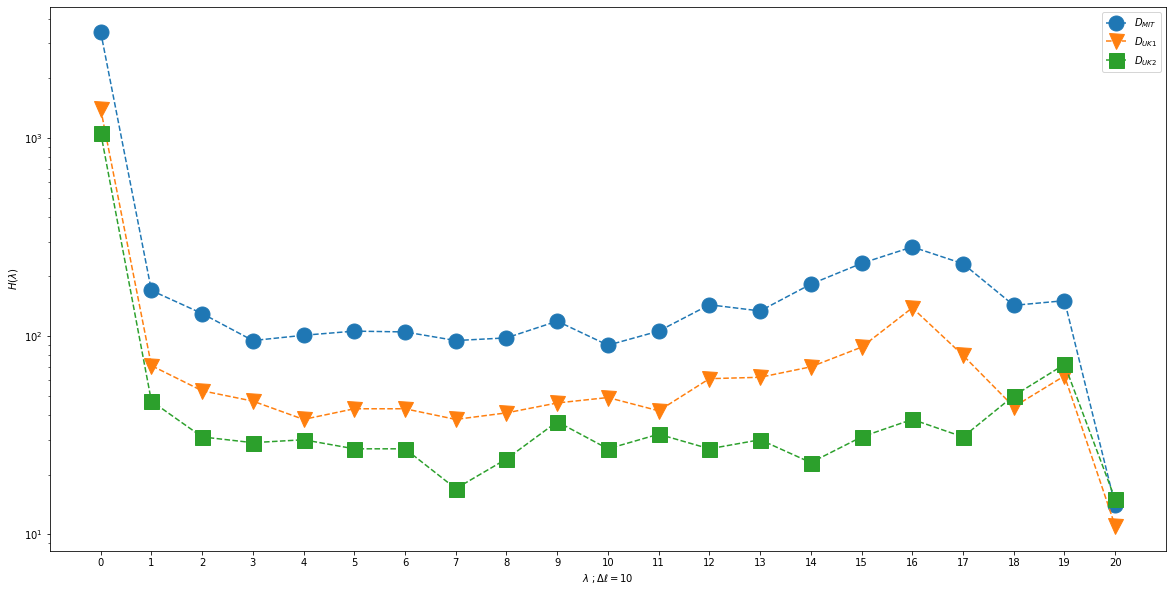

In [18]:
plt.xlabel(r'$\lambda \; ; \Delta \ell = 10$')
plt.ylabel(r'$H(\lambda)$')
plt.yscale("log")
plt.xticks(range(21))
m = 0
for c in Hlamb.keys():
    plt.plot(Hlamb[c].index, Hlamb[c][0], marker=markers[m], linestyle="--", markersize=15, label=fr"${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][m]}$")
    m += 1
plt.legend()

# Histogram of $a$

Similar to $\ell$, I will calculate the histogram of $a$ by taking bins of size 10. Thus, $0 \leq \alpha \leq 20$

In [19]:
timer0 = time.time()
Fa = {}
for c in calls.keys():
    Fa[c] = {}
    df = calls[c]
    df['alpha'] = df['aclock'] // 10
    df2 = df.groupby(['alpha'])[['aclock']].count()
    for i in df2.index:
        Fa[c][i] = df2.at[i, 'aclock']
    Fa[c] = pd.DataFrame.from_dict(Fa[c], orient='index')
    Fa[c].sort_index(inplace=True)
print(f'This block took {time.time() - timer0}')

This block took 0.014909029006958008


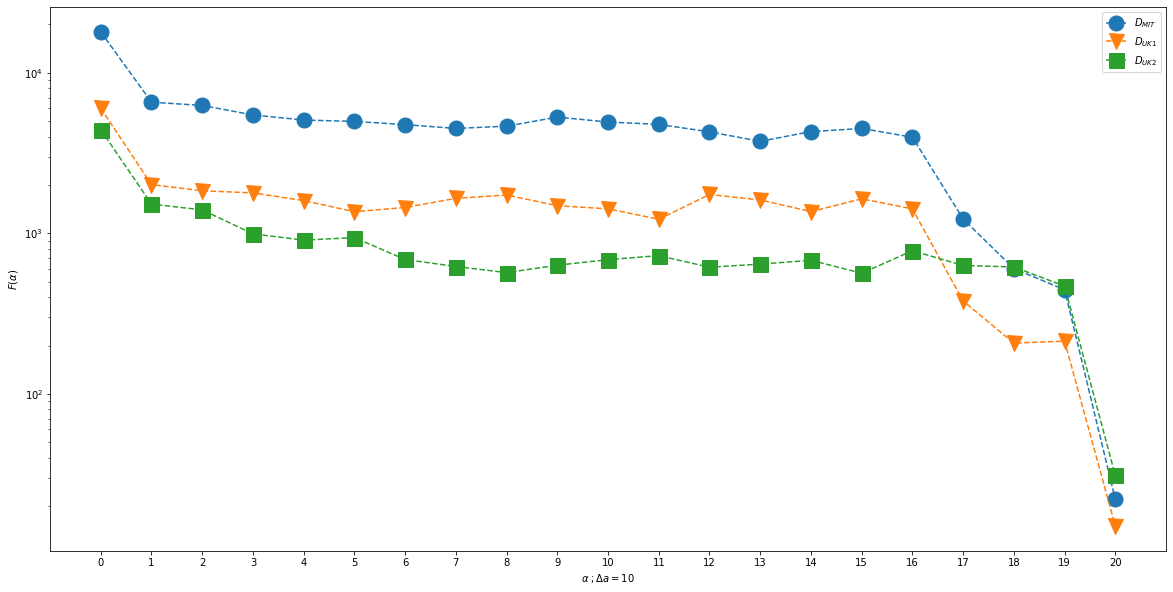

In [20]:
plt.xlabel(r'$\alpha \; ; \Delta a = 10$')
plt.ylabel(r'$F(\alpha)$')
plt.yscale("log")
plt.xticks(range(21))
m = 0
for c in Fa.keys():
    plt.plot(Fa[c].index, Fa[c][0], marker=markers[m], linestyle="--", markersize=15, label=fr"${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][m]}$")
    m += 1
plt.legend()

# $\langle b \rangle$ as a function of $\lambda$

In [21]:
dff = {}
for c in calls.keys():
    %time dff[c] = pc.get_f(calls[c], 'all', 70, 10)

/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 13.5 s, sys: 63.6 ms, total: 13.6 s
Wall time: 13.6 s
CPU times: user 5.83 s, sys: 47.3 ms, total: 5.88 s
Wall time: 5.93 s
CPU times: user 3.76 s, sys: 32.6 ms, total: 3.79 s
Wall time: 3.81 s


In [22]:
bplot = {}
for c in dff.keys():
    %time b = pc.get_b(dff[c], 'lambda')
    %time bplot[c] = pc.plot_g(b, 'lambda')

CPU times: user 3.5 s, sys: 40.8 ms, total: 3.54 s
Wall time: 3.56 s
CPU times: user 72.1 ms, sys: 2.13 ms, total: 74.2 ms
Wall time: 74.4 ms
CPU times: user 1.22 s, sys: 14.6 ms, total: 1.23 s
Wall time: 1.23 s
CPU times: user 41.8 ms, sys: 804 µs, total: 42.6 ms
Wall time: 42.5 ms
CPU times: user 787 ms, sys: 15.6 ms, total: 803 ms
Wall time: 796 ms
CPU times: user 37 ms, sys: 1.1 ms, total: 38.1 ms
Wall time: 37.5 ms


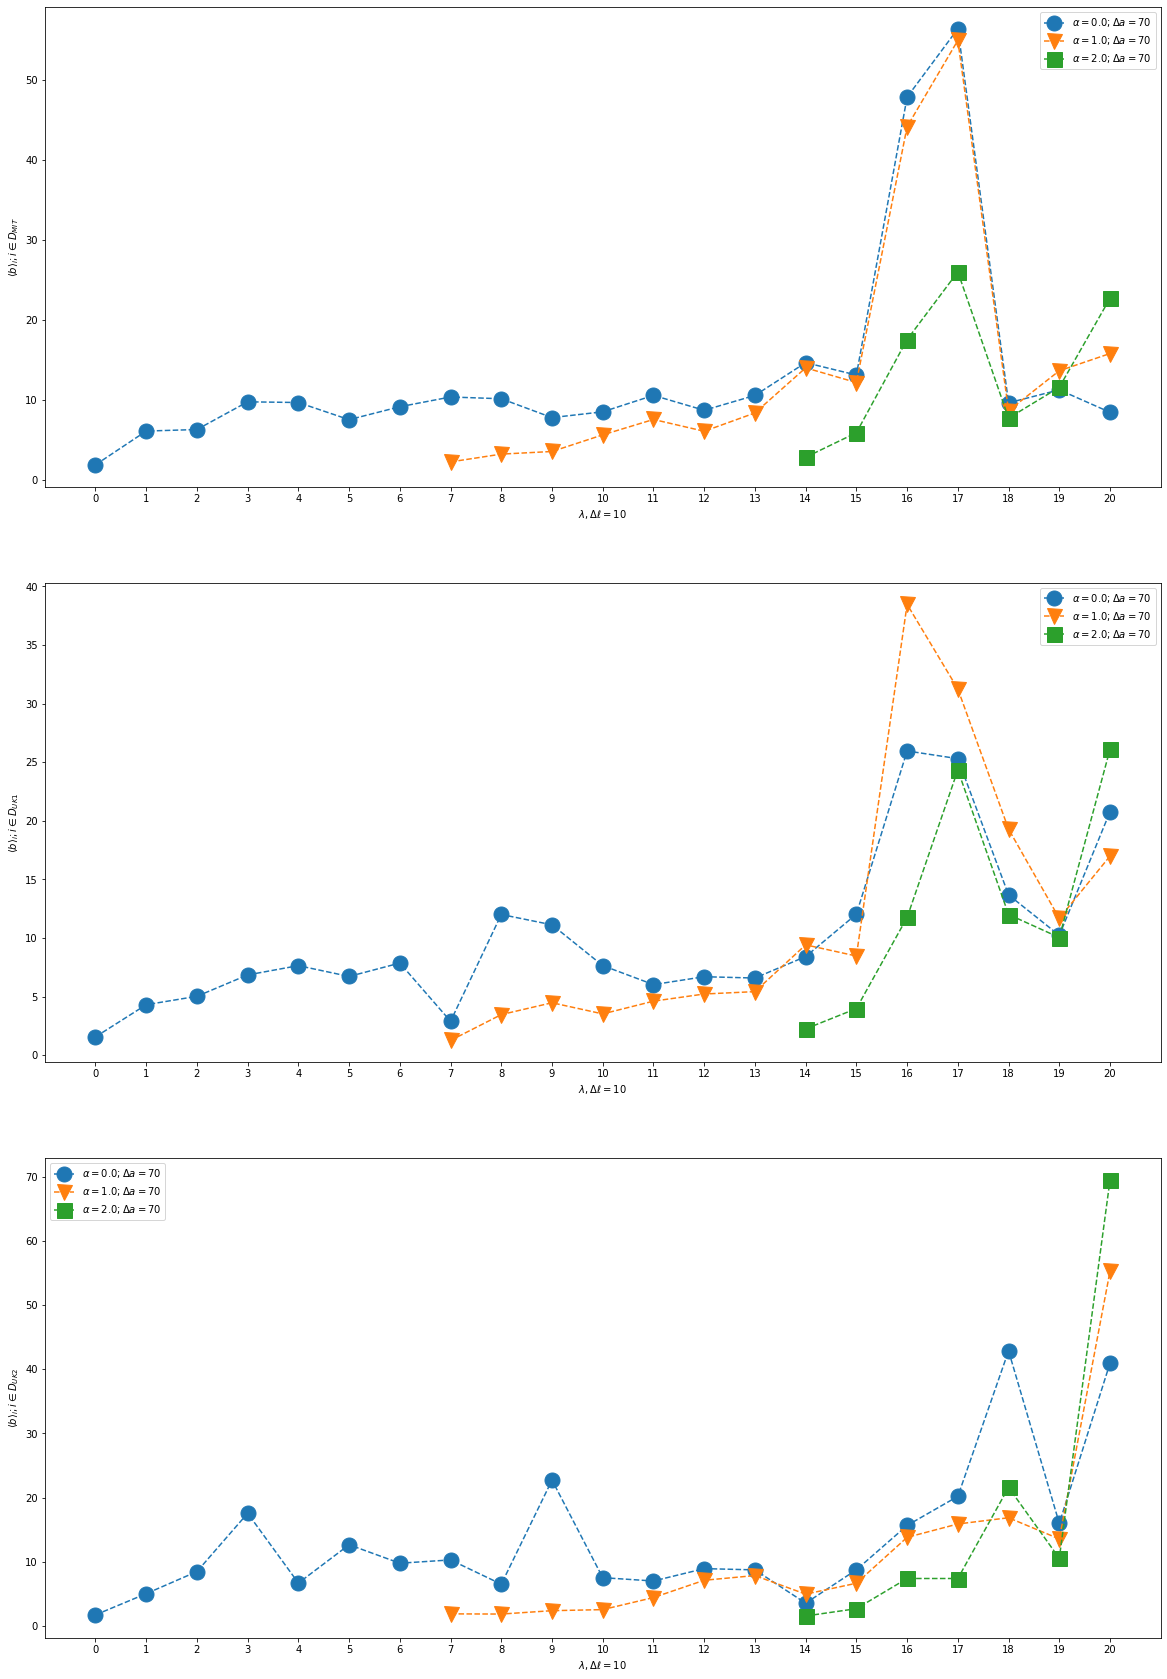

In [23]:
plt.figure(figsize=(20, 30))
p = 1
for c in bplot.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"$\lambda, \Delta \ell = 10$")
    plt.ylabel(fr"$\langle b \rangle_i; i \in {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    plt.xticks(range(21))
    m = 0
    for alpha in bplot[c].keys():
        plt.plot(bplot[c][alpha].index, bplot[c][alpha]['lambda'], marker=markers[m], markersize=15, linestyle="--", label=fr'$\alpha = {alpha}; \Delta a = 70$')
        m += 1
    p += 1
    plt.legend()

## $\langle b \rangle$ as a function of $\alpha$

In [24]:
dff2 = {}
for c in calls.keys():
    %time dff2[c] = pc.get_f(calls[c], 'all', 10, 60)

/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 14.3 s, sys: 98.7 ms, total: 14.4 s
Wall time: 14.5 s
CPU times: user 5.2 s, sys: 23.2 ms, total: 5.23 s
Wall time: 5.22 s
CPU times: user 3.44 s, sys: 16.1 ms, total: 3.46 s
Wall time: 3.46 s


In [25]:
bplot2 = {}
for c in dff2.keys():
    %time b = pc.get_b(dff2[c], 'alpha')
    %time bplot2[c] = pc.plot_g(b, 'alpha')

CPU times: user 4.15 s, sys: 28.9 ms, total: 4.18 s
Wall time: 4.18 s
CPU times: user 95 ms, sys: 1.29 ms, total: 96.2 ms
Wall time: 95.7 ms
CPU times: user 1.72 s, sys: 14.7 ms, total: 1.74 s
Wall time: 1.73 s
CPU times: user 52.5 ms, sys: 765 µs, total: 53.3 ms
Wall time: 52.9 ms
CPU times: user 1.1 s, sys: 11.7 ms, total: 1.11 s
Wall time: 1.11 s
CPU times: user 48.9 ms, sys: 1.09 ms, total: 50 ms
Wall time: 49.2 ms


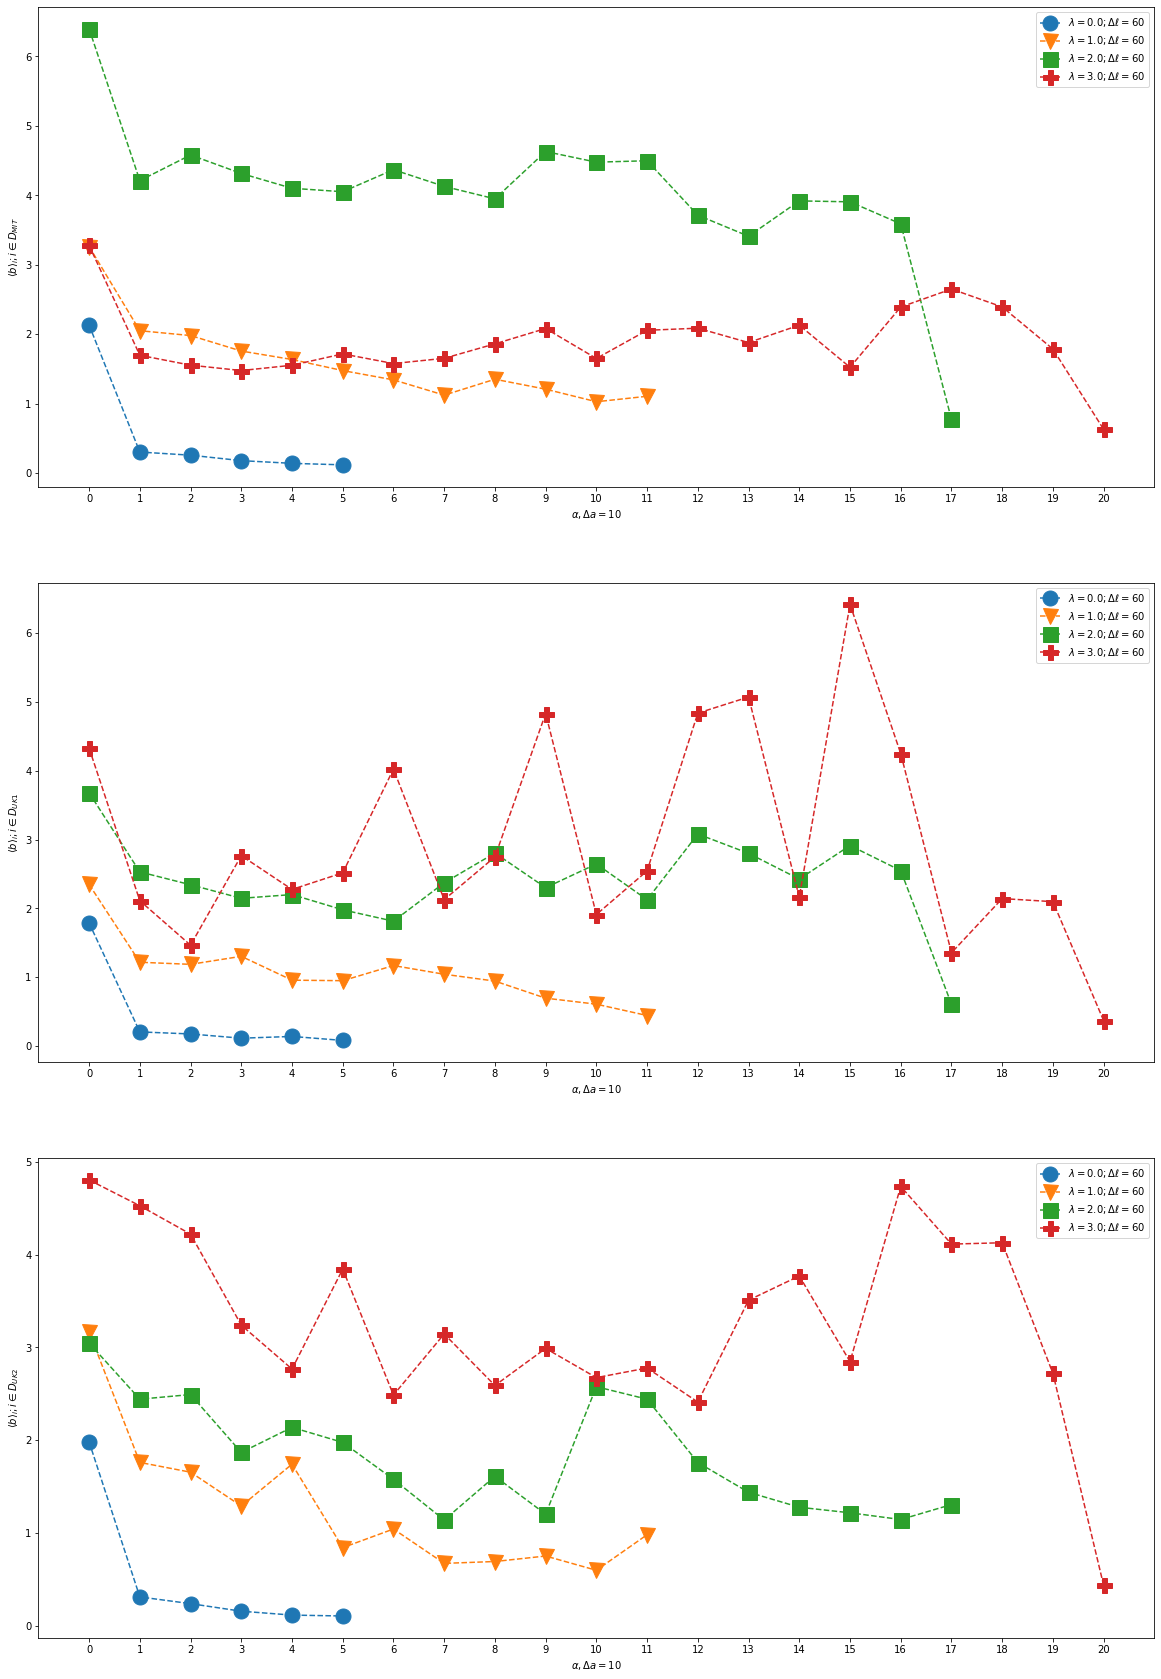

In [26]:
plt.figure(figsize=(20, 30))
p = 1
for c in bplot2.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"$\alpha, \Delta a = 10$")
    plt.ylabel(fr"$\langle b \rangle_i; i \in {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    plt.xticks(range(21))
    m = 0
    for lamb in bplot2[c].keys():
        plt.plot(bplot2[c][lamb].index, bplot2[c][lamb]['alpha'], marker=markers[m], markersize=15, linestyle="--", label=fr'$\lambda = {lamb}; \Delta \ell = 60$')
        m += 1
    p += 1
    plt.legend()

In [27]:
bplot2['uk1']

{0.0:         alpha
 0.0  1.788139
 1.0  0.205901
 2.0  0.175928
 3.0  0.114395
 4.0  0.139927
 5.0  0.082080,
 1.0:          alpha
 0.0   2.347647
 1.0   1.217674
 2.0   1.187292
 3.0   1.303691
 4.0   0.957301
 5.0   0.949823
 6.0   1.169588
 7.0   1.043398
 8.0   0.944078
 9.0   0.695988
 10.0  0.608448
 11.0  0.443929,
 2.0:          alpha
 0.0   3.679186
 1.0   2.530340
 2.0   2.343447
 3.0   2.146672
 4.0   2.200872
 5.0   1.979588
 6.0   1.814267
 7.0   2.371964
 8.0   2.804327
 9.0   2.301343
 10.0  2.645437
 11.0  2.126371
 12.0  3.080329
 13.0  2.799874
 14.0  2.426145
 15.0  2.913648
 16.0  2.549489
 17.0  0.608775,
 3.0:          alpha
 0.0   4.328860
 1.0   2.111495
 2.0   1.465715
 3.0   2.766547
 4.0   2.275557
 5.0   2.517037
 6.0   4.023780
 7.0   2.127357
 8.0   2.748328
 9.0   4.830962
 10.0  1.911208
 11.0  2.544805
 12.0  4.837018
 13.0  5.070815
 14.0  2.162976
 15.0  6.416807
 16.0  4.249313
 17.0  1.355362
 18.0  2.142775
 19.0  2.097933
 20.0  0.369625}

# Lifetime separated by activity

In [28]:
fdist = {}
perc = {}
for c in dff.keys():
    allf = []
    for ego in dff[c].keys():
        for alter in dff[c][ego].keys():
            df = dff[c][ego][alter].loc[dff[c][ego][alter]['alpha'] == 1]
            for i in df['f']:
                allf.append(i)
    perc[c] = [np.percentile(allf, q) for q in (33, 66, 100)]
    fdist[c] = pc.f_histell(dff[c], 1, perc[c])

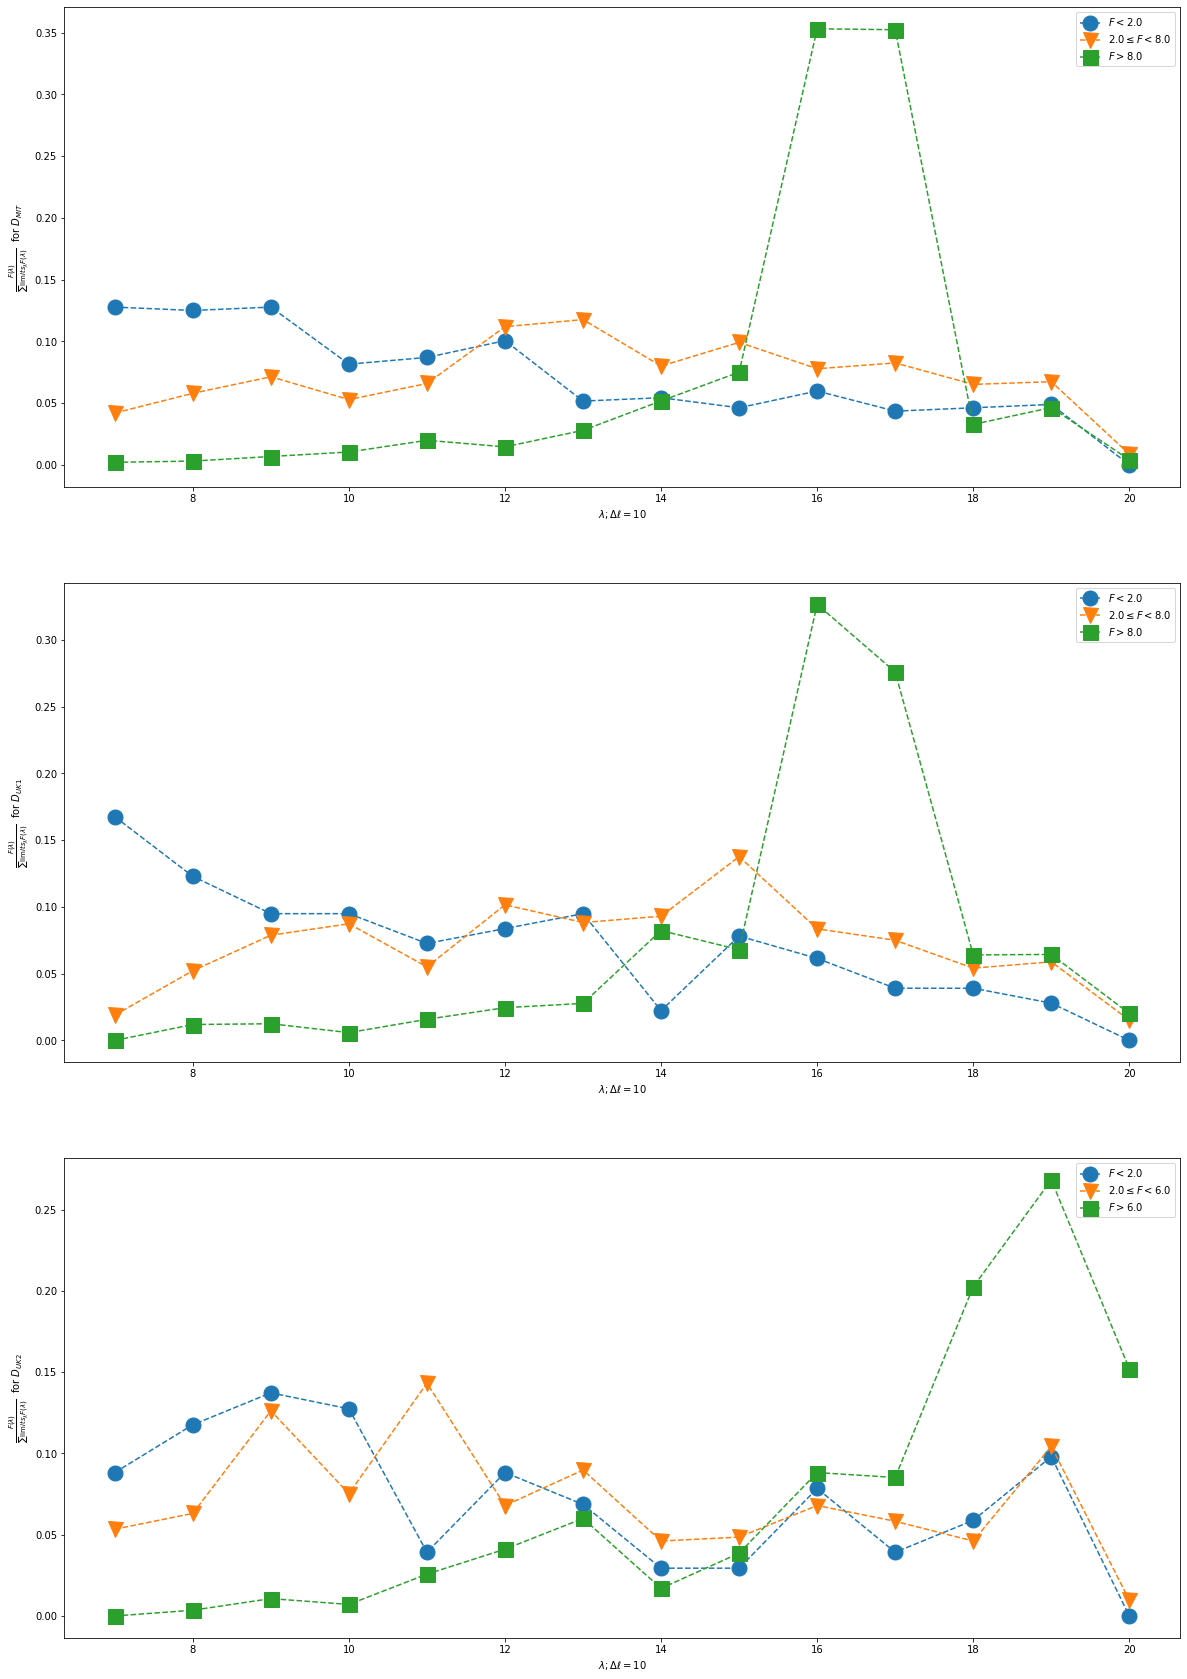

In [29]:
plt.figure(figsize=(20, 30))
p = 1
for c in fdist.keys():
    plt.subplot(3, 1, p)
    legends = [fr"$F < {perc[c][0]}$", fr"${perc[c][0]} \leq F < {perc[c][1]}$", fr"$F > {perc[c][1]}$", r"All $F$"]
    plt.xlabel(r"$\lambda; \Delta \ell = 10$")
    plt.ylabel(r"$\frac{F(\lambda)}{\sum\limits_{\lambda} F(\lambda)}$ " + fr" for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    for i in range(3):
        plt.plot(fdist[c][i].index, fdist[c][i][0] / sum(fdist[c][i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
    plt.legend()
    p+=1

# $\phi$ as bins of activity

In [30]:
phiD = {}
for delta in (3, 5, 7):
    phiD[delta] = {}
    for c in dff.keys():
        phiD[delta][c] = pc.f_histell(dff[c], 1, [], binned=True, deltaF=delta)

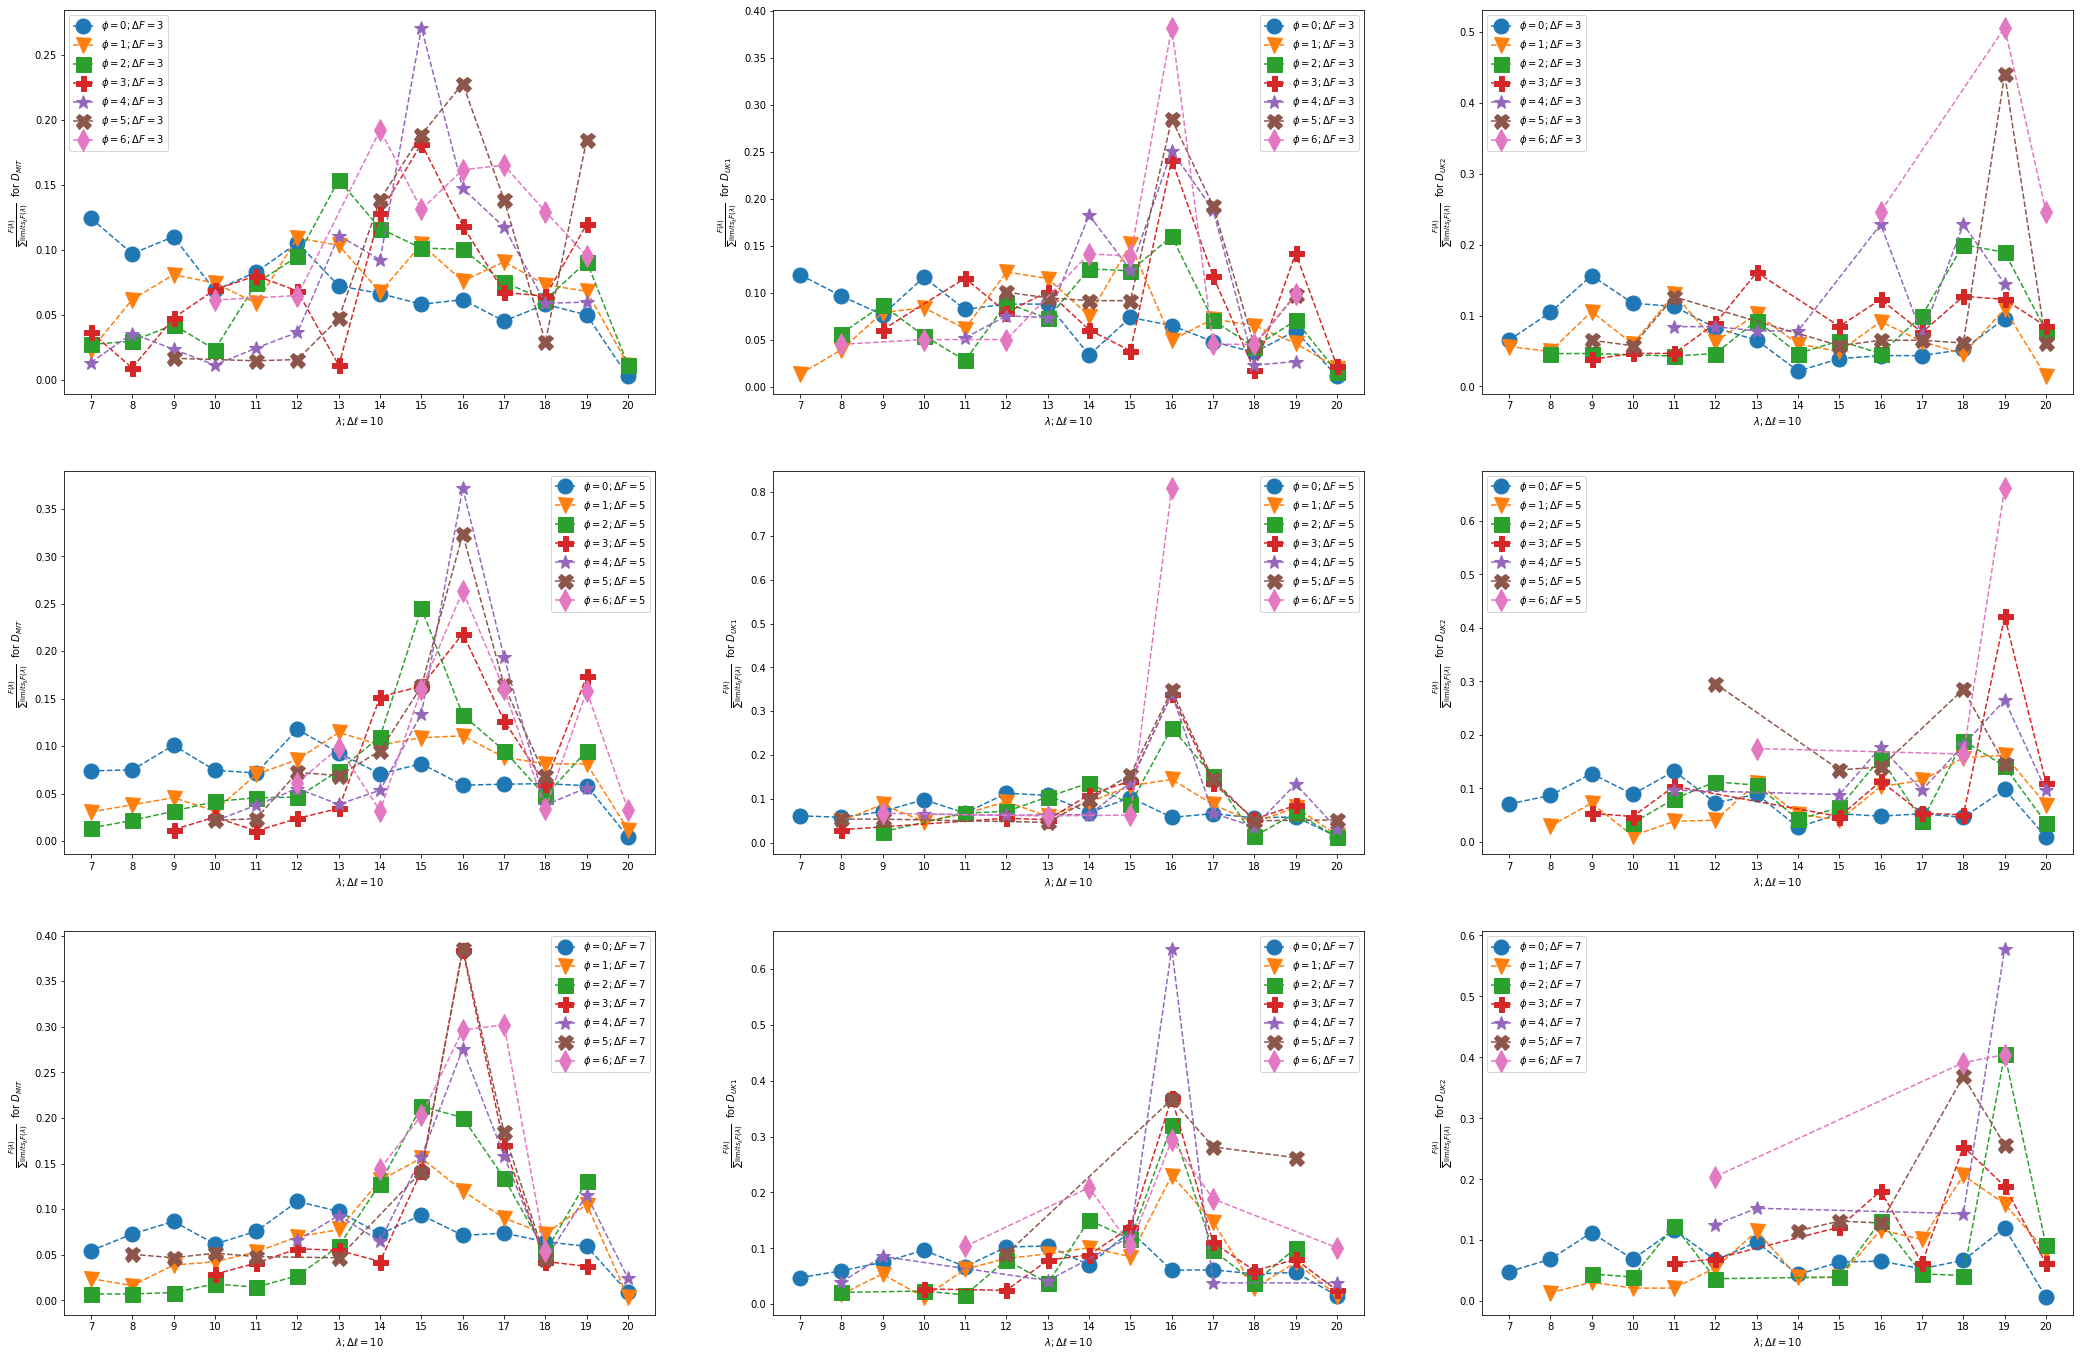

In [31]:
plt.figure(figsize=(36, 24))
p = 1
for delta in phiD.keys():
    for c in phiD[delta].keys():
        plt.subplot(3, 3, p) 
        plt.xlabel(r"$\lambda; \Delta \ell = 10$")
        plt.ylabel(r"$\frac{F(\lambda)}{\sum\limits_{\lambda} F(\lambda)}$ " + fr" for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][(p - 1) % 3]}$")
        plt.xticks(range(21))
        phis = sorted(phiD[delta][c].keys())[:7]
        #phis += sorted(phi4[c].keys())[-20:-17]
        #print(sorted(phi4[c].keys()))
        m = 0
        for phi in phis:
            plt.plot(phiD[delta][c][phi].index, phiD[delta][c][phi][0] / sum(phiD[delta][c][phi][0]), marker=markers[m], markersize=15, linestyle="--", label=fr"$\phi = {phi}; \Delta F = {delta}$")
            m += 1
        plt.legend()
        p += 1

# Probability of alter reaching $\lambda_c$

In [32]:
phi3 = {}
for c in dff.keys():
    phi3[c] = pc.f_histell(dff[c], 1, [], binned=True, deltaF=3)

result = {}
for c in phi3.keys():
    result[c] = {}
    for lambc in [15, 16, 17, 18]:
        result[c][lambc] = {}
        for phi in phi3[c].keys():
            df = phi3[c][phi]
            df['p'] = df[0] / sum(df[0])
            df2 = df.loc[df.index >= lambc]
            if len(df2) > 0:
                result[c][lambc][phi] = sum(df2['p'])
        result[c][lambc] = pd.DataFrame.from_dict(result[c][lambc], orient='index')
        result[c][lambc].sort_index(inplace=True)

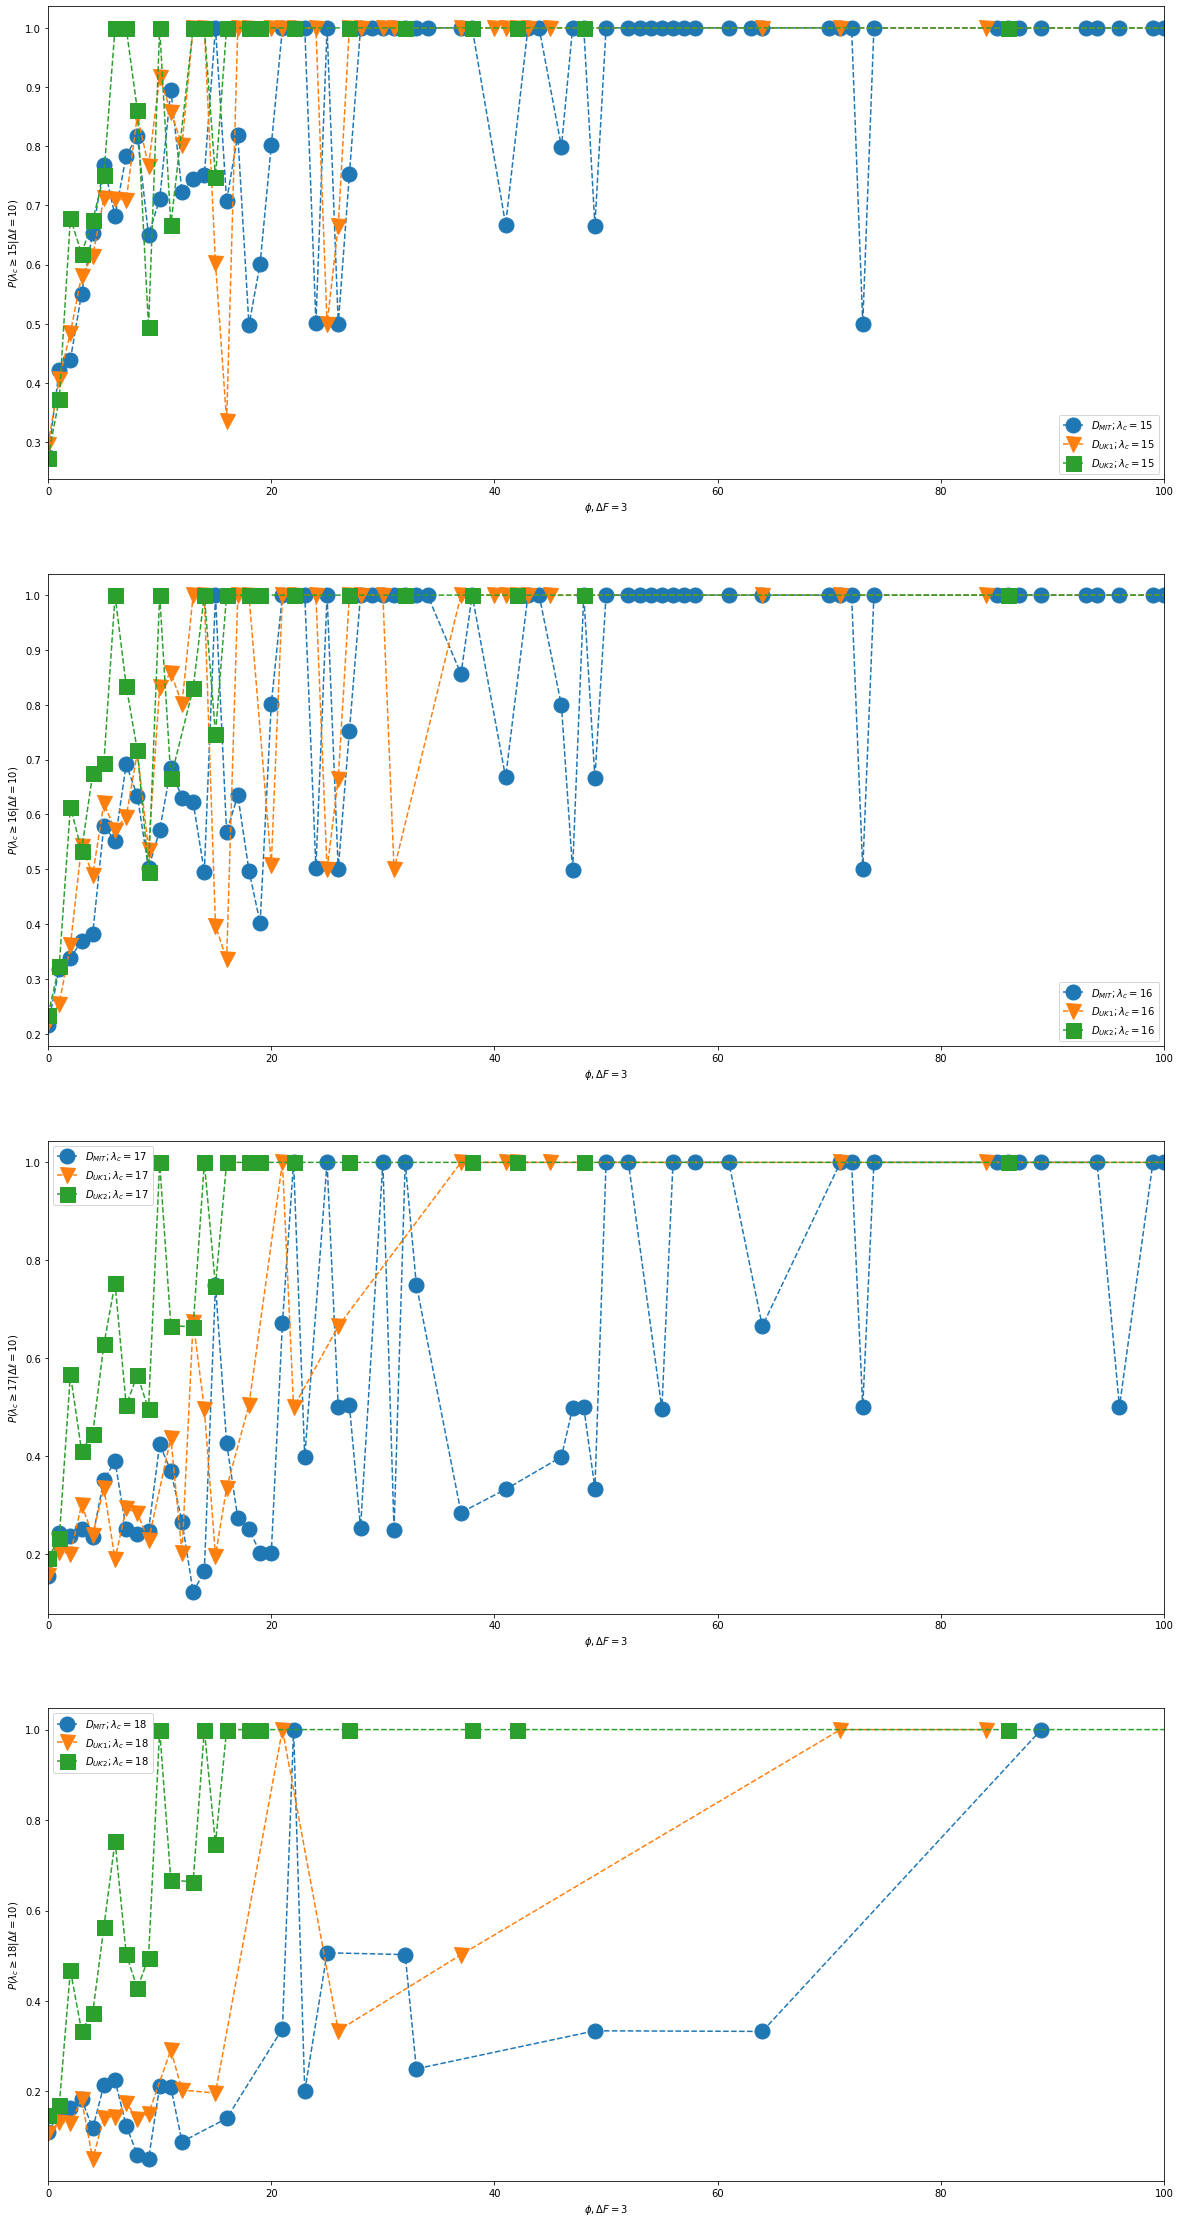

In [33]:
plt.figure(figsize=(20, 40))
p = 1
for lambc in [15, 16, 17, 18]:
    plt.subplot(4, 1, p)
    plt.xlabel(r"$\phi, \Delta F = 3$")
    plt.ylabel(fr"$P(\lambda_c \geq {lambc} | \Delta \ell = 10)$")
    plt.xlim(0, 100)
    m = 0
    for c in result.keys():
        plt.plot(result[c][lambc].index, result[c][lambc][0], marker=markers[m], markersize=15, linestyle="--", label=fr"${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][m]}; \lambda_c = {lambc}$")
        m += 1
    plt.legend()
    p += 1

## Increase $\Delta F$

In [34]:
fdist2 = {}
for c in dff.keys():
    %time fdist2[c] = pc.f_histell(dff[c], 1, [5, 10, 10000])

CPU times: user 5.33 s, sys: 60.9 ms, total: 5.39 s
Wall time: 5.45 s
CPU times: user 2.26 s, sys: 28.4 ms, total: 2.28 s
Wall time: 2.29 s
CPU times: user 1.27 s, sys: 18.9 ms, total: 1.29 s
Wall time: 1.29 s


In [35]:
lcdist = {}
for phi in range(3):
    lcdist[phi] = {}
    for c in fdist2.keys():
        lcdist[phi][c] = {}
        df = fdist2[c][phi]
        df['p'] = df[0] / sum(df[0])
        for lc in range(5, 20):
            df2 = df.loc[df.index >= lc]
            lcdist[phi][c][lc] = sum(df2['p'])
        lcdist[phi][c] = pd.DataFrame.from_dict(lcdist[phi][c], orient='index')
        lcdist[phi][c].sort_index(inplace=True)

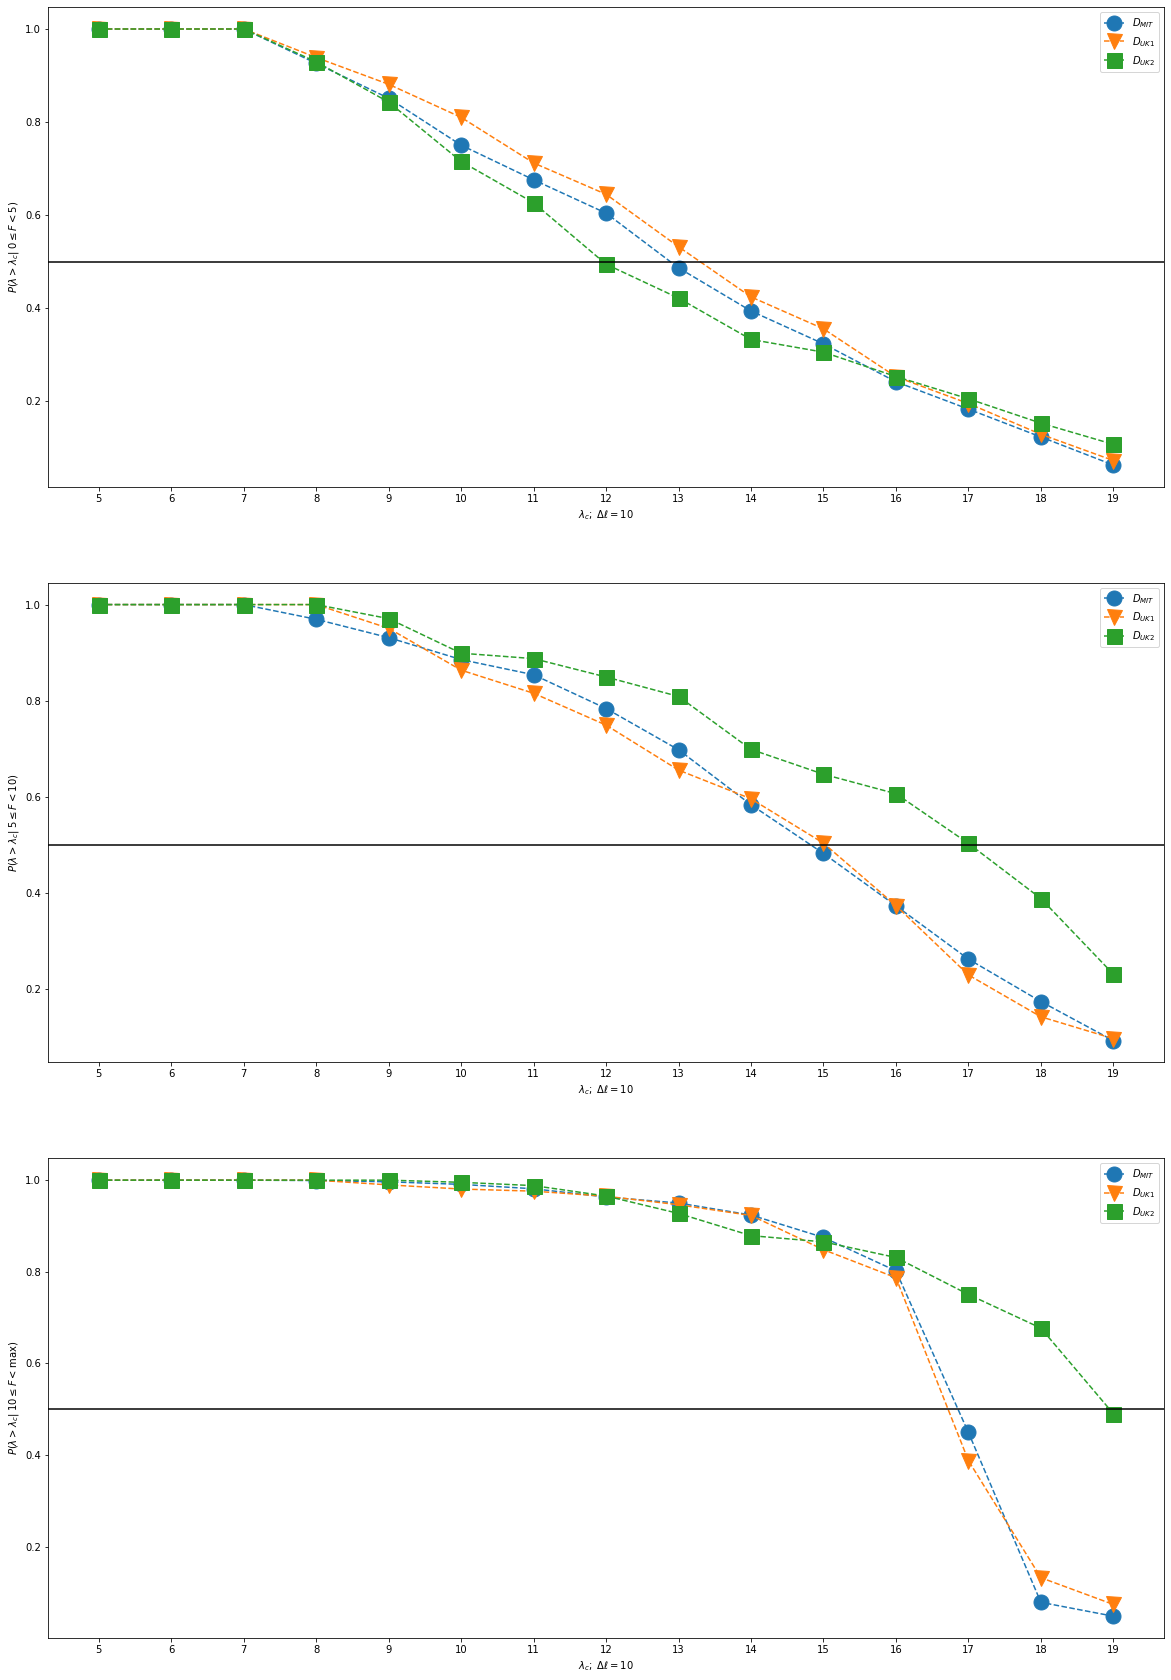

In [36]:
plt.figure(figsize=(20, 30))
p = 1
fs = [0, 5, 10, '\max']
for phi in lcdist.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"$\lambda_{c}; \; \Delta \ell = 10$")
    plt.ylabel(fr"$P(\lambda > \lambda_c | \; {fs[phi]} \leq F < {fs[phi + 1]})$")
    plt.xticks(range(20))
    m = 0
    for c in lcdist[phi].keys():
        plt.plot(lcdist[phi][c].index, lcdist[phi][c][0], marker=markers[m], markersize=15, linestyle="--", label=fr"${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][m]}$")
        m += 1
    plt.axhline(0.5, color="black")
    plt.legend()
    p += 1

In [37]:
maxf = {}
for c in dff.keys():
    maxf[c] = 0
    for ego in dff[c].keys():
        for alter in dff[c][ego].keys():
            df = dff[c][ego][alter]
            localmax = max(df['f'])
            if localmax > maxf[c]:
                maxf[c] = localmax

maxf

{'mit': 536, 'uk1': 916, 'uk2': 617}

I need to choose a point (e.g. 0.5) in the vertical axis, and see what happens with the horizontal axis. The idea is that for each cohort, I will try to make that point in the horizontal axis coincide. Then, using some scaling factor, make the curves coincide. It is important that this needs to be done on a cohort basis, to unbderstand what I'm getting as results.

1. The first thing I will try to scale the three series (just for MIT, in order to test) will be dividing the values in the horizontal axis by some value $(\min{F})^{0.08}$

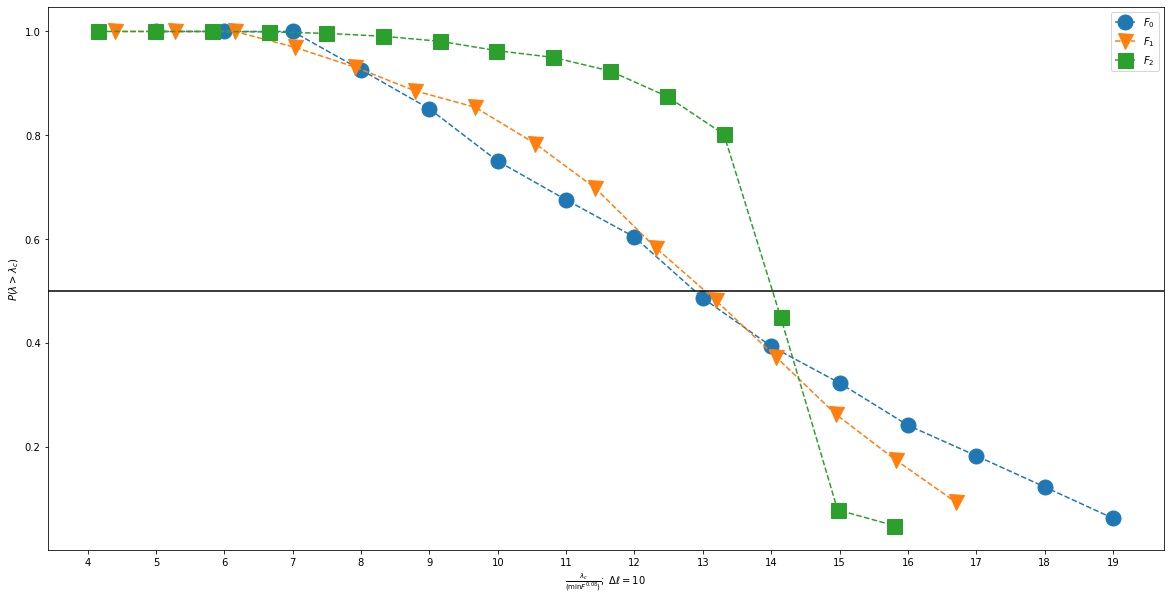

In [38]:
plt.xticks(range(20))
plt.xlabel(r"$\frac{\lambda_{c}}{(\min{F}^{0.08})}; \; \Delta \ell = 10$")
plt.ylabel(fr"$P(\lambda > \lambda_c)$")
for phi in lcdist.keys():
    plt.plot(lcdist[phi]['mit'].index / [1, 5**(0.08), 10**(0.08)][phi], lcdist[phi]['mit'][0] / 1, marker=markers[phi], markersize=15, linestyle="--", label=fr"$F_{phi}$")
plt.axhline(0.5, color="black")
plt.legend()

And now test the same number for all three cohorts

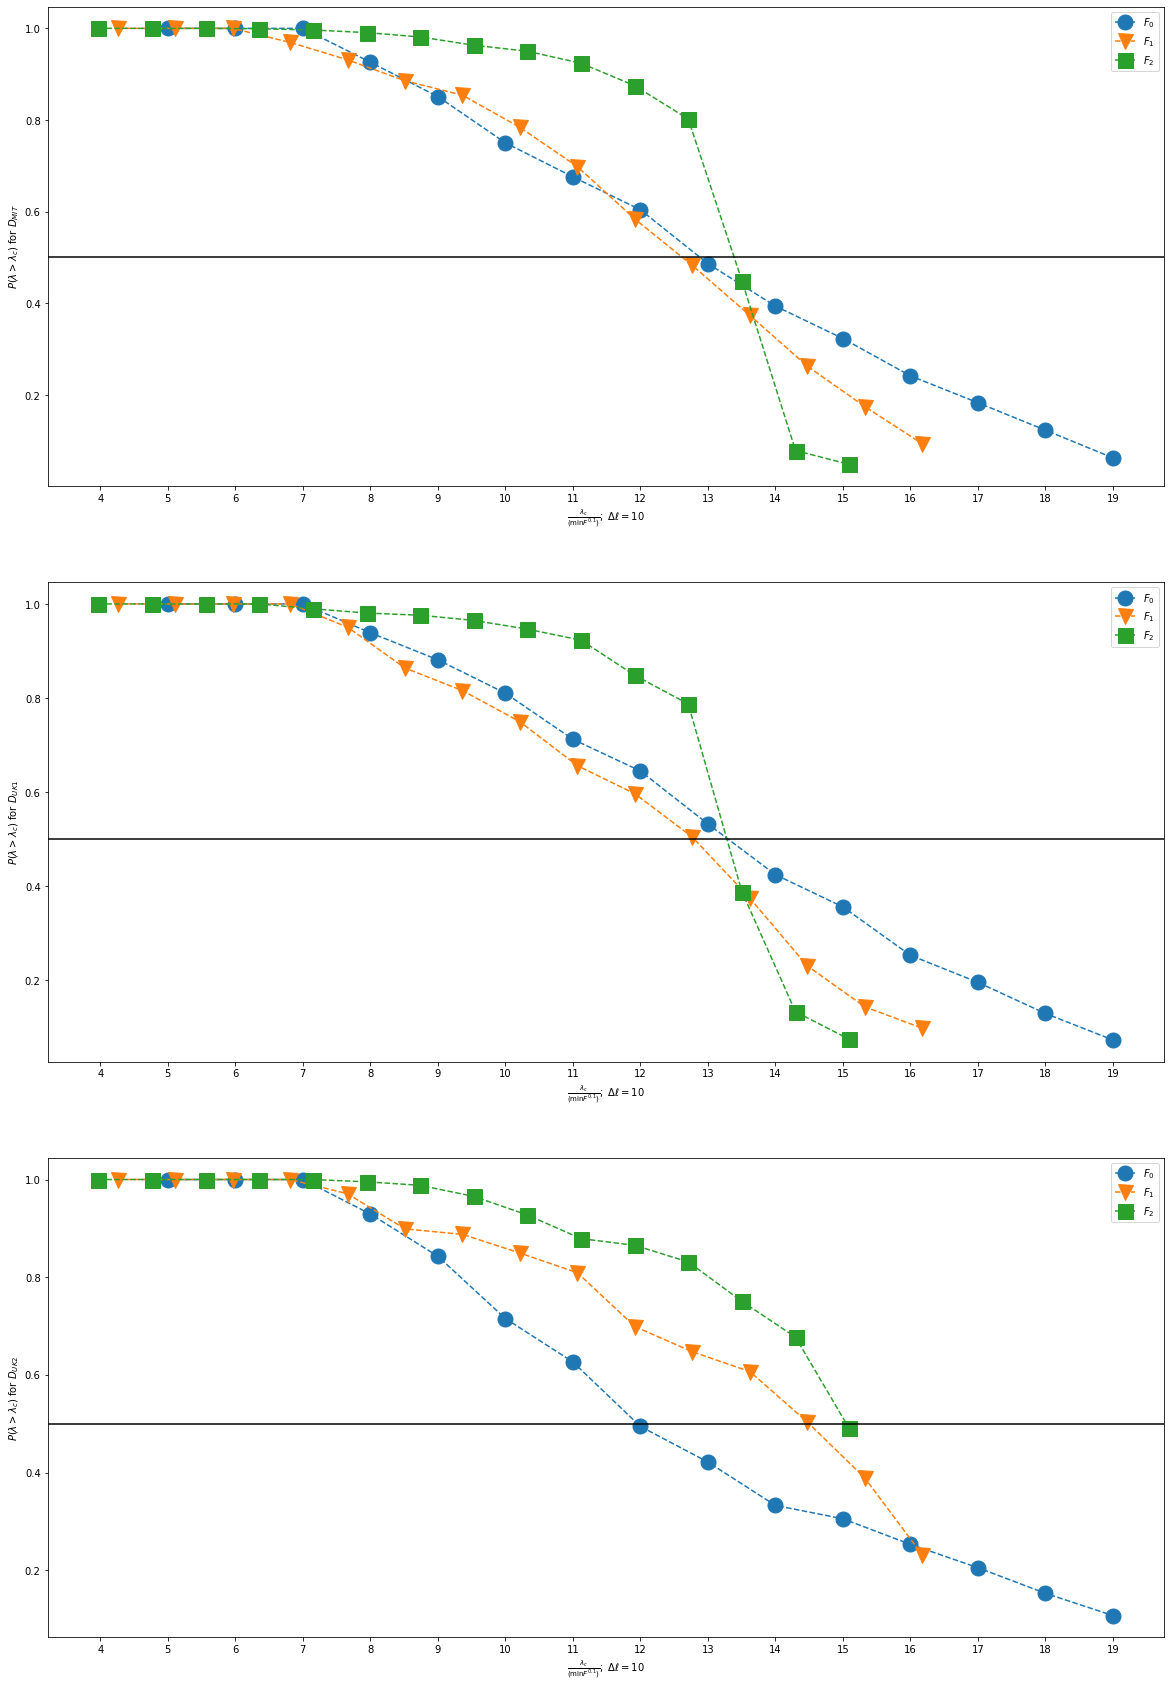

In [39]:
plt.figure(figsize=(20, 30))
p = 1
for c in lcdist[0].keys():
    plt.subplot(3, 1, p)
    plt.xticks(range(20))
    plt.xlabel(r"$\frac{\lambda_{c}}{(\min{F}^{0.1})}; \; \Delta \ell = 10$")
    plt.ylabel(fr"$P(\lambda > \lambda_c)$ for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    for phi in lcdist.keys():
        plt.plot(lcdist[phi][c].index / [1, 5**(0.1), 10**(0.1)][phi], lcdist[phi][c][0], marker=markers[phi], markersize=15, linestyle="--", label=fr"$F_{phi}$")
    plt.axhline(0.5, color="black")
    plt.legend()
    p += 1

Since $D_{UK2}$ does not scale well using $(\min{F})^{0.1}$, I will use $(\min{F})^{0.2}$ instead.

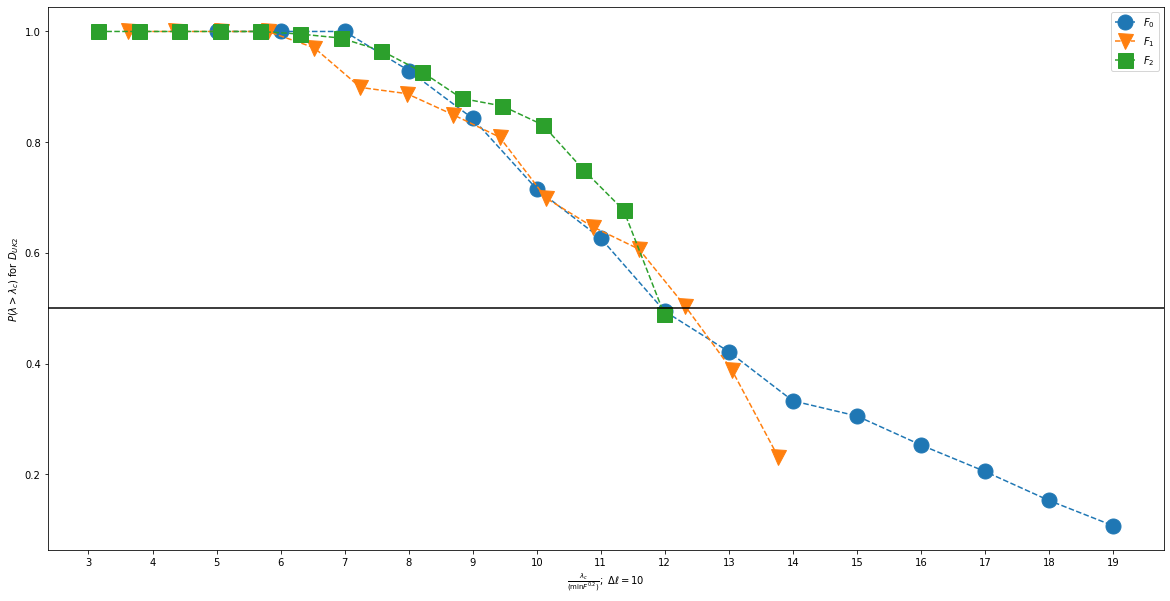

In [40]:
plt.xticks(range(20))
plt.xlabel(r"$\frac{\lambda_{c}}{(\min{F}^{0.2})}; \; \Delta \ell = 10$")
plt.ylabel(r"$P(\lambda > \lambda_c)$ for $D_{UK2}$")
for phi in lcdist.keys():
    plt.plot(lcdist[phi]['uk2'].index / [1, 5**(0.2), 10**(0.2)][phi], lcdist[phi]['uk2'][0], marker=markers[phi], markersize=15, linestyle="--", label=fr"$F_{phi}$")
plt.axhline(0.5, color="black")
plt.legend()

## Comparing the results above

I can compare the results in terms of the overall data for all three cohorts. I.e. Using a series that represents all values of $F$. 

In [41]:
fdist3 = {}
lcdist2 = {}
for c in dff.keys():
    %time fdist3[c] = pc.f_histell(dff[c], 1, [10000], uptoapoint=True)
    lcdist2[c] = {}
    df = fdist3[c][0]
    df['p'] = df[0] / sum(df[0])
    for lc in range(5, 20):
        df2 = df.loc[df.index >= lc]
        lcdist2[c][lc] = sum(df2['p'])
    lcdist2[c] = pd.DataFrame.from_dict(lcdist2[c], orient='index')
    lcdist2[c].sort_index(inplace=True)

CPU times: user 2.71 s, sys: 19 ms, total: 2.73 s
Wall time: 2.73 s
CPU times: user 1.08 s, sys: 10.6 ms, total: 1.09 s
Wall time: 1.08 s
CPU times: user 689 ms, sys: 15.5 ms, total: 705 ms
Wall time: 694 ms


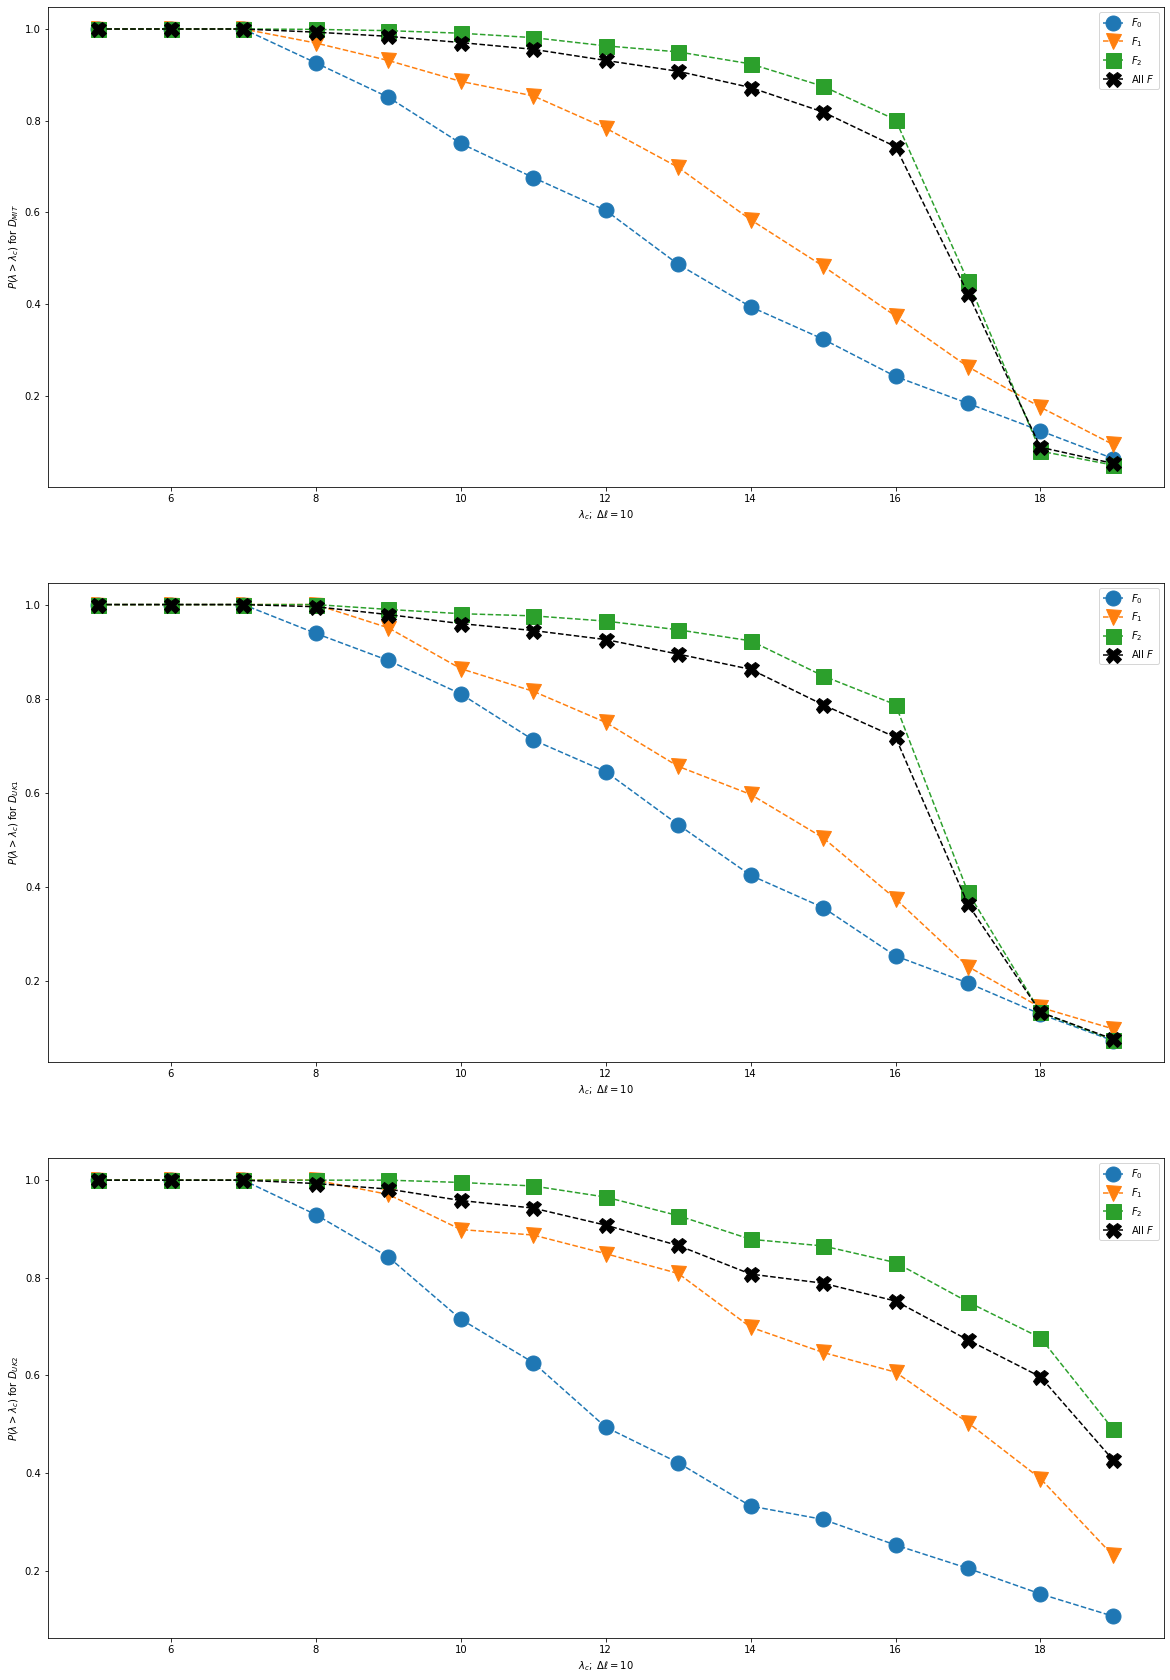

In [42]:
plt.figure(figsize=(20, 30))
p = 1
for c in lcdist2.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"$\lambda_{c}; \; \Delta \ell = 10$")
    plt.ylabel(fr"$P(\lambda > \lambda_c)$ for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    for phi in lcdist.keys():
        plt.plot(lcdist[phi][c].index, lcdist[phi][c][0], marker=markers[phi], markersize=15, linestyle="--", label=fr"$F_{phi}$")
    plt.plot(lcdist2[c].index, lcdist2[c][0], marker="X", markersize=15, color="black", linestyle="--", label=r"All $F$")
    plt.legend()
    p += 1

## Without social core group of size 3

Since alters are limited to have $0 \leq \ell \leq 200$; instead of defining the social core group as the three alters with longest lifetimes, I will use the three alters with the highest activity.

In [43]:
cores = {}
for c in pairs.keys():
    cores[c] = {}
    pairs[c] = pc.pairs(calls[c])
    for ego in pairs[c]['ego'].unique():
        thelist = list(pairs[c].loc[pairs[c]['ego'] == ego].sort_values(by='nij', ascending=True)['alter'])
        cores[c][ego] = thelist[-3:]

In [44]:
callsoc = {}
callsnc = {}
for c in calls.keys():
    callsoc[c] = pd.DataFrame()
    callsnc[c] = pd.DataFrame()
    df = calls[c]
    for ego in df['ego'].unique():
        df2 = df.loc[df['ego'] == ego]
        tmp = df2['alter'].isin(cores[c][ego])
        df3 = df2.loc[tmp]
        callsoc[c] = callsoc[c].append(df3).reset_index(drop=True)
        tmp = ~df2['alter'].isin(cores[c][ego])
        df4 = df2.loc[tmp]
        callsnc[c] = callsnc[c].append(df4).reset_index(drop=True)

In [45]:
for c in calls.keys():
    if len(callsnc[c]) + len(callsoc[c]) == len(calls[c]):
        print('success')
    else:
        print(f'review {c}')

success
success
success


In [46]:
dffoc = {}
dffnc = {}
for c in calls.keys():
    %time dffoc[c] = pc.get_f(callsoc[c], 'all', 70, 10)
    %time dffnc[c] = pc.get_f(callsnc[c], 'all', 70, 10)

/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 1.2 s, sys: 5.71 ms, total: 1.21 s
Wall time: 1.21 s
CPU times: user 13.8 s, sys: 136 ms, total: 13.9 s
Wall time: 14 s
CPU times: user 275 ms, sys: 7.05 ms, total: 282 ms
Wall time: 288 ms
CPU times: user 5.91 s, sys: 59.2 ms, total: 5.96 s
Wall time: 6.05 s
CPU times: user 270 ms, sys: 7.01 ms, total: 277 ms
Wall time: 280 ms
CPU times: user 3.83 s, sys: 41.4 ms, total: 3.87 s
Wall time: 3.92 s


In [47]:
for c in calls.keys():
    if list(dffoc[c].keys()) == list(dffnc[c].keys()):
        print('success')
    else:
        print(f'review {c}')

review mit
success
success


In [48]:
lcdistoc = {}
lcdistnc = {}
for c in dffoc.keys():
    fdistoc = pc.f_histell(dffoc[c], 1, [10000], uptoapoint=True)
    fdistnc = pc.f_histell(dffnc[c], 1, [10000], uptoapoint=True)
    lcdistoc[c] = {}
    lcdistnc[c] = {}
    dfoc = fdistoc[0]
    dfnc = fdistnc[0]
    dfoc['p'] = dfoc[0] / sum(dfoc[0])
    dfnc['p'] = dfnc[0] / sum(dfnc[0])
    for lc in range(5, 20):
        dfoc2 = dfoc.loc[dfoc.index >= lc]
        dfnc2 = dfnc.loc[dfnc.index >= lc]
        lcdistoc[c][lc] = sum(dfoc2['p'])
        lcdistnc[c][lc] = sum(dfnc2['p'])
    lcdistoc[c] = pd.DataFrame.from_dict(lcdistoc[c], orient='index')
    lcdistoc[c].sort_index(inplace=True)
    lcdistnc[c] = pd.DataFrame.from_dict(lcdistnc[c], orient='index')
    lcdistnc[c].sort_index(inplace=True)

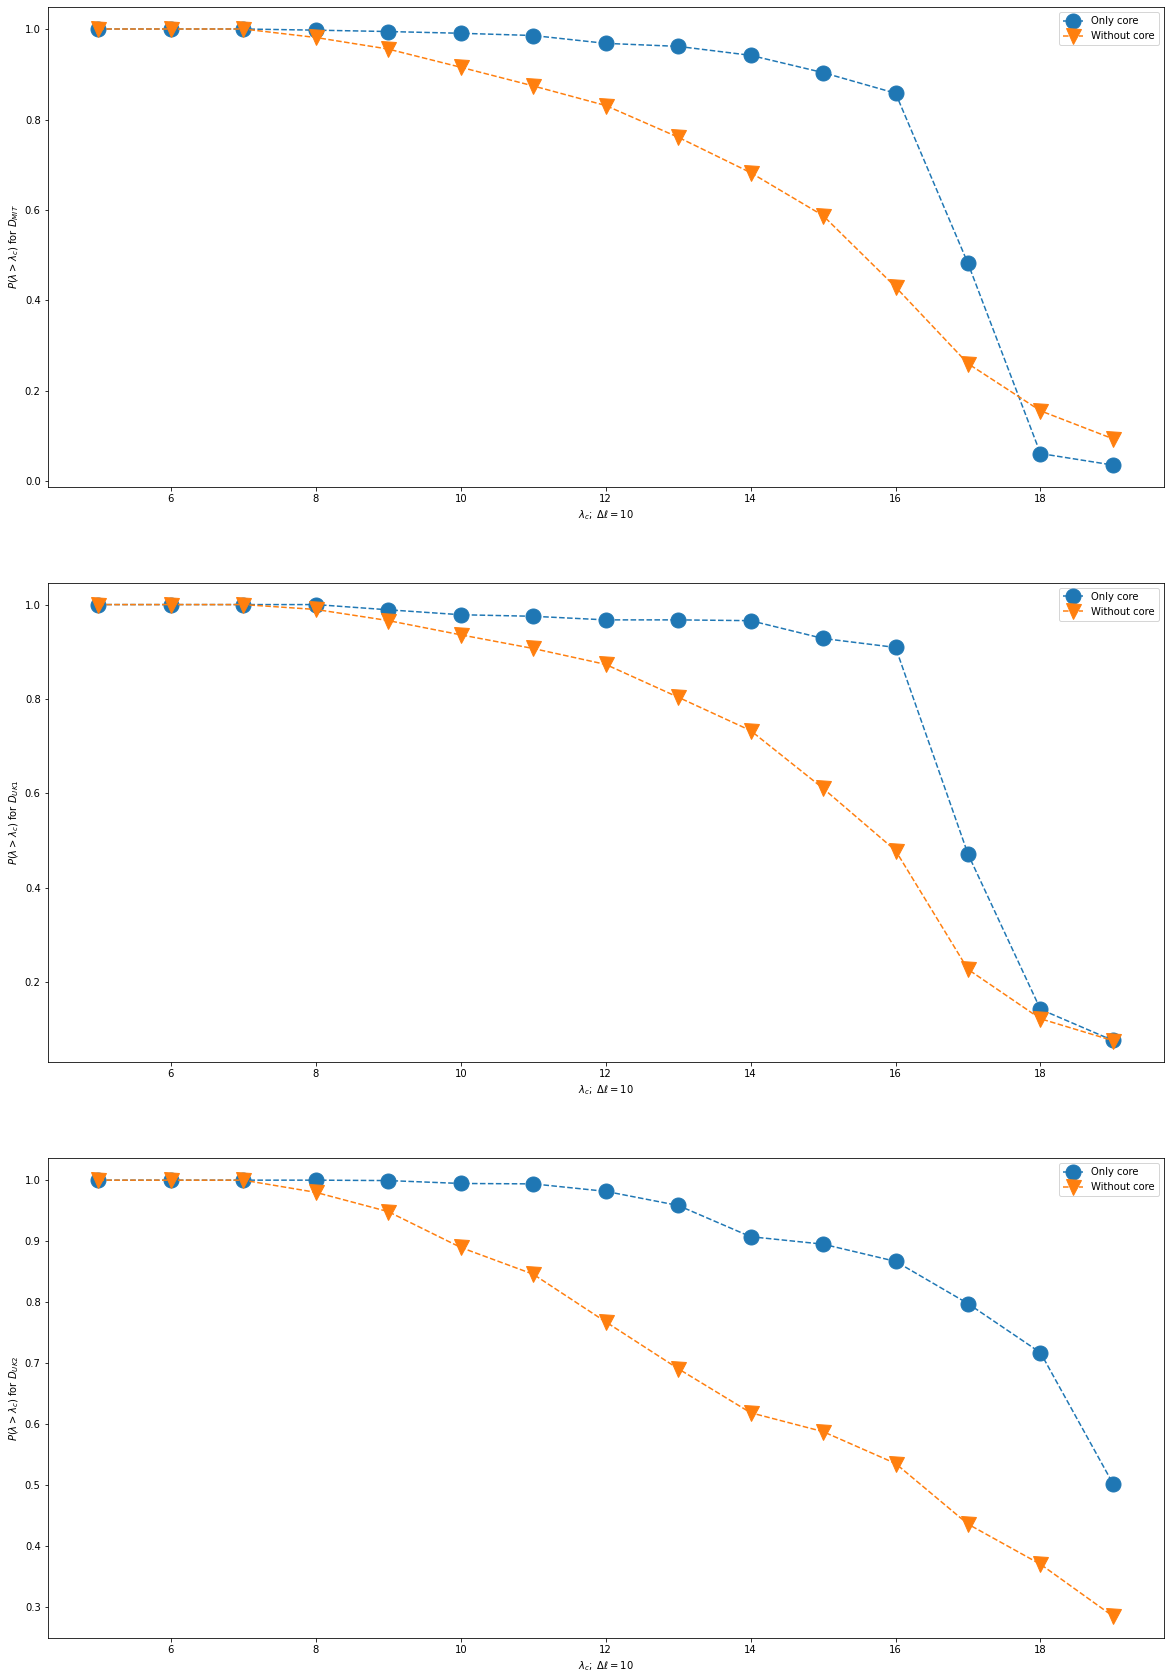

In [49]:
plt.figure(figsize=(20, 30))
p = 1
for c in lcdistoc.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"$\lambda_{c}; \; \Delta \ell = 10$")
    plt.ylabel(fr"$P(\lambda > \lambda_c)$ for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    plt.plot(lcdistoc[c].index, lcdistoc[c][0], marker=markers[0], markersize=15, linestyle="--", label=r"Only core")
    plt.plot(lcdistnc[c].index, lcdistnc[c][0], marker=markers[1], markersize=15, linestyle="--", label=r"Without core")
    plt.legend()
    p += 1

# Collapsing curves of non-core alters

For this section I will only use the curves for non-core alters and collapse curves of $\phi$, using $\Delta F = 3$. The reason to only use the non-core alters is that the shep of the curve is going to be similar to $F > 10$.

In [50]:
lcdistnc = {}
for c in dffnc.keys():
    fdistnc = pc.f_histell(dffnc[c], 1, [], binned=True, deltaF=3)
    lcdistnc[c] = {}
    for phi in [0, 1, 2, 3]:
        lcdistnc[c][phi] = {}
        dfnc = fdistnc[phi]
        dfnc['p'] = dfnc[0] / sum(dfnc[0])
        for lc in range(5, 20):
            dfnc2 = dfnc.loc[dfnc.index >= lc]
            lcdistnc[c][phi][lc] = sum(dfnc2['p'])
        lcdistnc[c][phi] = pd.DataFrame.from_dict(lcdistnc[c][phi], orient='index')
        lcdistnc[c][phi].sort_index(inplace=True)

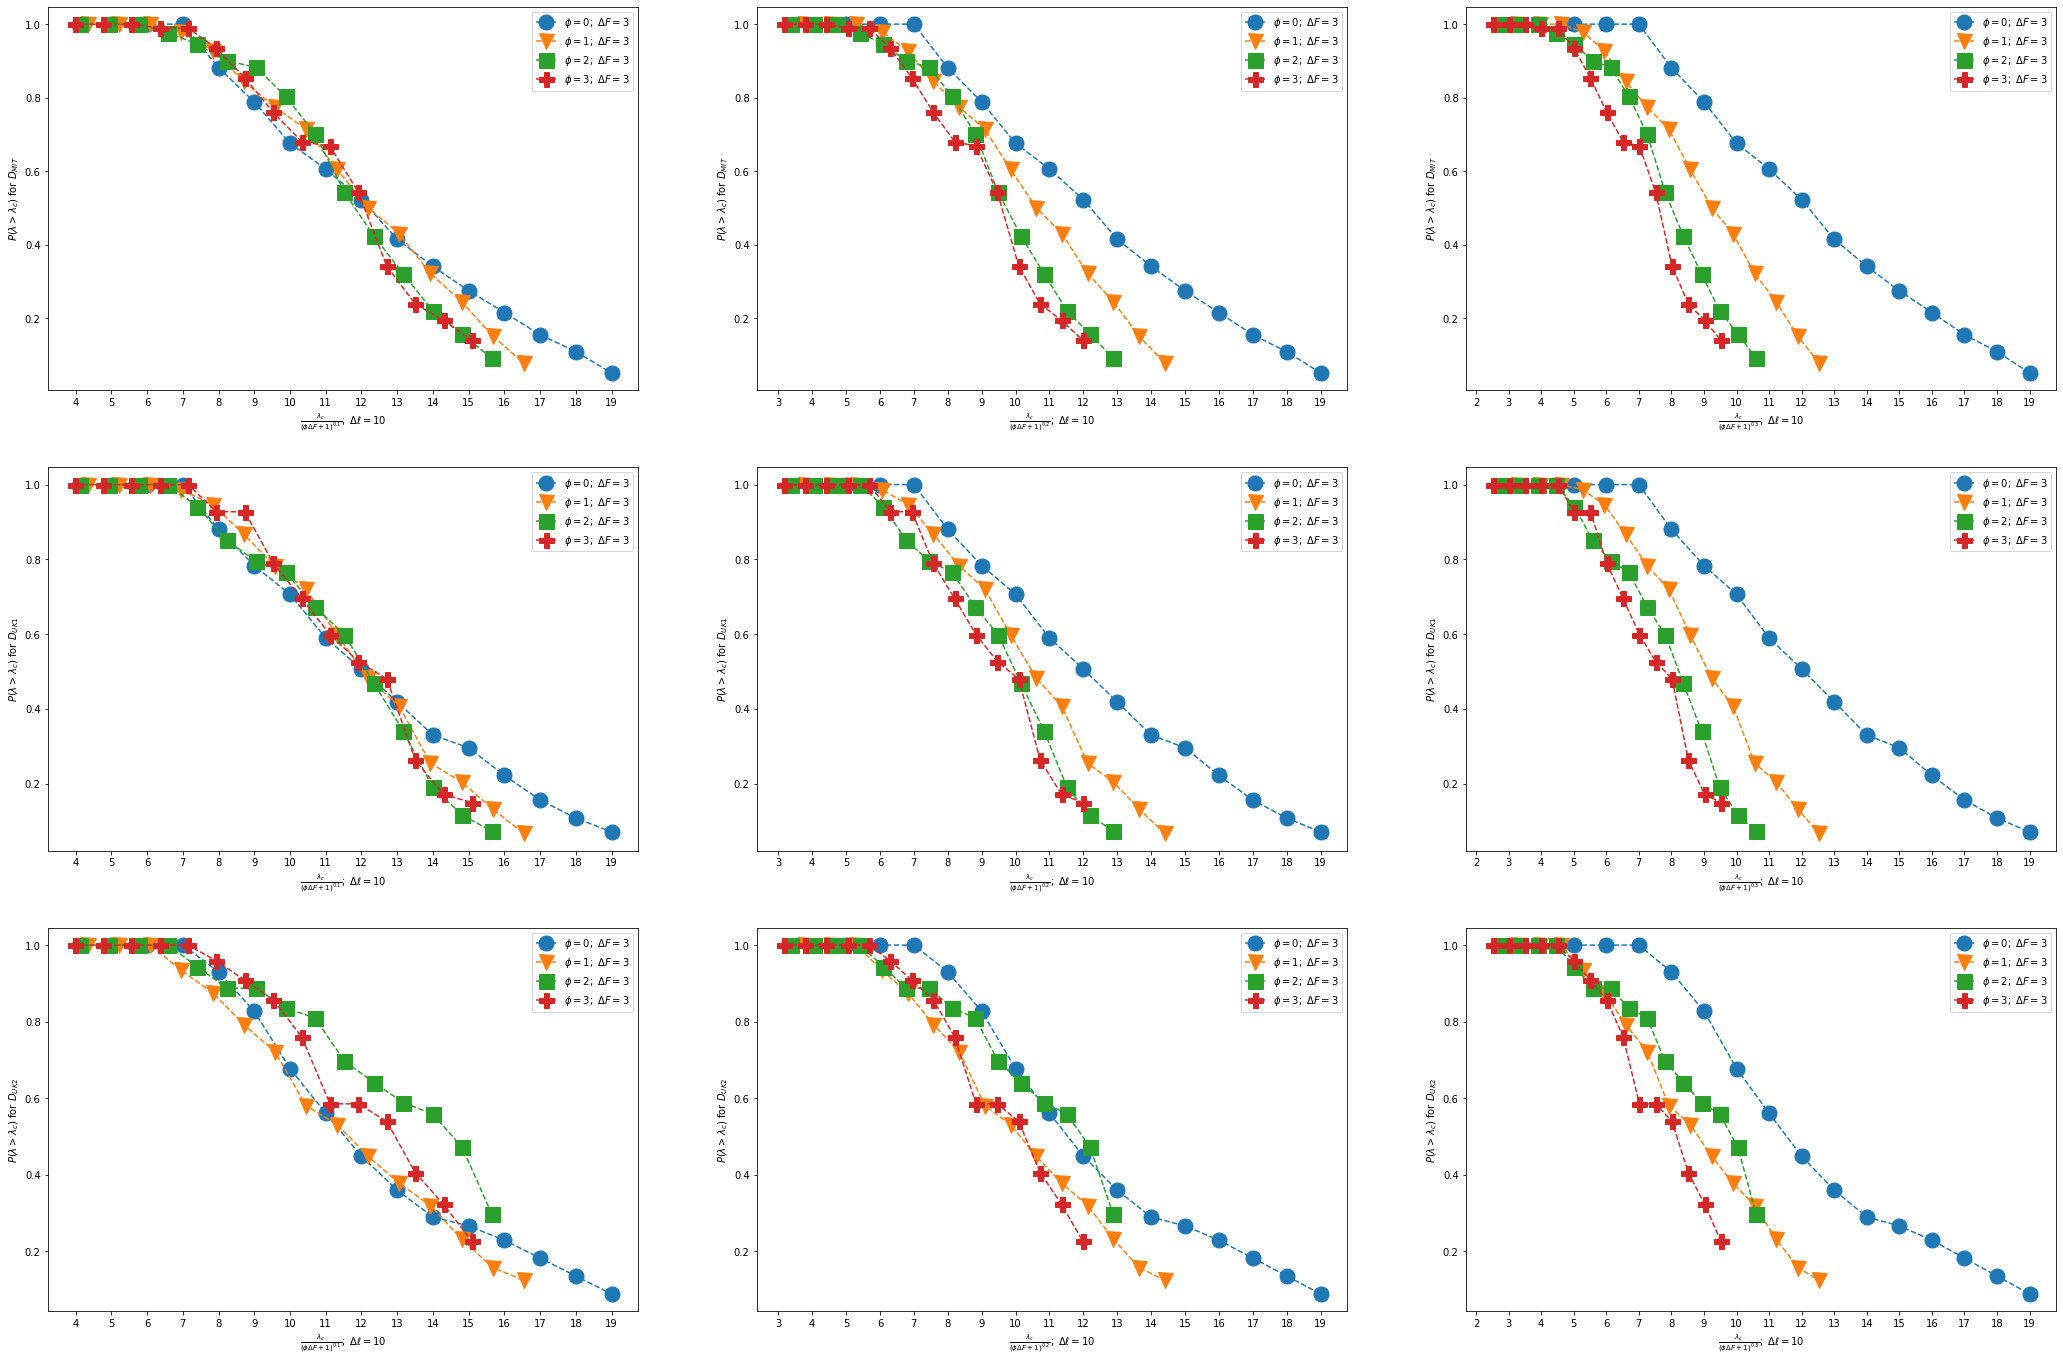

In [51]:
plt.figure(figsize=(36, 24))
p = 1
c = ['mit', 'uk1', 'uk2']
while p < 10:
    plt.subplot(3, 3, p)
    plt.xticks(range(20))
    if (p - 1) % 3 == 0:
        plt.xlabel(r"$\frac{\lambda_{c}}{(\phi\Delta F + 1)^{0.1}}; \; \Delta \ell = 10$")
    elif (p - 1) % 3 == 1:
        plt.xlabel(r"$\frac{\lambda_{c}}{(\phi\Delta F + 1)^{0.2}}; \; \Delta \ell = 10$")
    else:
        plt.xlabel(r"$\frac{\lambda_{c}}{(\phi\Delta F + 1)^{0.3}}; \; \Delta \ell = 10$")
    plt.ylabel(fr"$P(\lambda > \lambda_c)$ for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][(p - 1) // 3]}$")
    m = 0
    for phi in lcdistnc[c[(p - 1) // 3]].keys():
        if (p - 1) % 3 == 0:
            plt.plot(lcdistnc[c[(p - 1) // 3]][phi].index / ((phi * 3) + 1)**(0.1), lcdistnc[c[(p - 1) // 3]][phi][0], marker=markers[m], markersize=15, linestyle="--", label=fr"$\phi = {phi}; \; \Delta F = 3$")
        elif (p - 1) % 3 == 1:
            plt.plot(lcdistnc[c[(p - 1) // 3]][phi].index / ((phi * 3) + 1)**(0.2), lcdistnc[c[(p - 1) // 3]][phi][0], marker=markers[m], markersize=15, linestyle="--", label=fr"$\phi = {phi}; \; \Delta F = 3$")
        else:
            plt.plot(lcdistnc[c[(p - 1) // 3]][phi].index / ((phi * 3) + 1)**(0.3), lcdistnc[c[(p - 1) // 3]][phi][0], marker=markers[m], markersize=15, linestyle="--", label=fr"$\phi = {phi}; \; \Delta F = 3$")
        m += 1
    plt.legend()
    p += 1

Using different scaling

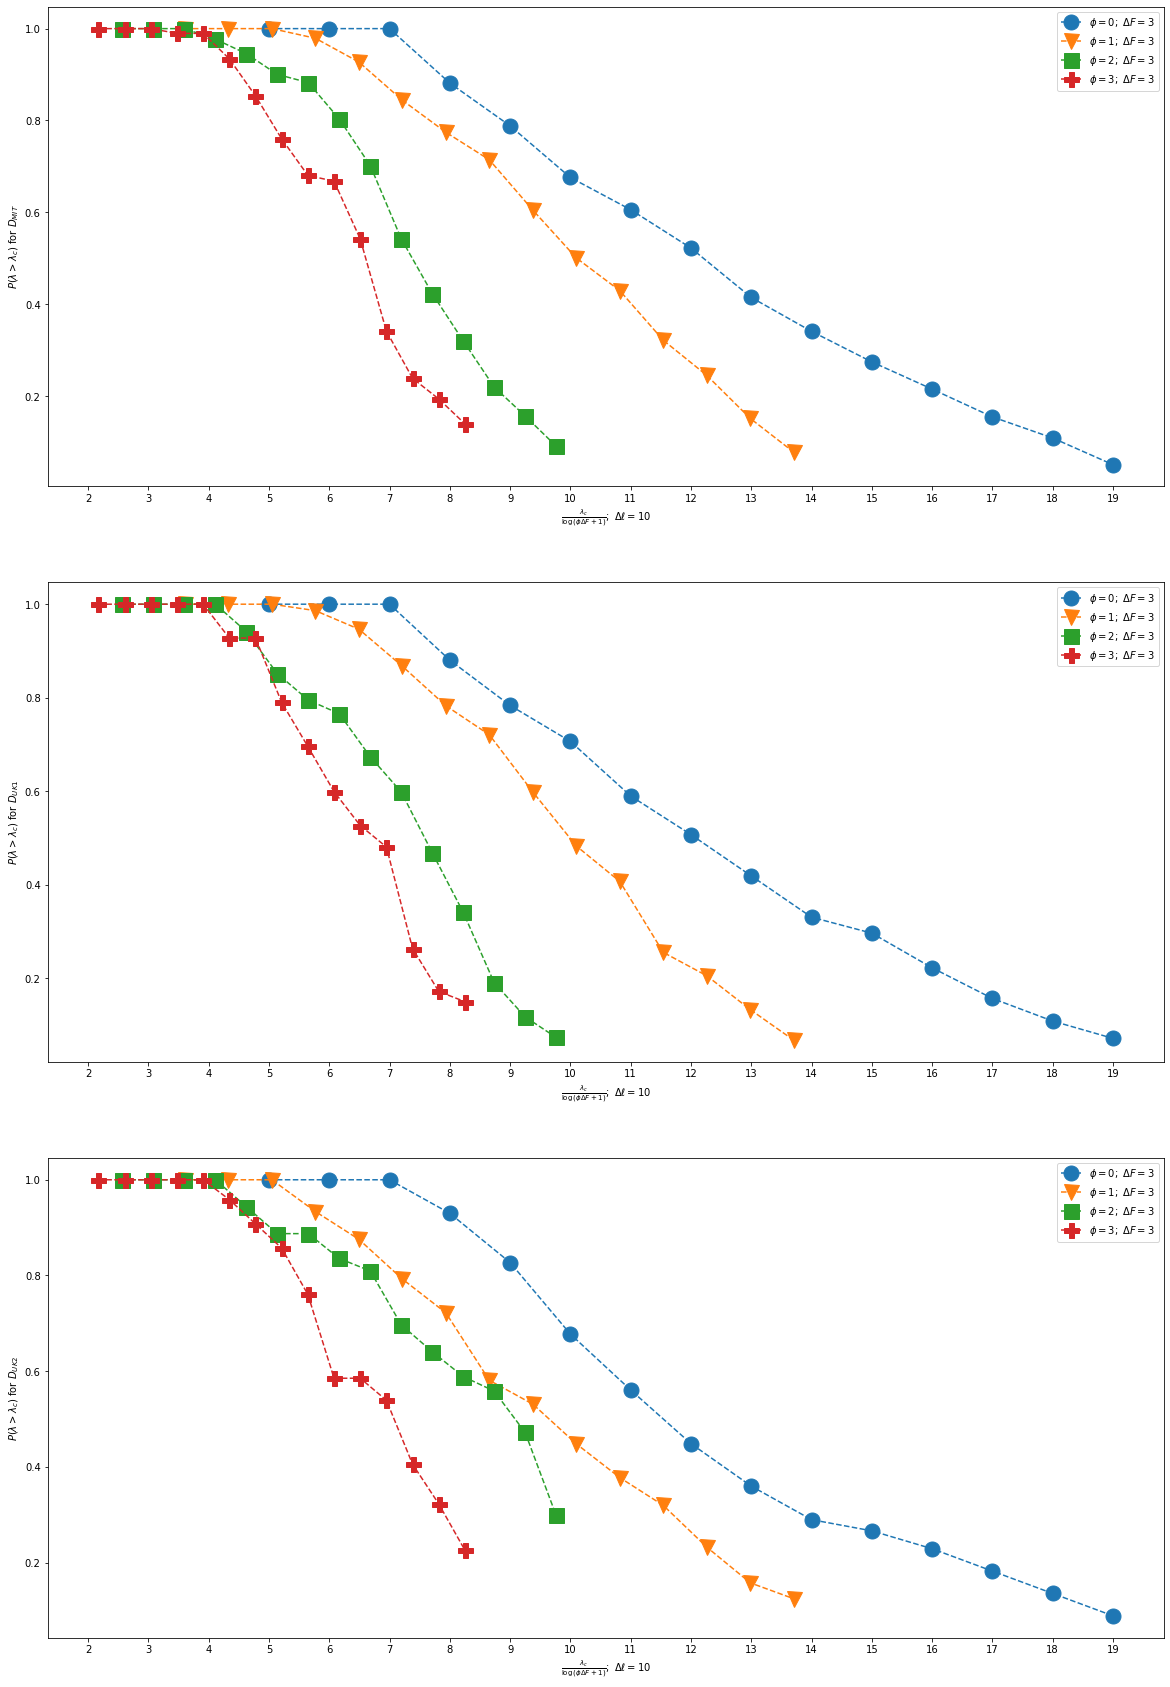

In [52]:
plt.figure(figsize=(20, 30))
p = 1
for c in lcdistnc.keys():
    plt.subplot(3, 1, p)
    plt.xticks(range(20))
    plt.xlabel(r"$\frac{\lambda_{c}}{\log{(\phi\Delta F + 1)}}; \; \Delta \ell = 10$")
    plt.ylabel(fr"$P(\lambda > \lambda_c)$ for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    m = 0
    for phi in lcdistnc[c].keys():
        if phi > 0:
            plt.plot(lcdistnc[c][phi].index / np.log(phi * 3 + 1), lcdistnc[c][phi][0], marker=markers[m], markersize=15, linestyle="--", label=fr"$\phi = {phi}; \; \Delta F = 3$")
        else:
            plt.plot(lcdistnc[c][phi].index / 1, lcdistnc[c][phi][0], marker=markers[m], markersize=15, linestyle="--", label=fr"$\phi = {phi}; \; \Delta F = 3$")
        m += 1
    plt.legend()
    p += 1

# Survival curves

For this version, I will create the same survival curves, but using more values for $F$. Remember that I will use **only** the non-core alters

In [53]:
pairsnc = {}
livesnc = {}
for c in callsnc.keys():
    pairsnc[c] = pc.pairs(callsnc[c])
    livesnc[c] = pc.lives_dictionary(callsnc[c])

In [54]:
def get_survival(fresult, alphafixed, lcrange, deltaf):
    result = {}
    fdist = pc.f_histell(fresult, alphafixed, [], binned=True, deltaF=deltaf)
    for phi in fdist.keys():
        result[phi] = {}
        df = fdist[phi]
        df['p'] = df[0] / sum(df[0])
        for lc in lcrange:
            df2 = df.loc[df.index >= lc]
            result[phi][lc] = sum(df2['p'])
        result[phi] = pd.DataFrame.from_dict(result[phi], orient='index')
        result[phi].sort_index(inplace=True)
    return result

In [55]:
dffnc = {}
survivalnc = {}
for c in callsnc.keys():
    %time dffnc[c] = pc.get_f(callsnc[c], 'all', 30, 10)
    %time survivalnc[c] = get_survival(dffnc[c], 1, range(21), 9)

/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 15 s, sys: 186 ms, total: 15.2 s
Wall time: 15.8 s
CPU times: user 7.5 s, sys: 104 ms, total: 7.6 s
Wall time: 7.65 s


/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 6.35 s, sys: 63.6 ms, total: 6.41 s
Wall time: 6.47 s
CPU times: user 3.1 s, sys: 54.5 ms, total: 3.16 s
Wall time: 3.2 s


/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 3.56 s, sys: 29.2 ms, total: 3.59 s
Wall time: 3.6 s
CPU times: user 1.76 s, sys: 85.5 ms, total: 1.85 s
Wall time: 1.78 s


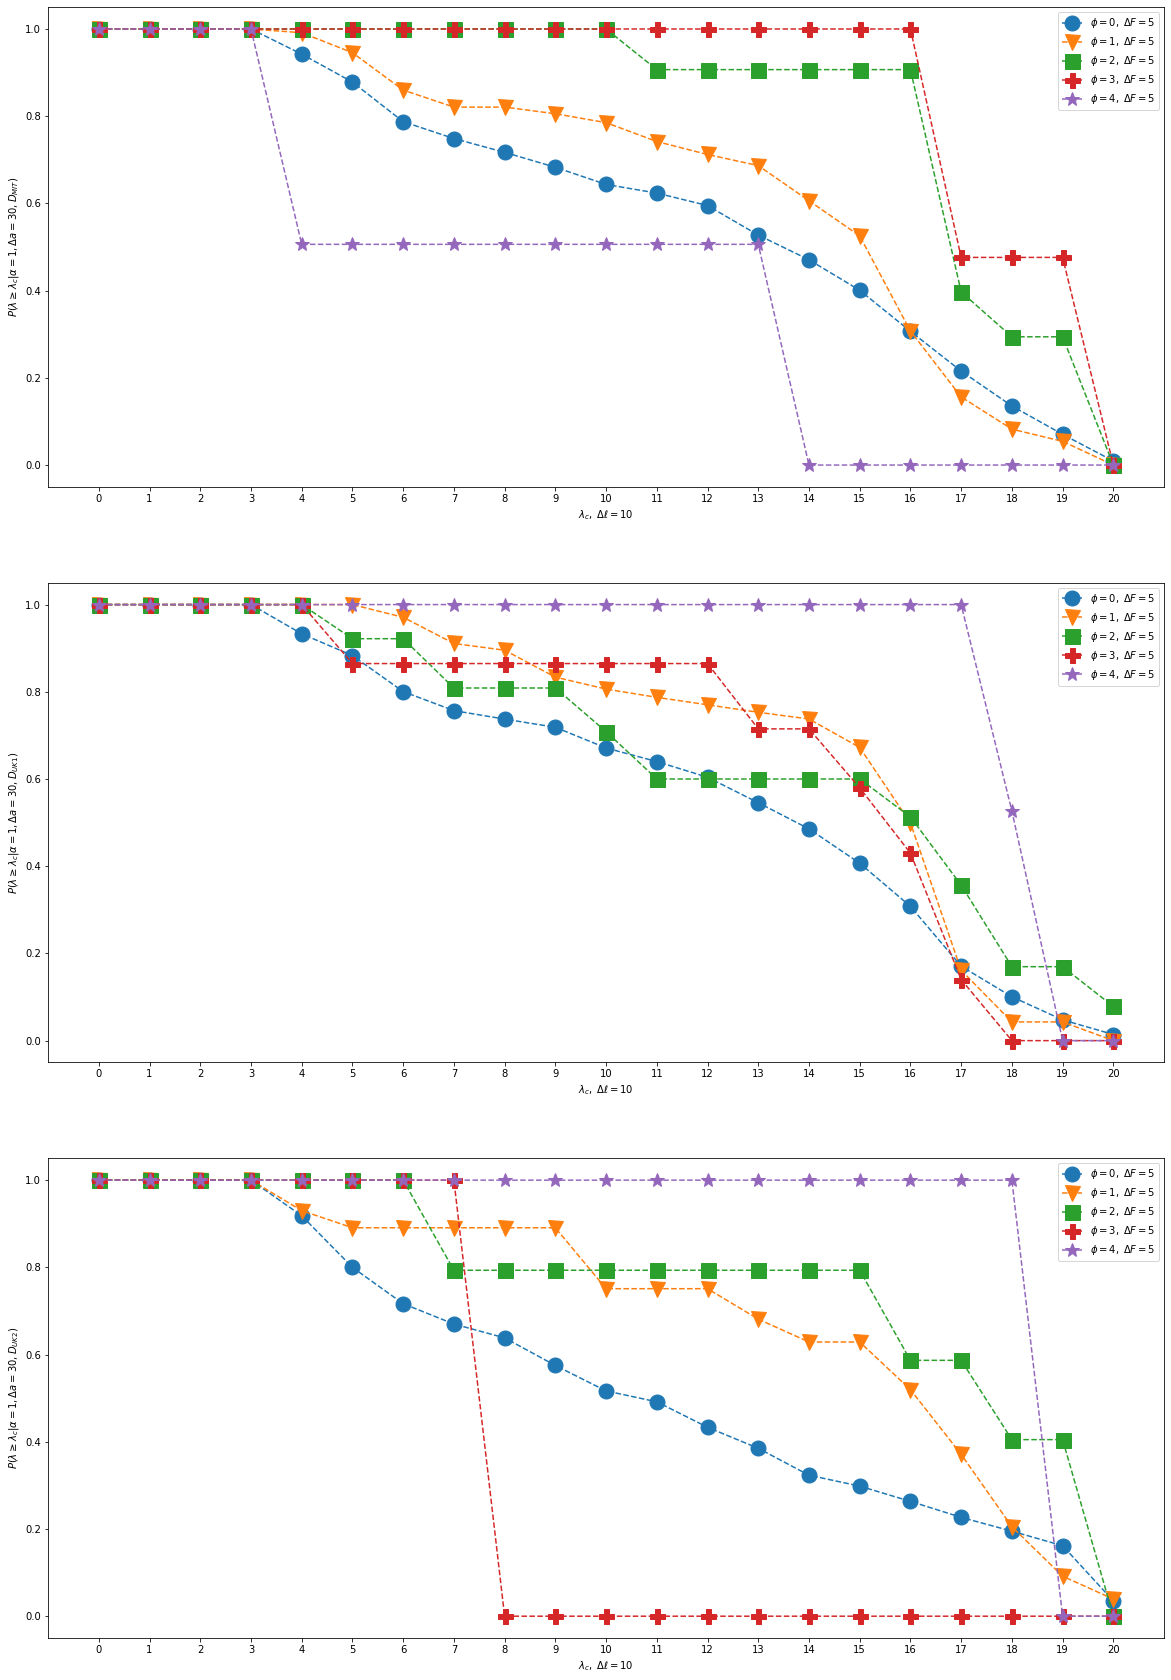

In [56]:
plt.figure(figsize=(20, 30))
p = 1
for c in survivalnc.keys():
    plt.subplot(3, 1, p)
    plt.ylabel(fr"$P(\lambda \geq \lambda_c | \alpha = 1, \Delta a = 30, {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]})$")
    plt.xlabel(fr"$\lambda_c, \; \Delta \ell = 10$")
    plt.xticks(range(21))
    for phi in range(5):
        plt.plot(survivalnc[c][phi].index, survivalnc[c][phi][0], marker=markers[phi], markersize=15, linestyle="--", label=fr"$\phi = {phi}, \; \Delta F = 5$")
    plt.legend()
    p += 1

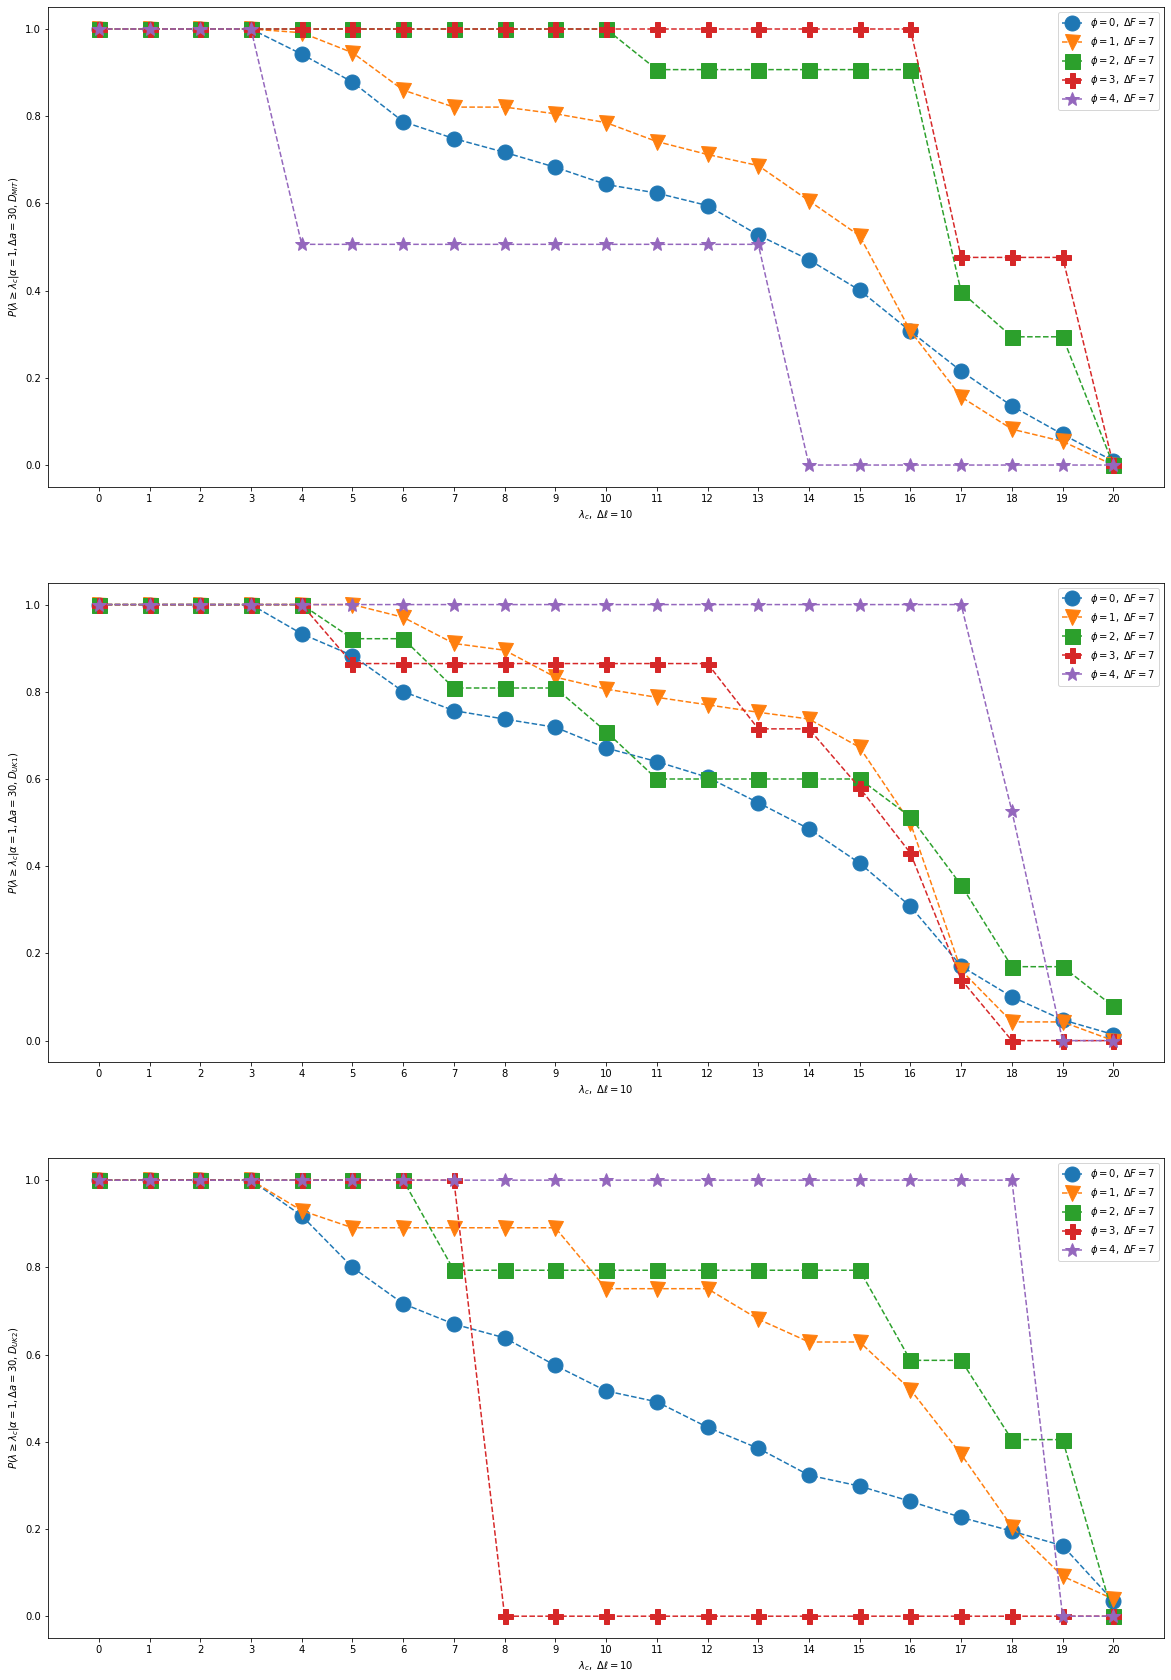

In [57]:
plt.figure(figsize=(20, 30))
p = 1
for c in survivalnc.keys():
    plt.subplot(3, 1, p)
    plt.ylabel(fr"$P(\lambda \geq \lambda_c | \alpha = 1, \Delta a = 30, {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]})$")
    plt.xlabel(fr"$\lambda_c, \; \Delta \ell = 10$")
    plt.xticks(range(21))
    for phi in range(5):
        plt.plot(survivalnc[c][phi].index, survivalnc[c][phi][0], marker=markers[phi], markersize=15, linestyle="--", label=fr"$\phi = {phi}, \; \Delta F = 7$")
    plt.legend()
    p += 1

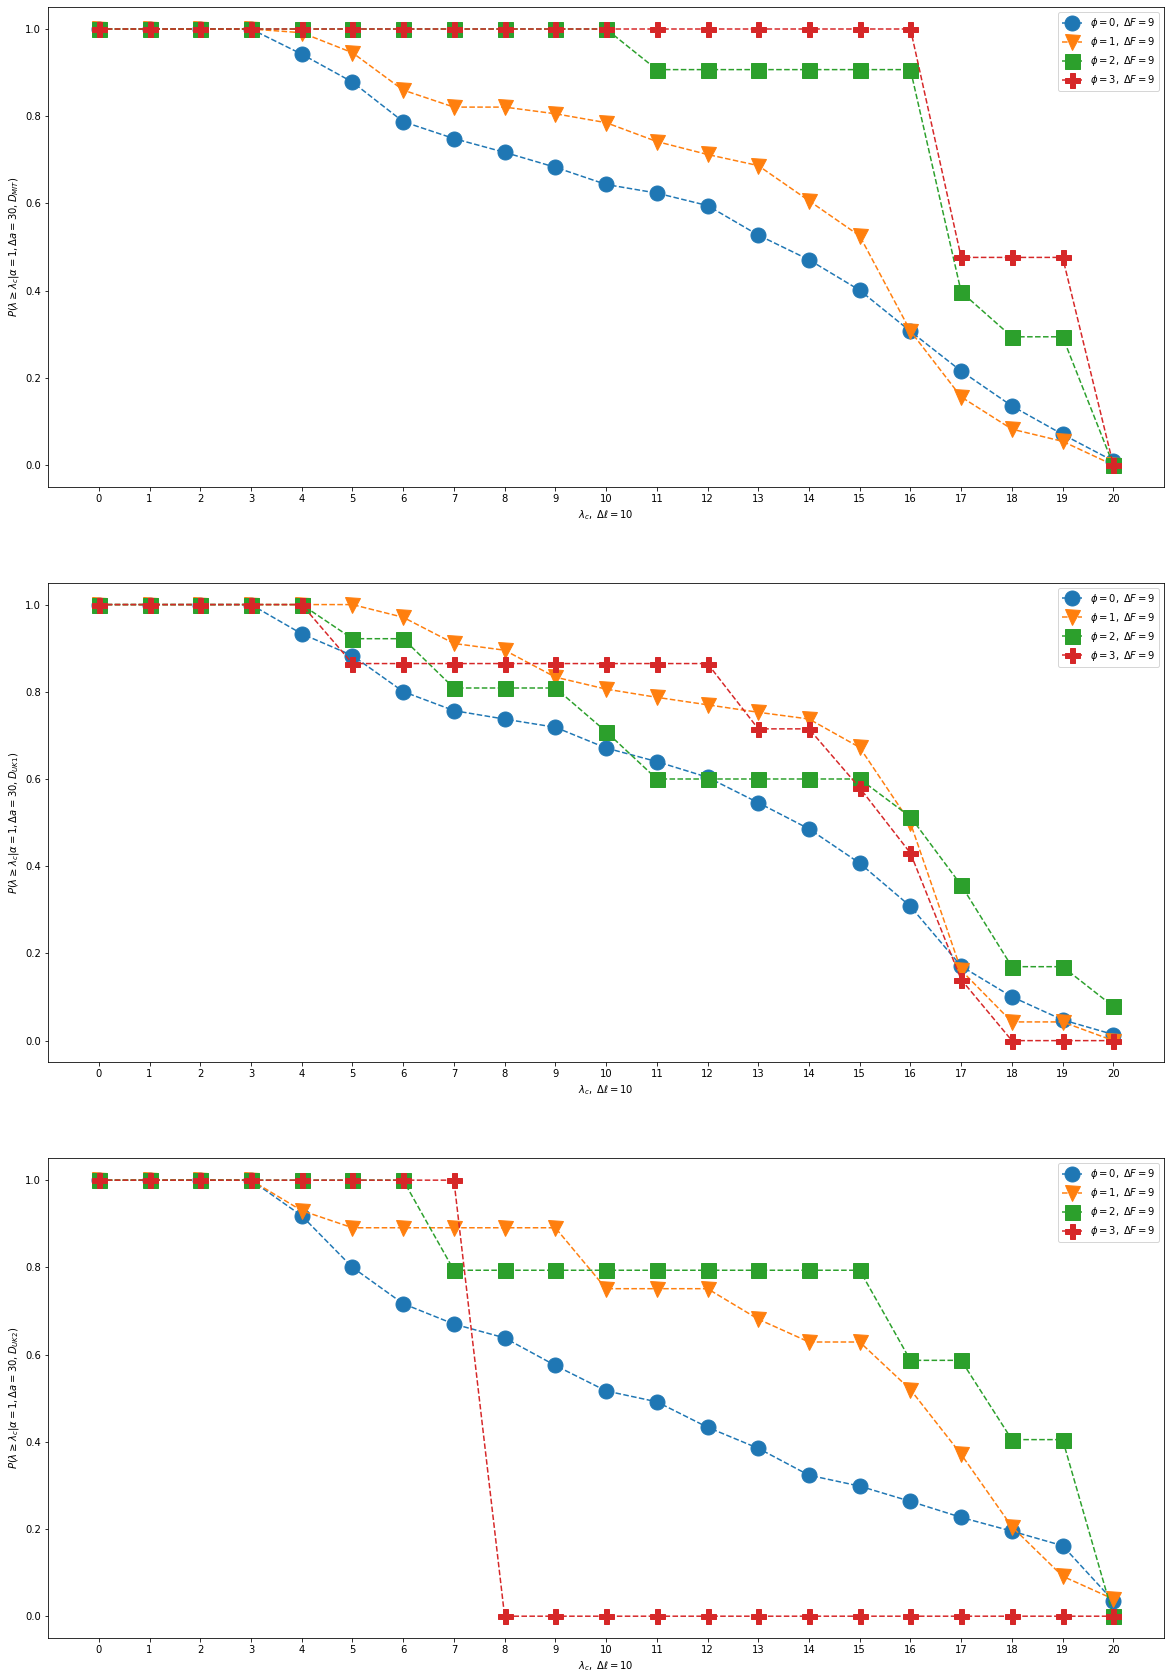

In [58]:
plt.figure(figsize=(20, 30))
p = 1
for c in survivalnc.keys():
    plt.subplot(3, 1, p)
    plt.ylabel(fr"$P(\lambda \geq \lambda_c | \alpha = 1, \Delta a = 30, {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]})$")
    plt.xlabel(fr"$\lambda_c, \; \Delta \ell = 10$")
    plt.xticks(range(21))
    for phi in range(4):
        plt.plot(survivalnc[c][phi].index, survivalnc[c][phi][0], marker=markers[phi], markersize=15, linestyle="--", label=fr"$\phi = {phi}, \; \Delta F = 9$")
    plt.legend()
    p += 1

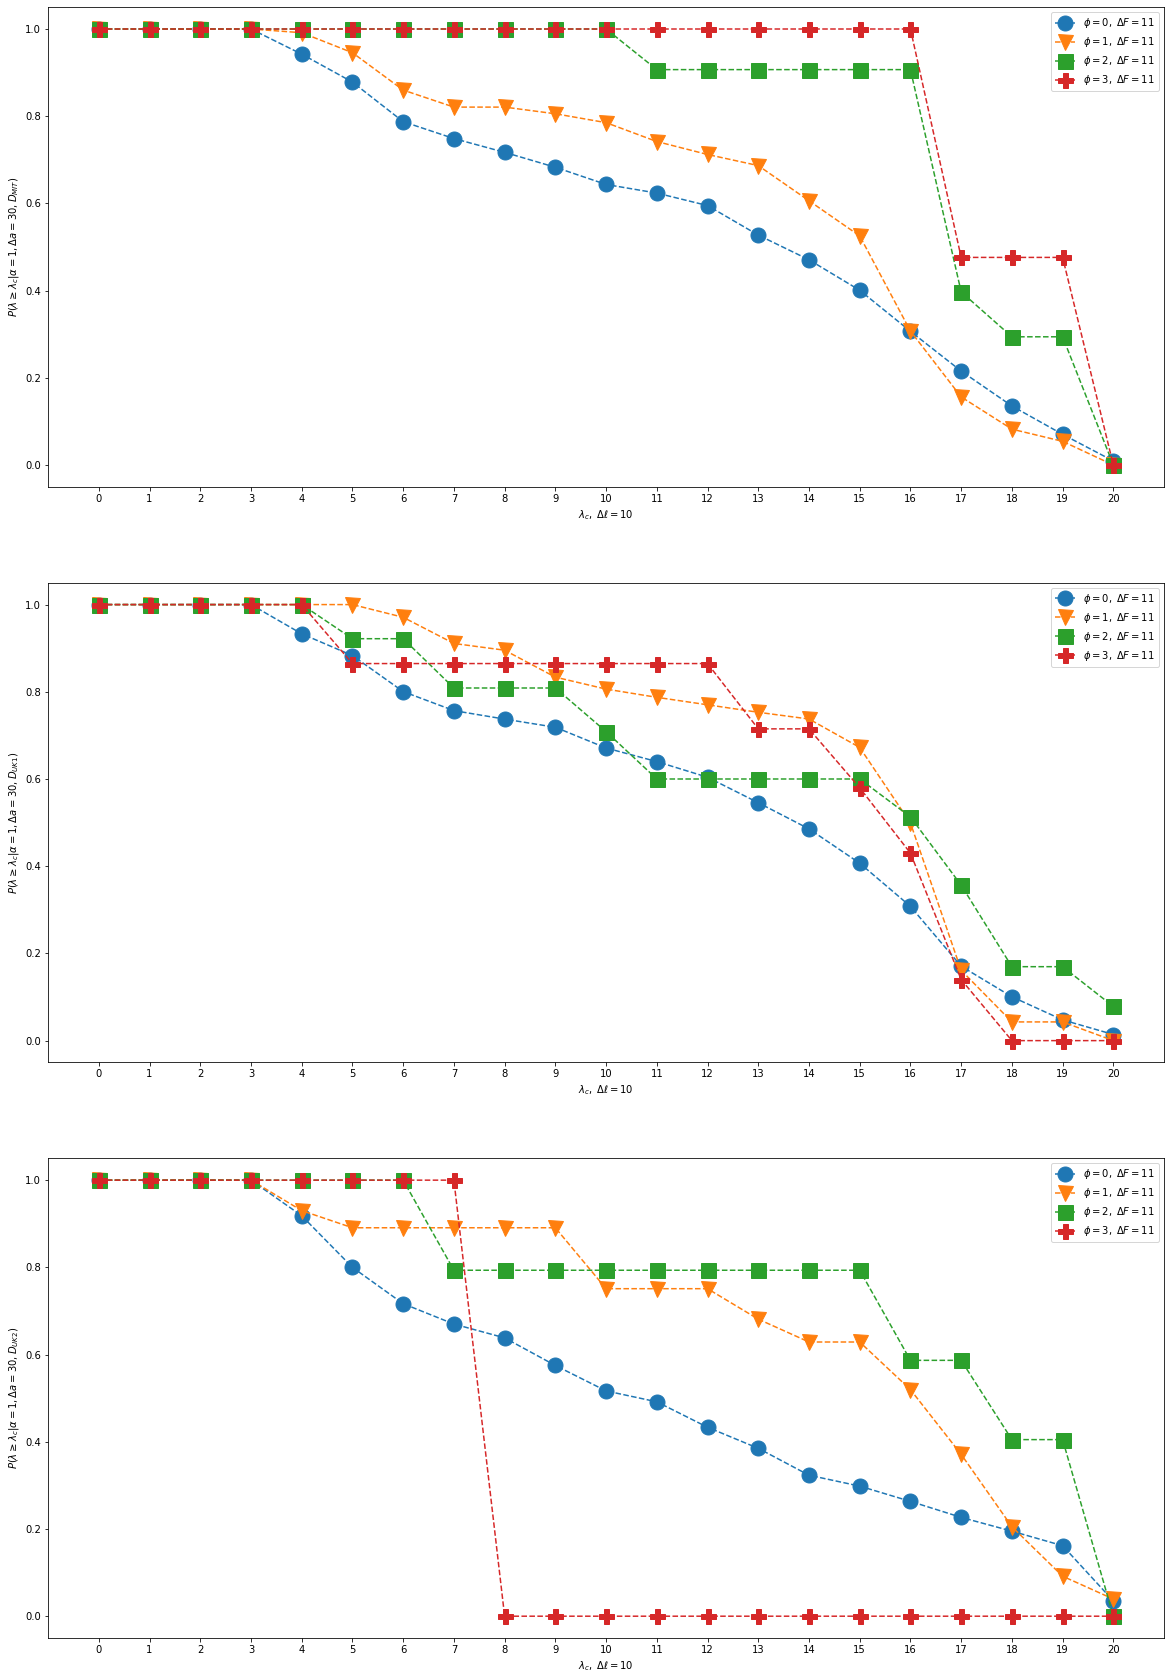

In [59]:
plt.figure(figsize=(20, 30))
p = 1
for c in survivalnc.keys():
    plt.subplot(3, 1, p)
    plt.ylabel(fr"$P(\lambda \geq \lambda_c | \alpha = 1, \Delta a = 30, {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]})$")
    plt.xlabel(fr"$\lambda_c, \; \Delta \ell = 10$")
    plt.xticks(range(21))
    for phi in range(4):
        plt.plot(survivalnc[c][phi].index, survivalnc[c][phi][0], marker=markers[phi], markersize=15, linestyle="--", label=fr"$\phi = {phi}, \; \Delta F = 11$")
    plt.legend()
    p += 1

## Use bins of $F$ of different sizes

In [60]:
def get_survival2(fresult, alphafixed, lcrange):
    result = {}
    fdist = pc.f_histell(fresult, alphafixed, [3, 9, 27, 1000])
    for phi in fdist.keys():
        result[phi] = {}
        df = fdist[phi]
        df['p'] = df[0] / sum(df[0])
        for lc in lcrange:
            df2 = df.loc[df.index >= lc]
            result[phi][lc] = sum(df2['p'])
        result[phi] = pd.DataFrame.from_dict(result[phi], orient='index')
        result[phi].sort_index(inplace=True)
    return result

In [61]:
survivalnc2 = {}
for c in callsnc.keys():
    dffnc = pc.get_f(callsnc[c], 'all', 30, 10)
    %time survivalnc2[c] = get_survival2(dffnc, 1, range(21))

/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 4.93 s, sys: 25.6 ms, total: 4.96 s
Wall time: 4.97 s


/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 2.33 s, sys: 19.9 ms, total: 2.35 s
Wall time: 2.37 s


/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 1.24 s, sys: 8.06 ms, total: 1.25 s
Wall time: 1.26 s


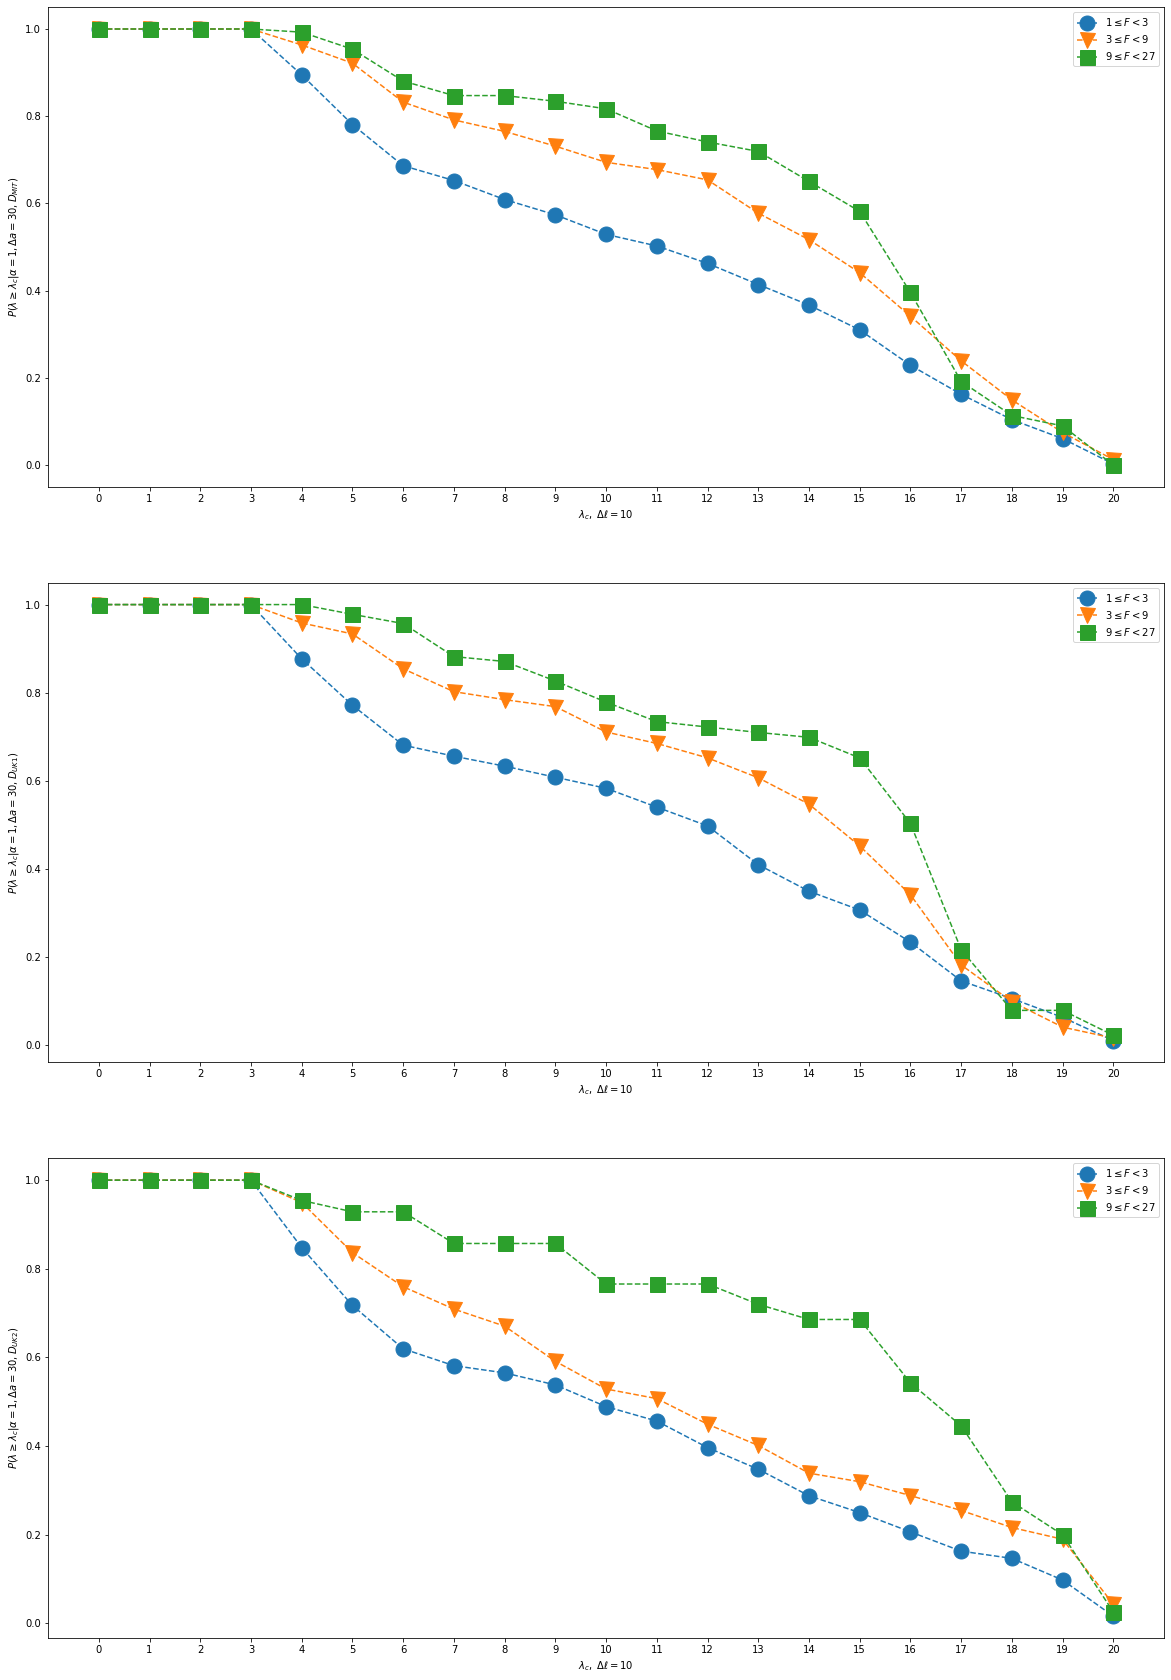

In [62]:
plt.figure(figsize=(20, 30))
p = 1
legends = [fr'${3**i} \leq F < {3**(i + 1)}$' for i in range(3)]
for c in survivalnc2.keys():
    plt.subplot(3, 1, p)
    plt.ylabel(fr"$P(\lambda \geq \lambda_c | \alpha = 1, \Delta a = 30, {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]})$")
    plt.xlabel(fr"$\lambda_c, \; \Delta \ell = 10$")
    plt.xticks(range(21))
    for phi in range(3):
        plt.plot(survivalnc2[c][phi].index, survivalnc2[c][phi][0], marker=markers[phi], markersize=15, linestyle="--", label=legends[phi])
    plt.legend()
    p += 1

In [63]:
def get_survival4(fresult, alphafixed, lcrange):
    result = {}
    fdist = pc.f_histell(fresult, alphafixed, [4, 16, 64, 1000])
    for phi in fdist.keys():
        result[phi] = {}
        df = fdist[phi]
        df['p'] = df[0] / sum(df[0])
        for lc in lcrange:
            df2 = df.loc[df.index >= lc]
            result[phi][lc] = sum(df2['p'])
        result[phi] = pd.DataFrame.from_dict(result[phi], orient='index')
        result[phi].sort_index(inplace=True)
    return result

In [64]:
survivalnc4 = {}
for c in callsnc.keys():
    dffnc = pc.get_f(callsnc[c], 'all', 30, 10)
    %time survivalnc4[c] = get_survival4(dffnc, 1, range(21))

/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 4.66 s, sys: 19.3 ms, total: 4.68 s
Wall time: 4.67 s


/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 2.09 s, sys: 5 ms, total: 2.09 s
Wall time: 2.09 s


/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 1.16 s, sys: 3.28 ms, total: 1.17 s
Wall time: 1.17 s


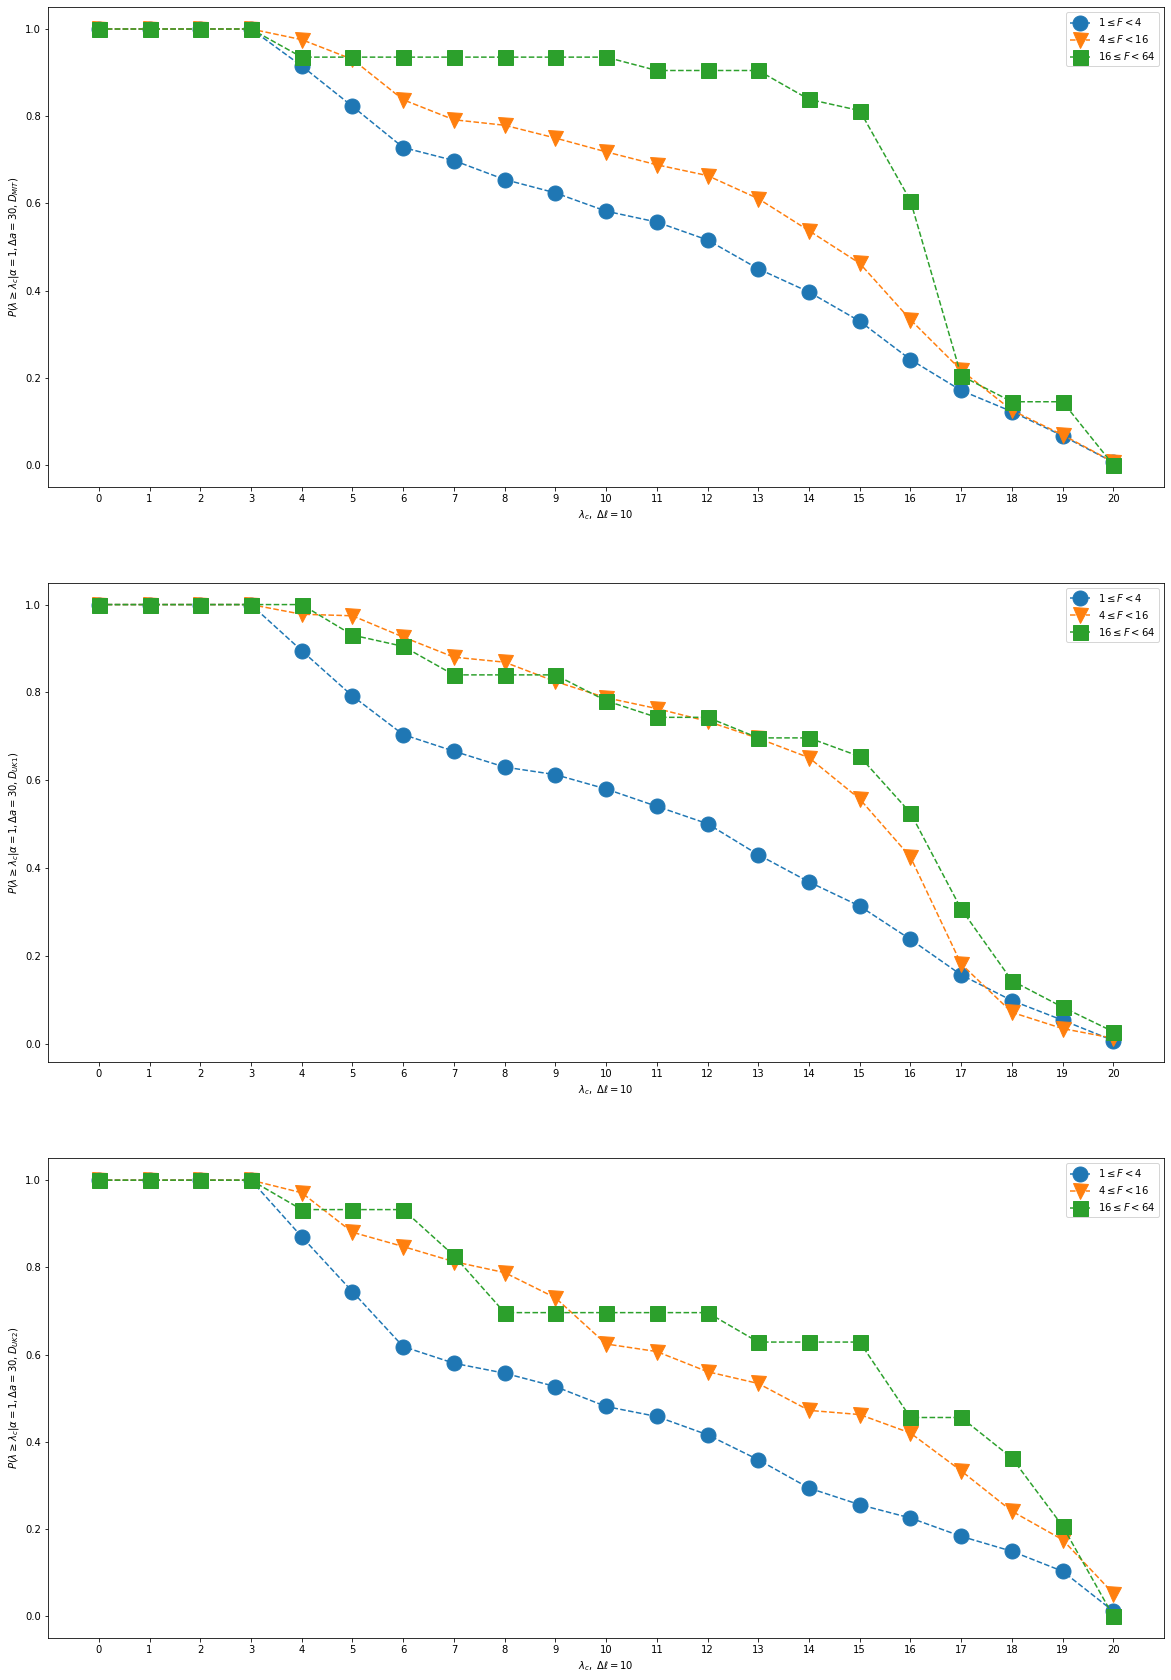

In [65]:
plt.figure(figsize=(20, 30))
p = 1
legends = [fr'${4**i} \leq F < {4**(i + 1)}$' for i in range(3)]
for c in survivalnc4.keys():
    plt.subplot(3, 1, p)
    plt.ylabel(fr"$P(\lambda \geq \lambda_c | \alpha = 1, \Delta a = 30, {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]})$")
    plt.xlabel(fr"$\lambda_c, \; \Delta \ell = 10$")
    plt.xticks(range(21))
    for phi in range(3):
        plt.plot(survivalnc4[c][phi].index, survivalnc4[c][phi][0], marker=markers[phi], markersize=15, linestyle="--", label=legends[phi])
    plt.legend()
    p += 1

## Smoothing the survival curves

I will start by trying splines. Just as a test, I will use $D_{MIT}$ with $\phi > 4$ just to visualize them

In [66]:
splines = {}
for phi in survivalnc['mit'].keys():
    x = list(survivalnc['mit'][phi].index)
    xmin = min(x)
    xmax = max(x)
    y = list(survivalnc['mit'][phi][0])
    sp = interpol.UnivariateSpline(x, y, k = 4, s=0)
    x_new = np.linspace(xmin, xmax, 50)
    y_new = sp(x_new)
    splines[phi] = [x_new, y_new]

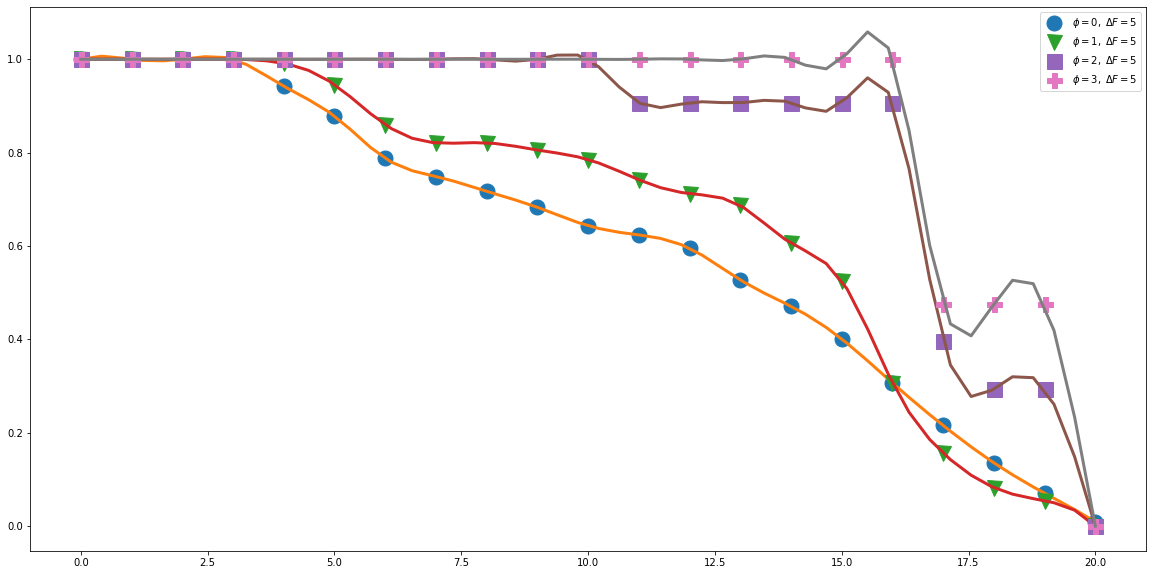

In [67]:
for phi in range(4):
    plt.plot(survivalnc['mit'][phi].index, survivalnc['mit'][phi][0], marker=markers[phi], markersize=15, linestyle=" ", label=fr"$\phi = {phi}, \; \Delta F = 5$")
    plt.plot(splines[phi][0], splines[phi][1], "-", lw=3)
    plt.legend()

And now I can take the derivative of the curves above

In [68]:
derivatives = {}
for phi in splines.keys():
    x = splines[phi][0]
    y = splines[phi][1]
    dy = []
    dx = []
    for i in range(1, len(x) - 1):
        dx.append((x[i - 1] + x[i + 1]) / 2)
        dy.append(((y[i + 1] - y[i - 1]) / 2 * dx[-1]) * -1)
    derivatives[phi] = (dx, dy)

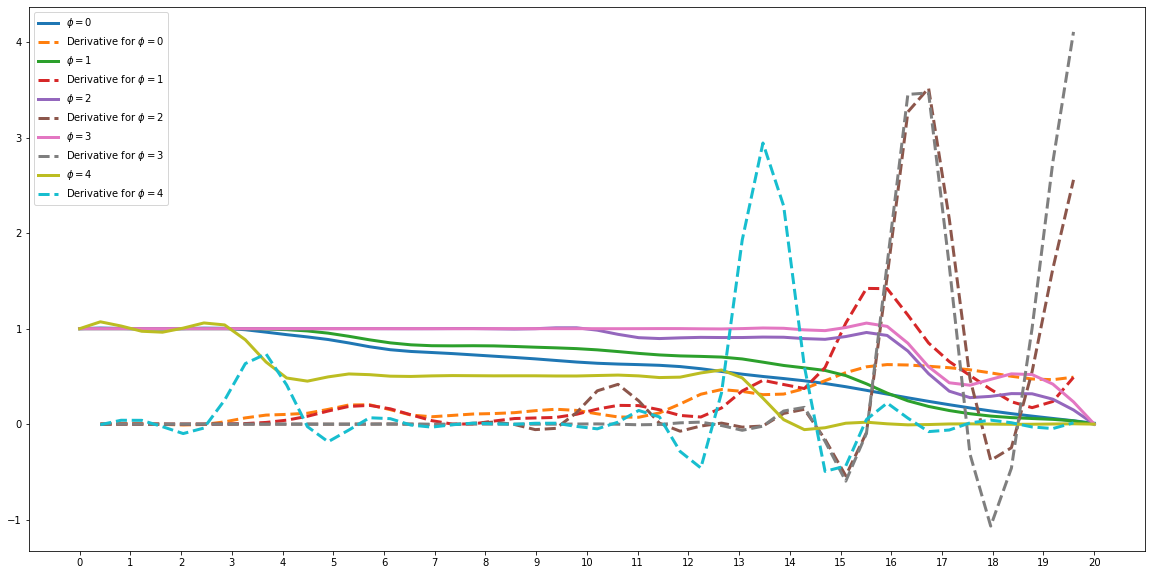

In [69]:
for phi in range(5):
    plt.xticks(range(21))
    #plt.plot(survivalnc['mit'][phi].index, survivalnc['mit'][phi][0], marker=markers[phi], markersize=15, linestyle=" ", label=fr"$\phi = {phi}, \; \Delta F = 5$")
    plt.plot(splines[phi][0], splines[phi][1], "-", lw=3, label=fr"$\phi = {phi}$")
    plt.plot(derivatives[phi][0], [i * 1 for i in derivatives[phi][1]], "--", lw=3, label=fr"Derivative for $\phi = {phi}$")
    plt.legend()

In [70]:
lcstar = []
for phi in sorted(list(derivatives.keys())):
    y = list(derivatives[phi][1])
    idx = y.index(min(y))
    lcstar.append([phi, list(derivatives[phi][0])[idx]])

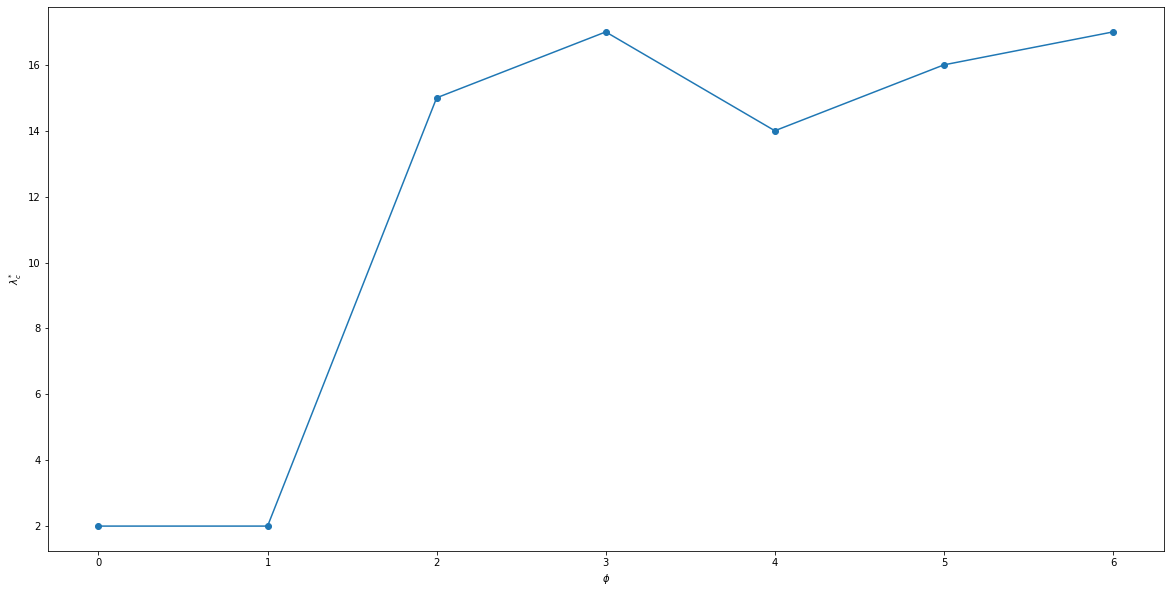

In [71]:
plt.xlabel(fr"$\phi$")
plt.ylabel(r"$\lambda^{*}_{c}$")
plt.plot([x[0] for x in lcstar], [int(y[1]) for y in lcstar], "o-")

## Function with to obtain splines, derivatives and lambdastar

In [72]:
def get_splines(survivaldf, order, xpoints):
    result = {}
    for phi in survivaldf.keys():
        x = list(survivaldf[phi].index)
        xmin = min(x)
        xmax = max(x)
        y = list(survivaldf[phi][0])
        sp = interpol.UnivariateSpline(x, y, k = order, s=0)
        x_new = np.linspace(xmin, xmax, xpoints)
        y_new = sp(x_new)
        result[phi] = [x_new, y_new]
    return result

In [73]:
def get_derivatives(splinesdf):
    result = {}
    for phi in splinesdf.keys():
        x = splinesdf[phi][0]
        y = splinesdf[phi][1]
        dy = []
        dx = []
        for i in range(1, len(x) - 1):
            dx.append((x[i - 1] + x[i + 1]) / 2)
            dy.append(((y[i + 1] - y[i - 1]) / 2 * dx[-1]) * -1)
        result[phi] = (dx, dy)
    return result

In [74]:
def lambdastar(derivativesdata):
    result = {}
    for phi in sorted(list(derivativesdata.keys())):
        y = list(derivativesdata[phi][1])
        idx = y.index(min(y))
        result[phi] = list(derivativesdata[phi][0])[idx]
    result = pd.DataFrame.from_dict(result, orient='index')
    result.sort_index(inplace=True)
    return result

## Survival curves and their derivatives

In [75]:
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [76]:
splines  = {}
derivatives = {}
lstar = {}

for c in survivalnc2.keys():
    splines[c] = get_splines(survivalnc2[c], 4, 50)
    derivatives[c] = get_derivatives(splines[c])
    lstar[c] = lambdastar(derivatives[c])

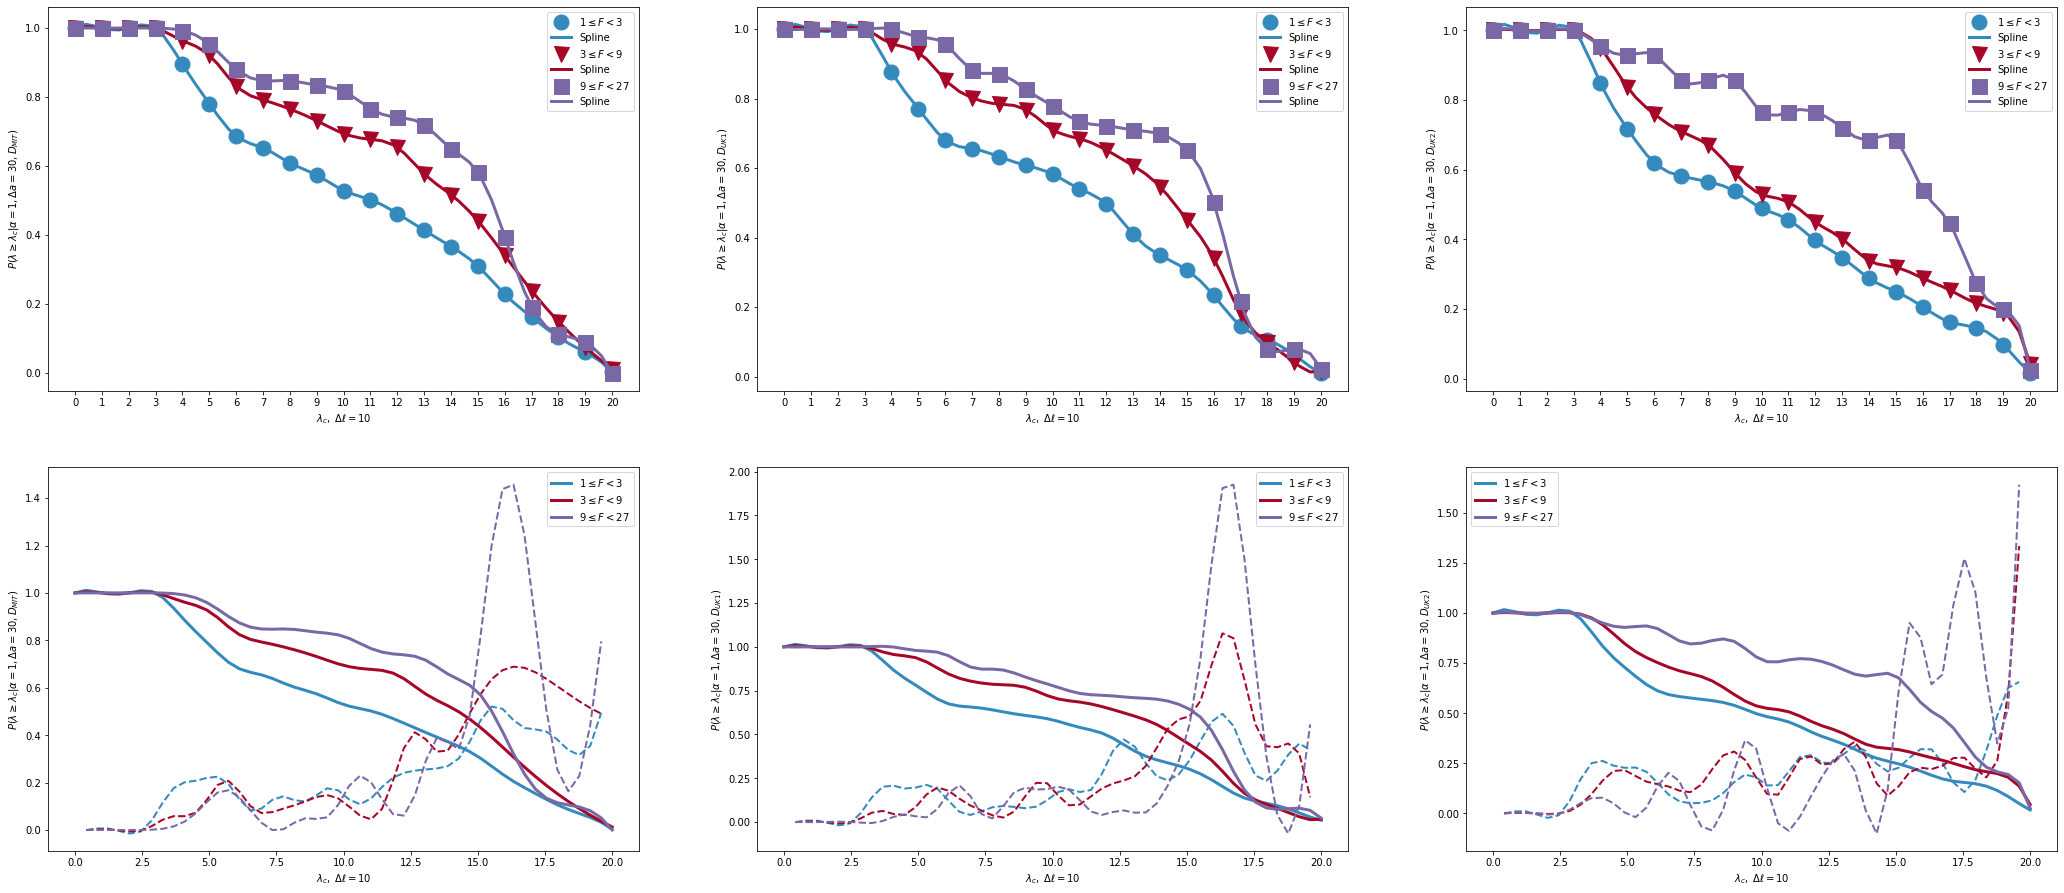

In [77]:
plt.figure(figsize=(36, 24))
legends = [fr'${3**i} \leq F < {3**(i + 1)}$' for i in range(3)]
for row in range(2):
    for col in range(len(survivalnc2.keys())):
        p = (row * 3) + (col + 1)
        plt.subplot(3, 3, p)
        if (p - 1) // 3 == 0:
            data = ['mit', 'uk1', 'uk2']
            plt.ylabel(fr"$P(\lambda \geq \lambda_c | \alpha = 1, \Delta a = 30, {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][col]})$")
            plt.xlabel(fr"$\lambda_c, \; \Delta \ell = 10$")
            plt.xticks(range(21))
            for phi in range(3):
                plt.plot(survivalnc2[data[col]][phi].index, survivalnc2[data[col]][phi][0], marker=markers[phi], markersize=15, linestyle=" ", color=colors[phi], label=legends[phi])
                plt.plot(splines[data[col]][phi][0], splines[data[col]][phi][1], "-", lw=3, color=colors[phi], label=fr'Spline')
            plt.legend()
        elif (p - 1) // 3 == 1:
            data = ['mit', 'uk1', 'uk2']
            plt.ylabel(fr"$P(\lambda \geq \lambda_c | \alpha = 1, \Delta a = 30, {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][col]})$")
            plt.xlabel(fr"$\lambda_c, \; \Delta \ell = 10$")
            for phi in range(3):
                plt.plot(splines[data[col]][phi][0], splines[data[col]][phi][1], "-", lw=3, color=colors[phi], label=legends[phi])
                plt.plot(derivatives[data[col]][phi][0], derivatives[data[col]][phi][1], "--", lw=2, color=colors[phi])
            plt.legend()

In [78]:
plots = {}
for phi in range(3):
    plots[phi] = {}
    for c in survivalnc2.keys():
        for x in survivalnc2[c][phi].index:
            plots[phi][x] = plots[phi].get(x, 0) + survivalnc2[c][phi].at[x, 0]

In [79]:
for s in plots.keys():
    for x in plots[s].keys():
        plots[s][x] = plots[s][x] / 3

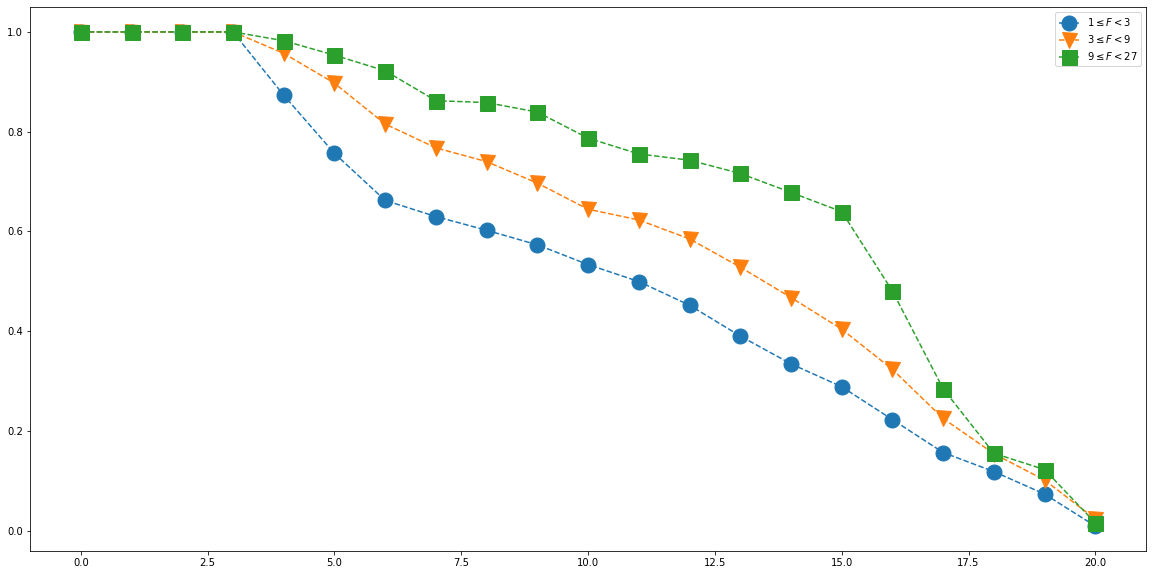

In [80]:
for s in range(3):
    plt.plot(plots[s].keys(), plots[s].values(), marker=markers[s], markersize=15, linestyle="--", label=legends[s])
plt.legend()

In [81]:
splines4  = {}
derivatives4 = {}
lstar4 = {}

for c in survivalnc4.keys():
    splines4[c] = get_splines(survivalnc4[c], 4, 50)
    derivatives4[c] = get_derivatives(splines4[c])
    lstar4[c] = lambdastar(derivatives4[c])

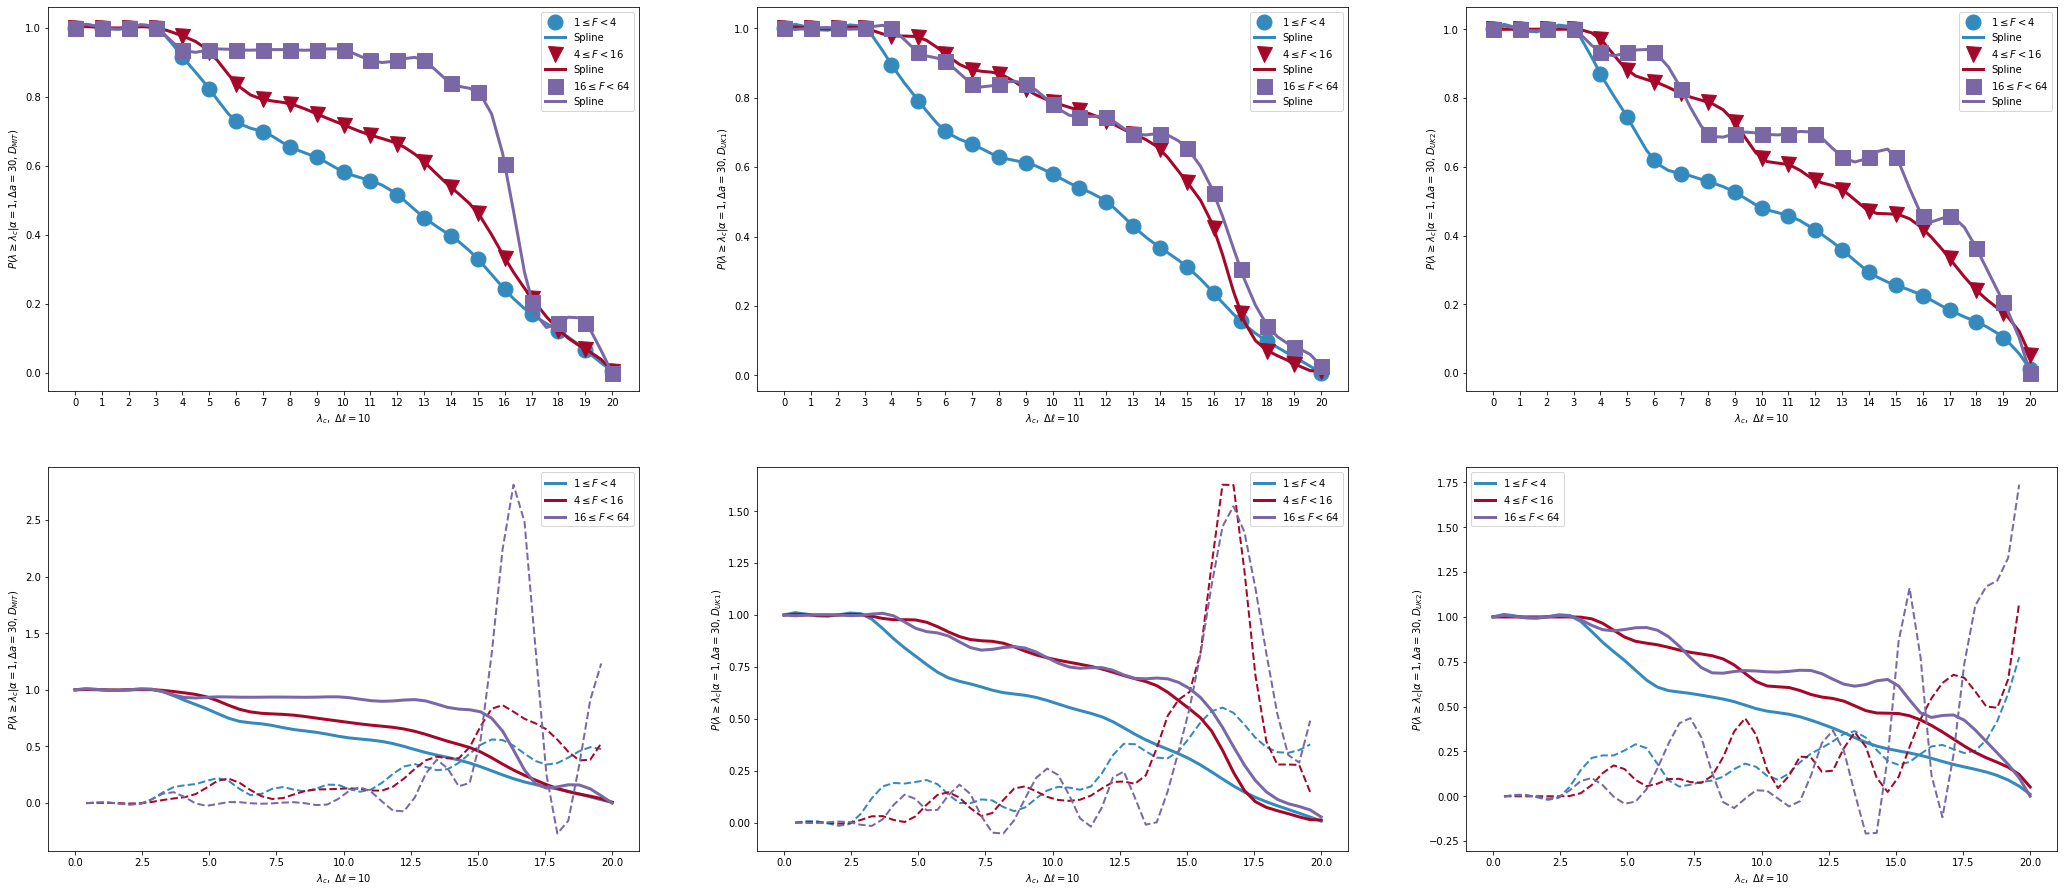

In [82]:
plt.figure(figsize=(36, 24))
legends = [fr'${4**i} \leq F < {4**(i + 1)}$' for i in range(3)]
for row in range(2):
    for col in range(len(survivalnc4.keys())):
        p = (row * 3) + (col + 1)
        plt.subplot(3, 3, p)
        if (p - 1) // 3 == 0:
            data = ['mit', 'uk1', 'uk2']
            plt.ylabel(fr"$P(\lambda \geq \lambda_c | \alpha = 1, \Delta a = 30, {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][col]})$")
            plt.xlabel(fr"$\lambda_c, \; \Delta \ell = 10$")
            plt.xticks(range(21))
            for phi in range(3):
                plt.plot(survivalnc4[data[col]][phi].index, survivalnc4[data[col]][phi][0], marker=markers[phi], markersize=15, linestyle=" ", color=colors[phi], label=legends[phi])
                plt.plot(splines4[data[col]][phi][0], splines4[data[col]][phi][1], "-", lw=3, color=colors[phi], label=fr'Spline')
            plt.legend()
        elif (p - 1) // 3 == 1:
            data = ['mit', 'uk1', 'uk2']
            plt.ylabel(fr"$P(\lambda \geq \lambda_c | \alpha = 1, \Delta a = 30, {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][col]})$")
            plt.xlabel(fr"$\lambda_c, \; \Delta \ell = 10$")
            for phi in range(3):
                plt.plot(splines4[data[col]][phi][0], splines4[data[col]][phi][1], "-", lw=3, color=colors[phi], label=legends[phi])
                plt.plot(derivatives4[data[col]][phi][0], derivatives4[data[col]][phi][1], "--", lw=2, color=colors[phi])
            plt.legend()

In [83]:
def get_survivala(fresult, alphafixed, lcrange):
    result = {}
    fdist = pc.f_histell(fresult, alphafixed, [1000])
    for phi in fdist.keys():
        result[phi] = {}
        df = fdist[phi]
        df['p'] = df[0] / sum(df[0])
        for lc in lcrange:
            df2 = df.loc[df.index >= lc]
            result[phi][lc] = sum(df2['p'])
        result[phi] = pd.DataFrame.from_dict(result[phi], orient='index')
        result[phi].sort_index(inplace=True)
    return result

In [84]:
survivalnca = {}
for c in callsnc.keys():
    dffnc = pc.get_f(callsnc[c], 'all', 30, 10)
    %time survivalnca[c] = get_survival4(dffnc, 1, range(21))

/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 4.88 s, sys: 25.6 ms, total: 4.91 s
Wall time: 4.93 s


/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 2.66 s, sys: 20.8 ms, total: 2.68 s
Wall time: 2.68 s


/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 1.16 s, sys: 3.07 ms, total: 1.17 s
Wall time: 1.17 s


# Create a complete dataset

This means, for the phone calls dataset, combine al three cohorts into one and measure the same things as before but for this big dataset

In [85]:
callsnc['all'] = pd.DataFrame()
for c in ['mit', 'uk1', 'uk2']:
    callsnc['all'] = callsnc['all'].append(callsnc[c]).reset_index(drop=True)

In [86]:
for c in callsnc.keys():
    pairsnc[c] = pc.pairs(callsnc[c])
    livesnc[c] = pc.lives_dictionary(callsnc[c])

In [87]:
dff = {}
for c in callsnc.keys():
    dff[c] = pc.get_f(callsnc[c], 'all', 70, 10)
    
bplot = {}
for c in dff.keys():
    b = pc.get_b(dff[c], 'lambda')
    bplot[c] = pc.plot_g(b, 'lambda')

/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


In [88]:
dff2 = {}
for c in callsnc.keys():
    dff2[c] = pc.get_f(callsnc[c], 'all', 10, 70)

bplot2 = {}
for c in dff2.keys():
    b = pc.get_b(dff2[c], 'alpha')
    bplot2[c] = pc.plot_g(b, 'alpha')

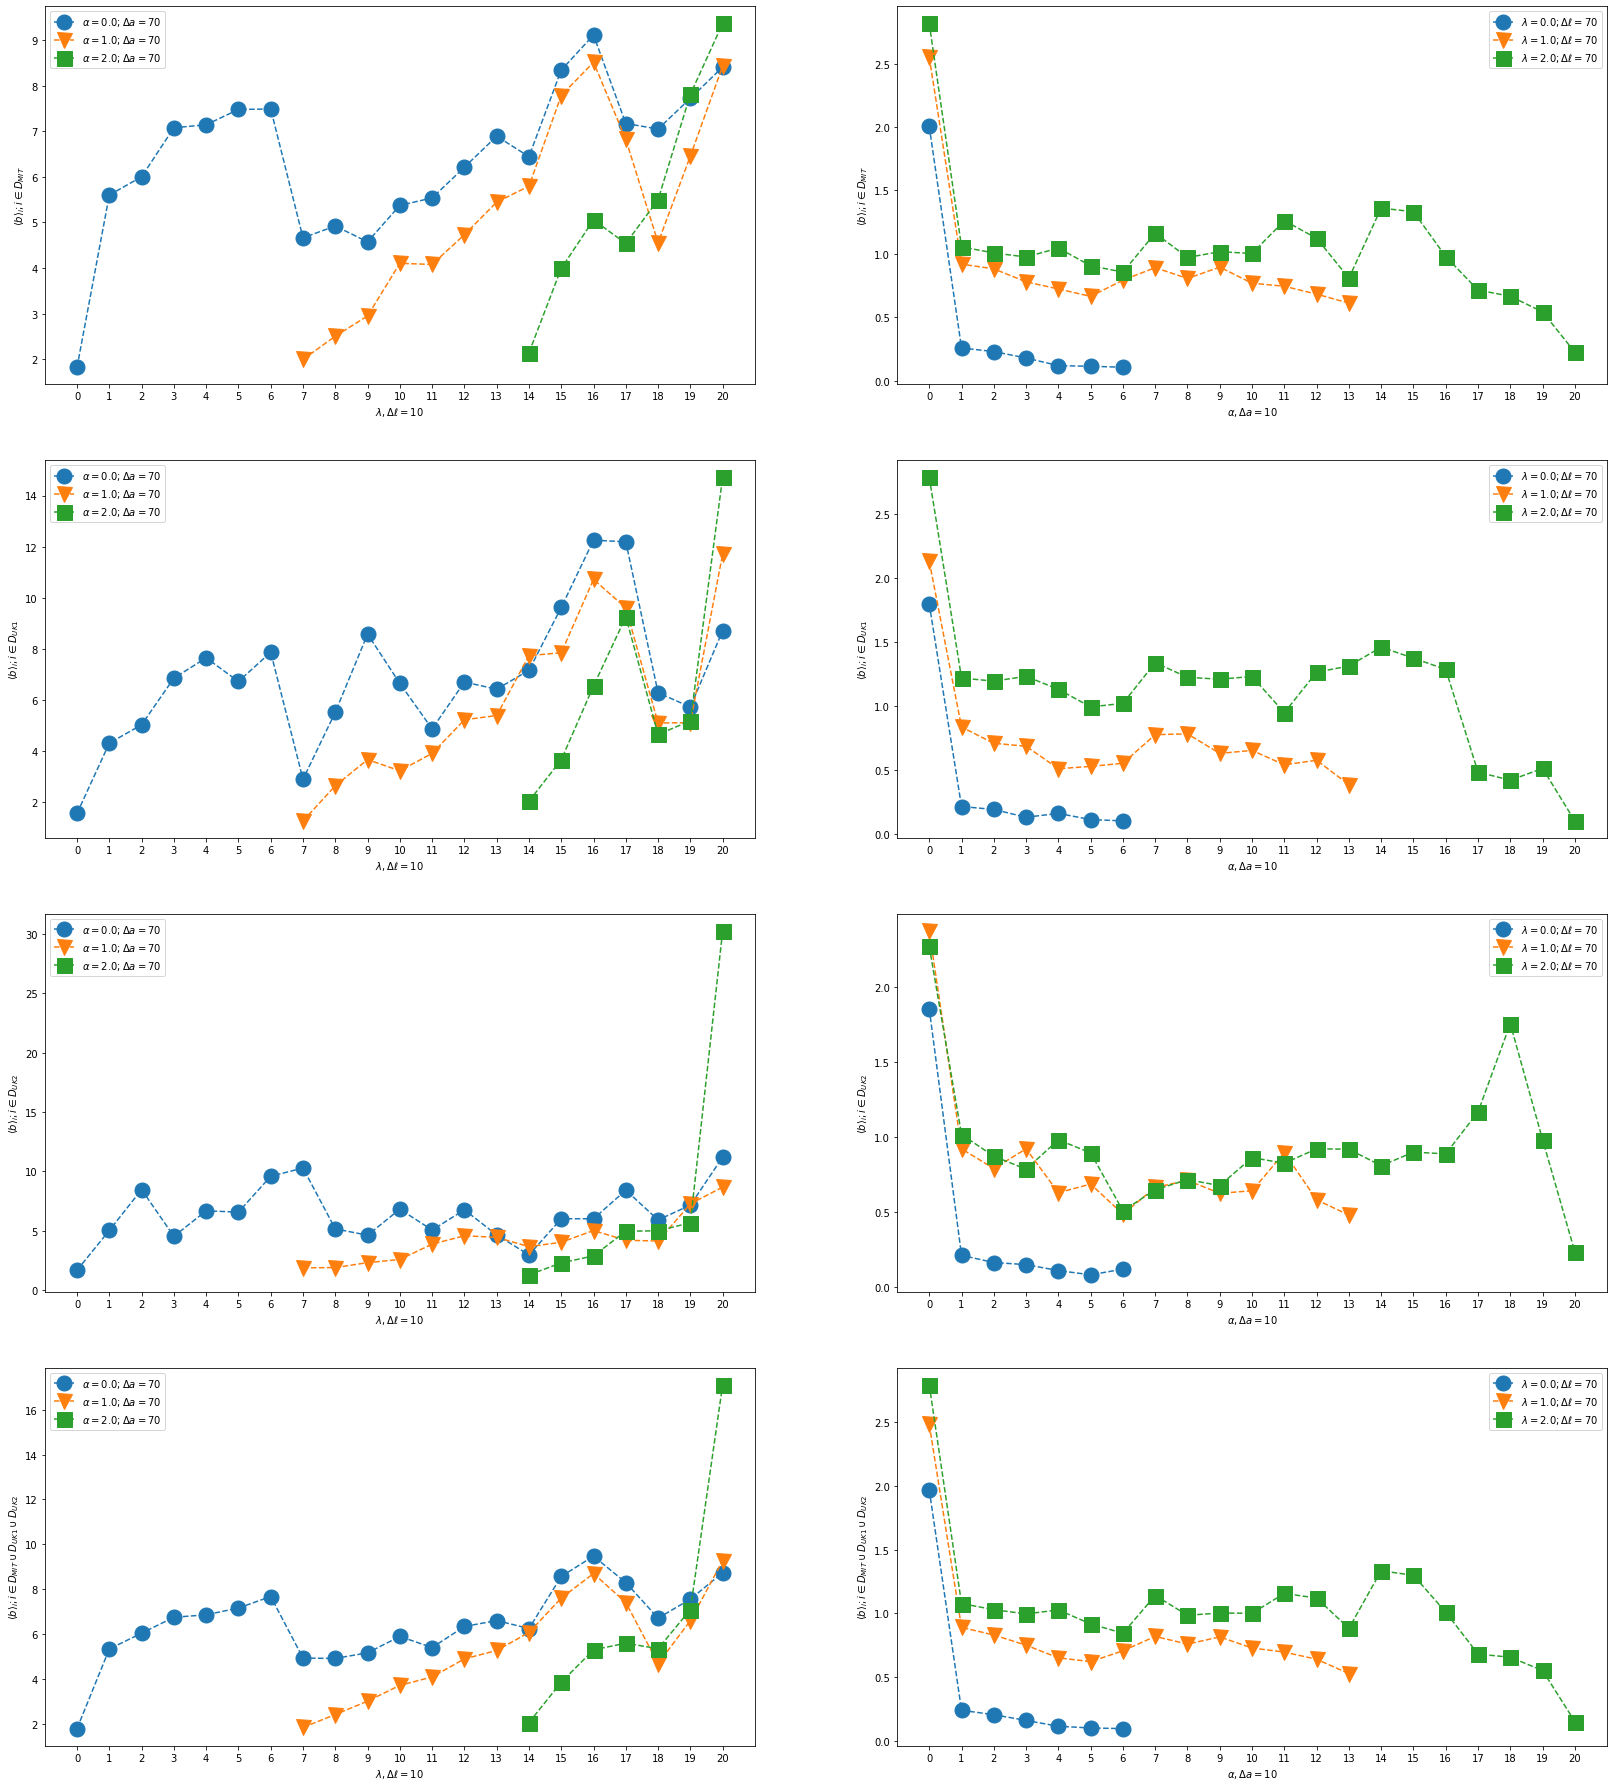

In [89]:
plt.figure(figsize=(28, 32))
p = 1
labels = ['D_{MIT}', 'D_{UK1}', 'D_{UK2}', 'D_{MIT} \cup D_{UK1} \cup D_{UK2}']
data = ['mit', 'uk1', 'uk2', 'all']
for c in range(len(data) * 2):
    plt.subplot(4, 2, p)
    plt.ylabel(fr"$\langle b \rangle_i; i \in {labels[(p - 1) // 2]}$")
    plt.xticks(range(21))
    m = 0
    if (p - 1) % 2 == 0:
        plt.xlabel(r"$\lambda, \Delta \ell = 10$") 
        for alpha in bplot[data[c // 2]].keys():
            plt.plot(bplot[data[c // 2]][alpha].index, bplot[data[c // 2]][alpha]['lambda'], marker=markers[m], markersize=15, linestyle="--", label=fr'$\alpha = {alpha}; \Delta a = 70$')
            m += 1
        p += 1
    else:
        plt.xlabel(r"$\alpha, \Delta a = 10$")
        for lamb in bplot2[data[c // 2]].keys():
            plt.plot(bplot2[data[c // 2]][lamb].index, bplot2[data[c // 2]][lamb]['alpha'], marker=markers[m], markersize=15, linestyle="--", label=fr'$\lambda = {lamb}; \Delta \ell = 70$')
            m += 1
        p += 1
    plt.legend()

In [90]:
#for c in bplot.keys():
#    tmp = pd.DataFrame()
#    for s in bplot[c].keys():
#        df = bplot[c][s]
#        df.columns = [f'a{int(s)}']
#        if len(tmp) == 0:
#            tmp = tmp.append(df)
#        else:
#            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#    tmp.index.rename('lambda', inplace=True)
#    tmp.fillna('nan', inplace=True)
#    tmp.to_csv(f"../commpatterns/data/blamb_{c}.dat", header=True, sep="\t")
#    
#for c in bplot2.keys():
#    tmp = pd.DataFrame()
#    for s in bplot2[c].keys():
#        df = bplot2[c][s]
#        df.columns = [f'l{int(s)}']
#        if len(tmp) == 0:
#            tmp = tmp.append(df)
#        else:
#            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#    tmp.index.rename('alpha', inplace=True)
#    tmp.fillna('nan', inplace=True)
#    tmp.to_csv(f"../commpatterns/data/bal_{c}.dat", header=True, sep="\t")

## Update survival curve function
Now I have to calculate the survival curves for each cohort. To start, I will use powers of 2 for the grouping of $F$

In [91]:
def get_survival(fresult, alphafixed, lcrange, base, powers=True):
    result = {}
    if powers:
        fdist = pc.f_histell(fresult, alphafixed, [base**i for i in range(1, 6)])
    else:
        fdist = pc.f_histell(fresult, alphafixed, binned=True, deltaF=base)
    for phi in fdist.keys():
        result[phi] = {}
        df = fdist[phi]
        df['p'] = df[0] / sum(df[0])
        for lc in lcrange:
            df2 = df.loc[df.index >= lc]
            result[phi][lc] = sum(df2['p'])
        result[phi] = pd.DataFrame.from_dict(result[phi], orient='index')
        result[phi].sort_index(inplace=True)
    return result

In [104]:
dffnc2 = {}
survivalnc2 = {}
for c in callsnc.keys():
    dffnc2[c] = pc.get_f(callsnc[c], 'all', 30, 10)
    survivalnc2[c] = get_survival(dffnc2[c], 1, base=2, lcrange=range(1, 21))

/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [105]:
dffnc3 = {}
survivalnc3 = {}
for c in callsnc.keys():
    dffnc3[c] = pc.get_f(callsnc[c], 'all', 30, 10)
    survivalnc3[c] = get_survival(dffnc3[c], 1, base=3, lcrange=range(1, 21))

/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina
/Users/vsvh/docs/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

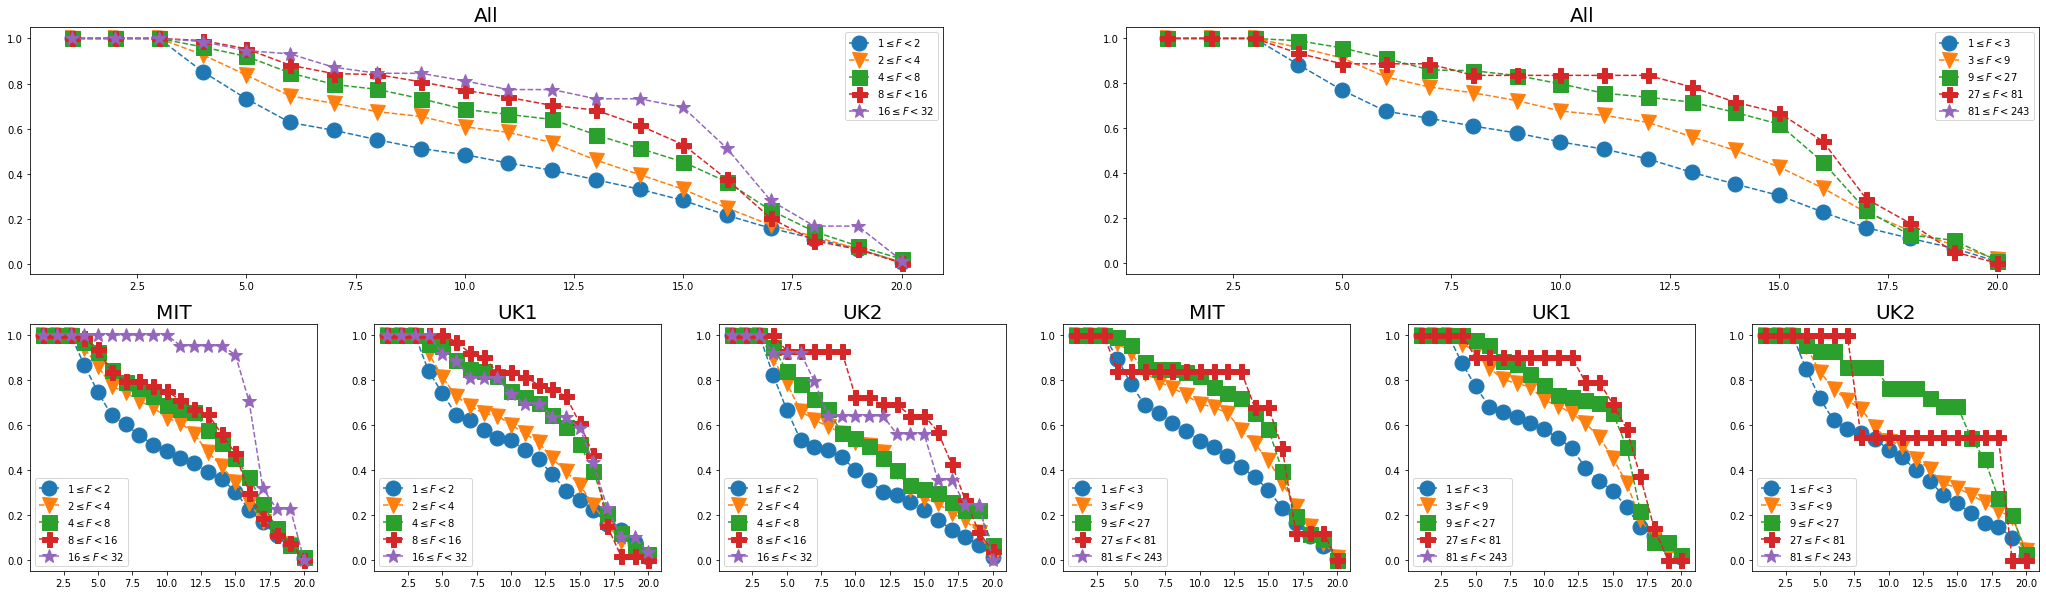

In [112]:
series2 = [f'${2**i} \leq F < {2**(i + 1)}$' for i in range(5)]
series3 = [f'${3**i} \leq F < {3**(i + 1)}$' for i in range(5)]
plt.figure(figsize=(36, 10))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,6,7)
ax3 = plt.subplot(2,6,8)
ax4 = plt.subplot(2,6,9)
ax5 = plt.subplot(2,2,2)
ax6 = plt.subplot(2,6,10)
ax7 = plt.subplot(2,6,11)
ax8 = plt.subplot(2,6,12)

axes = (ax1, ax5, ax2, ax3, ax4, ax6, ax7, ax8)

ax1.set_title("All", fontsize=20)
for i in range(5):
    ax1.plot(survivalnc2['all'][i].index, survivalnc2['all'][i][0], marker=markers[i], markersize=15, linestyle="--", label=series2[i])
ax1.legend()

ax2.set_title("MIT", fontsize=20)
for i in range(5):
    ax2.plot(survivalnc2['mit'][i].index, survivalnc2['mit'][i][0], marker=markers[i], markersize=15, linestyle="--", label=series2[i])
ax2.legend()

ax3.set_title("UK1", fontsize=20)
for i in range(5):
    ax3.plot(survivalnc2['uk1'][i].index, survivalnc2['uk1'][i][0], marker=markers[i], markersize=15, linestyle="--", label=series2[i])
ax3.legend()

ax4.set_title("UK2", fontsize=20)
for i in range(5):
    ax4.plot(survivalnc2['uk2'][i].index, survivalnc2['uk2'][i][0], marker=markers[i], markersize=15, linestyle="--", label=series2[i])
ax4.legend()

ax5.set_title("All", fontsize=20)
for i in range(5):
    ax5.plot(survivalnc3['all'][i].index, survivalnc3['all'][i][0], marker=markers[i], markersize=15, linestyle="--", label=series3[i])
ax5.legend()

ax6.set_title("MIT", fontsize=20)
for i in range(5):
    ax6.plot(survivalnc3['mit'][i].index, survivalnc3['mit'][i][0], marker=markers[i], markersize=15, linestyle="--", label=series3[i])
ax6.legend()

ax7.set_title("UK1", fontsize=20)
for i in range(5):
    ax7.plot(survivalnc3['uk1'][i].index, survivalnc3['uk1'][i][0], marker=markers[i], markersize=15, linestyle="--", label=series3[i])
ax7.legend()

ax8.set_title("UK2", fontsize=20)
for i in range(5):
    ax8.plot(survivalnc3['uk2'][i].index, survivalnc3['uk2'][i][0], marker=markers[i], markersize=15, linestyle="--", label=series3[i])
ax8.legend()

In [94]:
#for c in survivalnc.keys():
#    tmp = pd.DataFrame()
#    for s in range(5):
#        df = survivalnc[c][s]
#        df.columns = [f'f{int(s)}']
#        if len(tmp) == 0:
#            tmp = tmp.append(df)
#        else:
#            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#    tmp.index.rename('lc', inplace=True)
#    tmp.fillna('nan', inplace=True)
#    tmp.to_csv(f"../commpatterns/data/survival_{c}.dat", header=True, sep="\t")

In [114]:
def get_derivatives(survivalcurve):
    result = {}
    for phi in survivalcurve.keys():
        x = list(survivalcurve[phi].index)
        y = list(survivalcurve[phi][0])
        dy = []
        dx = []
        for i in range(1, len(x) - 1):
            dx.append((x[i - 1] + x[i + 1]) / 2)
            dy.append(((y[i + 1] - y[i - 1]) / 2 * dx[-1]) * -1)
        result[phi] = (dx, dy)
    return result

In [115]:
der = get_derivatives(survivalnc2['all'])

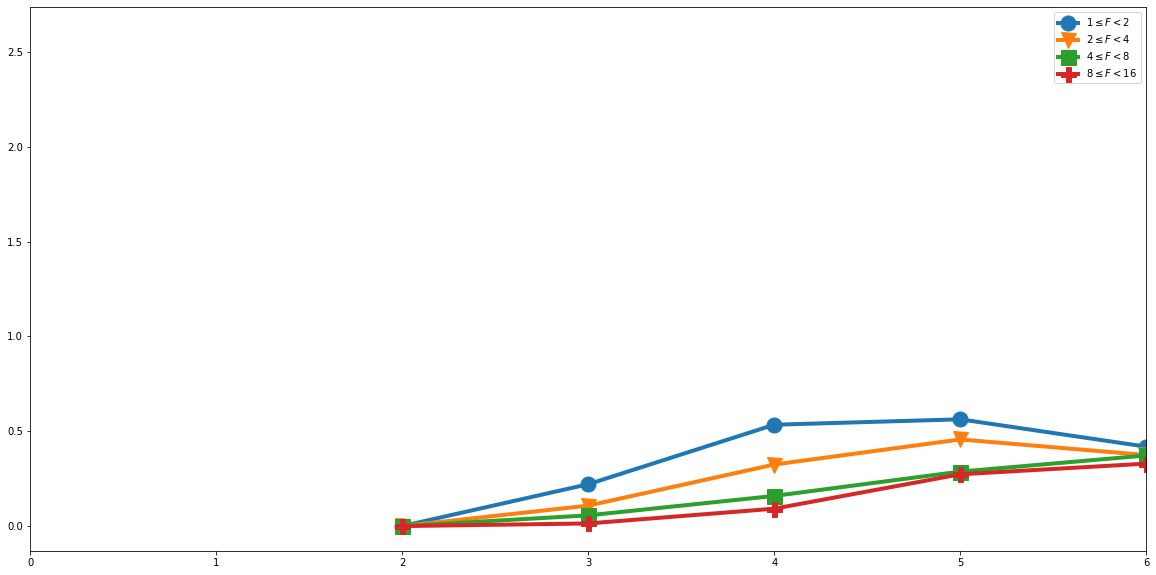

In [117]:
plt.xlim(0, 6)
for i in range(4):
    plt.plot(der[i][0], der[i][1], marker=markers[i], markersize=15, linestyle="-", lw=4, label=series2[i])
plt.legend()

# Histogram of $F$

In [95]:
HF = {}
for c in dff.keys():
    HF[c] = {}
    for ego in dff[c].keys():
        for alter in dff[c][ego].keys():
            for F in dff[c][ego][alter]['f']:
                theF = F
                HF[c][theF] = HF[c].get(theF, 0) + 1
    HF[c] = pd.DataFrame.from_dict(HF[c], orient='index')
    HF[c].sort_index(inplace=True)

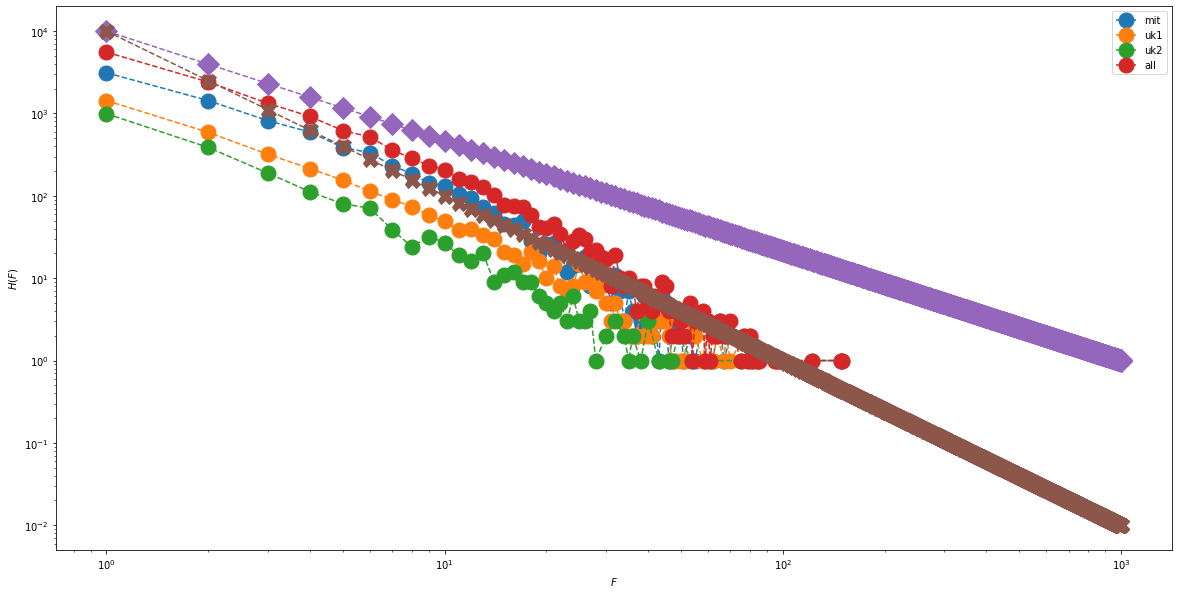

In [96]:
plt.xlabel(r"$F$")
plt.ylabel(r"$H(F)$")
m = 0
plt.yscale("log")
plt.xscale("log")
for c in HF.keys():
    plt.plot(HF[c].index, HF[c][0], marker=markers[m], markersize=15, linestyle="--", label=fr"{c}")
plt.plot(list(range(1, 10**3 + 1)), [(10**4 * i**(-4 / 3)) for i in range(1, 10**3 + 1)], marker="D", markersize=15, linestyle="--")
plt.plot(list(range(1, 10**3 + 1)), [(10**4 * i**(-2)) for i in range(1, 10**3 + 1)], marker="X", markersize=15, linestyle="--")
plt.legend()

In [97]:
HF['mit']

0
1    3125
2    1433
3     819
4     594
5     386
6     335
7     232
8     186
9     143
10    132
11    104
12     93
13     74
14     62
15     46
16     44
17     50
18     28
19     20
20     26
21     27
22     21
23     12
24     14
25     15
26     18
27      8
28     14
29     10
30     10
31      5
32     11
33      7
34      3
35      7
36      4
37      2
38      3
39      6
41      2
42      3
43      1
44      6
45      5
46      1
48      3
50      2
51      1
53      2
55      1
58      3
59      1
62      1
65      3
67      1
70      2
81      1
149     1

# Percentiles of $\lambda$

## Using averages

In [98]:
avg = {}
for c in calls.keys():
    %time dfhatf = pc.hatf(calls[c], lives[c])
    %time avg[c] = pc.get_avg(dfhatf, list(range(0, 100)))

CPU times: user 3.47 s, sys: 9.77 ms, total: 3.48 s
Wall time: 3.48 s
CPU times: user 105 ms, sys: 1.61 ms, total: 106 ms
Wall time: 105 ms
CPU times: user 1.34 s, sys: 14.4 ms, total: 1.35 s
Wall time: 1.36 s
CPU times: user 26.6 ms, sys: 348 µs, total: 26.9 ms
Wall time: 26.7 ms
CPU times: user 828 ms, sys: 7.1 ms, total: 835 ms
Wall time: 839 ms
CPU times: user 30.5 ms, sys: 752 µs, total: 31.2 ms
Wall time: 31.7 ms


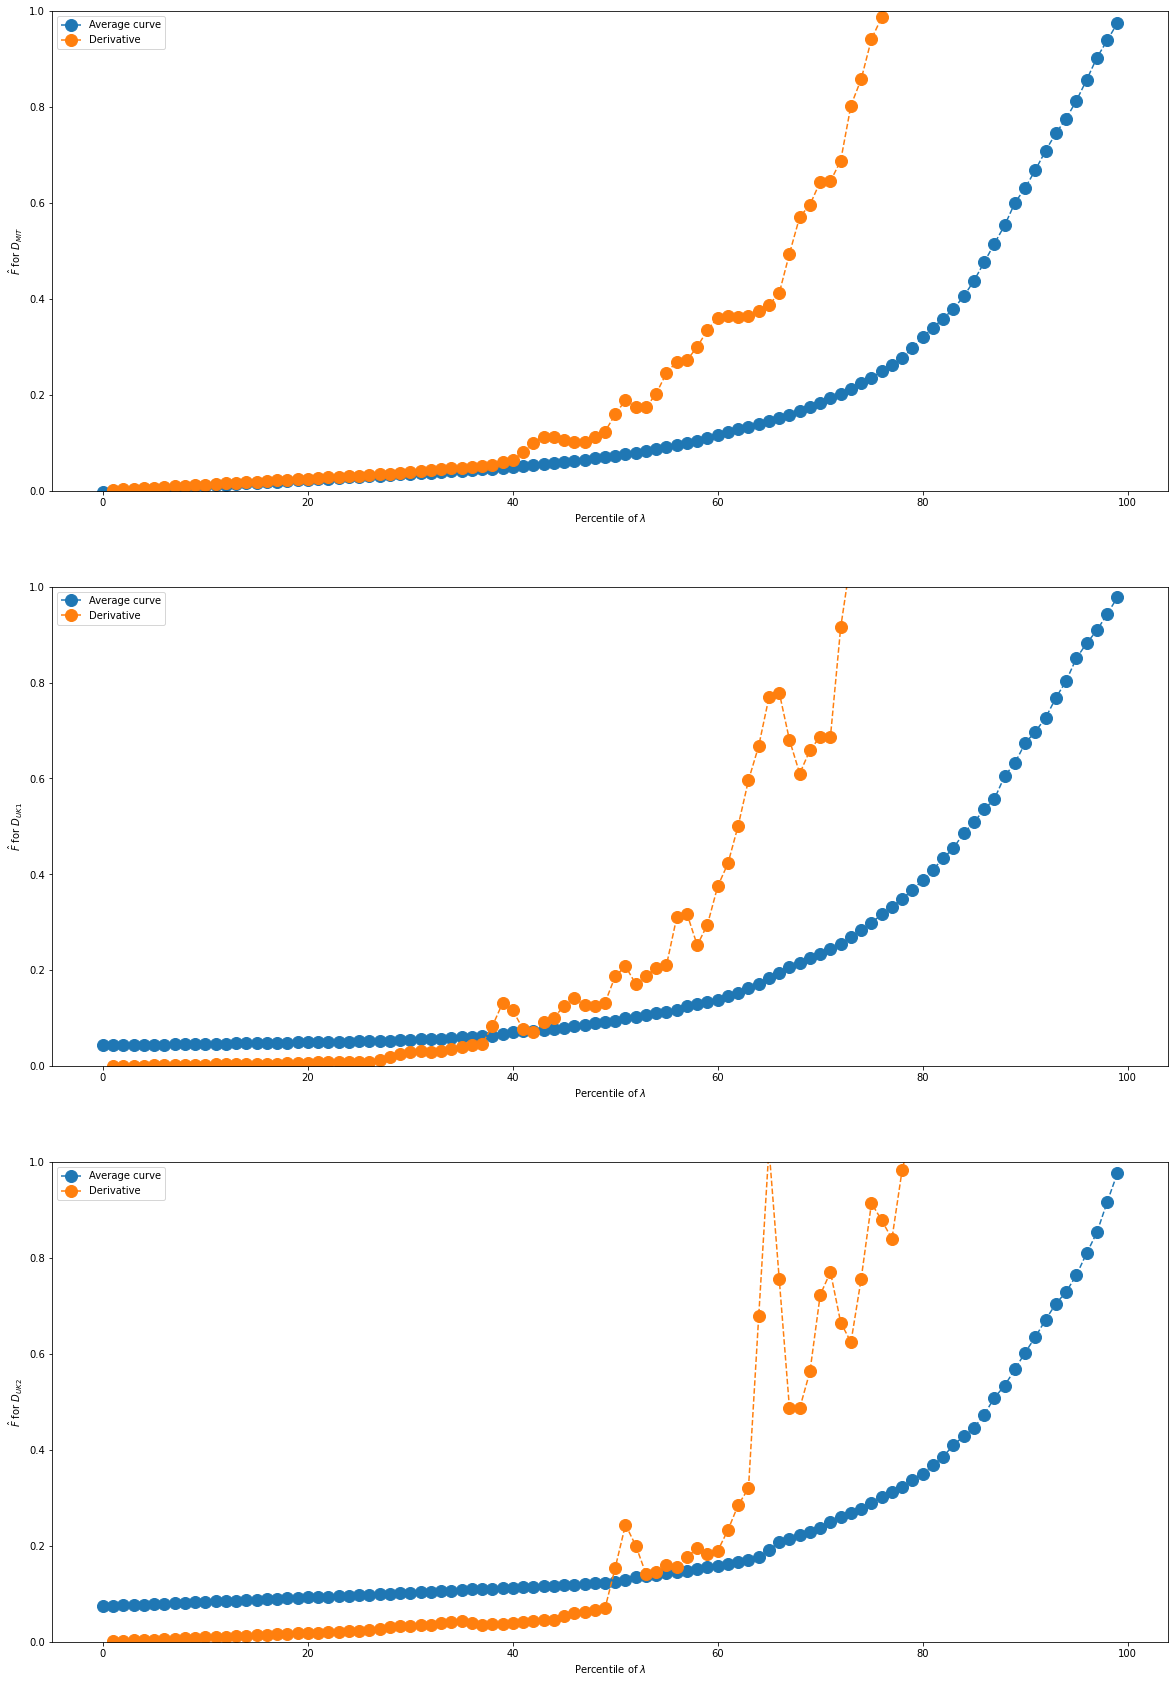

In [99]:
plt.figure(figsize=(20, 30))
p = 1
fhat = '\hat{F}'
for c in avg.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"Percentile of $\lambda$")
    plt.ylabel(fr"${fhat}$ for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p -1]}$")
    plt.ylim(0, 1)
    x = list(avg[c].keys())
    fx = list(avg[c].values())
    df = []
    dx = []
    for i in range(1, len(x) - 1):
        dx.append((x[i - 1] + x[i + 1]) / 2)
        df.append((fx[i + 1] - fx[i - 1]) / 2 * dx[-1])
    plt.plot(x, fx, marker="o", markersize=12, linestyle="--", label="Average curve")
    plt.plot(dx, df, marker="o", markersize=12, linestyle="--", label="Derivative")
    plt.legend()
    p += 1

## Using splines

## Remove social core group